In [1]:
# Libraries
import hoggormplot as hop
import hoggorm as ho
from hoggorm.cross_val import LeaveOneOut
from hoggorm import cross_val
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import shutil
from sys import stdout
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler 
from sklearn.externals import joblib

In [2]:
def load_dir_csv(directory):
    csv_files = sorted( [ f for f in os.listdir(directory) if f.endswith(".txt") ])    
    csv_vars  = [ filename[:-4] for filename in csv_files ]
    gdict = globals()
    for filename, var in zip( csv_files, csv_vars ):
        print(f"{var:32s} = pd.read_csv({directory}/{filename})")
        gdict[var] = pd.read_csv( f"{directory}/{filename}" )
        print(f"{'nb of cols ':32s} = " + str(len(gdict[var])))
        display(gdict[var].head())

load_dir_csv("C:\Python")

Dataset                          = pd.read_csv(C:\Python/Dataset.txt)
nb of cols                       = 44


Sample   AZM    CLT   AZD  CLTD       190       191       192       193  \
0  Cal_01  20.2   6.72  2.50  0.78  3.308227  3.395121  3.455562  3.527321   
1  Cal_02  20.2   3.36  0.00  1.56  2.819046  2.877378  2.911882  2.955613   
2  Cal_03  10.1   3.36  5.00  0.39  2.450861  2.542018  2.612755  2.693547   
3  Cal_04  10.1  10.08  1.25  1.56  2.291964  2.337271  2.365906  2.409659   
4  Cal_05  30.3   5.04  5.00  0.78  4.657196  4.793256  4.890508  4.999354   

        194  ...       391       392       393       394       395       396  \
0  3.583758  ... -0.027220 -0.027028 -0.027514 -0.026277 -0.027345 -0.027892   
1  2.987735  ... -0.024256 -0.023938 -0.024400 -0.023415 -0.024400 -0.024742   
2  2.757591  ... -0.024619 -0.024490 -0.024533 -0.023579 -0.024672 -0.025005   
3  2.443504  ... -0.030497 -0.030178 -0.030692 -0.029416 -0.030517 -0.031035   
4  5.085045  ... -0.032035 -0.031919 -0.032341 -0.031012 -0.032220 -0.032906   

        397       398       399       400  
0 -0.027767 -0.029429 -0.028922 -0.029249  
1 -0.024417 -0.026030 -0.025613 -0.025715  
2 -0.024939 -0.026406 -0.025882 -0.026129  
3 -0.030977 -0.032769 -0.032118 -0.032387  
4 -0.032601 -0.034688 -0.034138 -0.034492  

[5 rows x 216 columns]

In [3]:
Dataset.set_index('Sample', inplace=True)

In [4]:
X=Dataset.loc['Cal_01':'Cal_25', '190':'350']
y=Dataset.loc['Cal_01':'Cal_25', 'AZM':'CLTD']
Xv=Dataset.loc['Val_1':'Val_19', '190':'350']
yv=Dataset.loc['Val_1':'Val_19', 'AZM':'CLTD']
# Samples names
Xsamples=Dataset.index[:25]
Xvsamples=Dataset.index[25:]
Analytes=list(['AZM','CLT','AZD','CLTD'])
# Define wavelength range
Columns_names=np.array(X.columns)
wl_names=Columns_names[:]
wl=list(map(int, wl_names))
wl=np.array(wl)
X=np.array(X)
Xv=np.array(Xv)
y=np.array(y)
yv=np.array(yv)

In [5]:
# Calculate derivatives
X1 = savgol_filter(X, 11, polyorder = 2, deriv=1)
X2 = savgol_filter(X, 13, polyorder = 2,deriv=2)
Xv1 = savgol_filter(Xv, 11, polyorder = 2, deriv=1)
Xv2 = savgol_filter(Xv, 13, polyorder = 2,deriv=2)

In [6]:
# Autoscaled matrices # no need to use this autoscaled matrices in case of hoggorm with scale option is True
Xst=StandardScaler().fit_transform(X[:,:])
X1st=StandardScaler().fit_transform(X1[:,:])
X2st=StandardScaler().fit_transform(X2[:,:])
Xvst=StandardScaler().fit_transform(Xv[:,:])
Xv1st=StandardScaler().fit_transform(Xv1[:,:])
Xv2st=StandardScaler().fit_transform(Xv2[:,:])
yst=StandardScaler().fit_transform(y[:,:])
yvst=StandardScaler().fit_transform(yv[:,:])

In [7]:
TotSpec_ModelD0 = ho.pcr.nipalsPCR(arrX=X, Xstand=True, arrY=y, Ystand=True,cvType=["loo"], numComp=4)
TotSpec_ModelD1 = ho.pcr.nipalsPCR(arrX=X1, Xstand=True, arrY=y, Ystand=True,cvType=["loo"], numComp=4)
TotSpec_ModelD2 = ho.pcr.nipalsPCR(arrX=X2, Xstand=True, arrY=y, Ystand=True,cvType=["loo"], numComp=4)

loo
loo
loo


In [33]:
nTime = datetime.datetime.today().strftime("%d-%m-%Y-%H-%M-%S")
direct =  "./Standazil_plus/"
directory = os.path.join( direct+nTime)
if not os.path.exists(directory):
    os.makedirs(directory)

In [34]:
#Traning prediction results
TotSpec_ModelD0_Ycalc=pd.DataFrame(TotSpec_ModelD0.Y_predCal()[4])
TotSpec_ModelD0_Ycalc.columns,TotSpec_ModelD0_Ycalc.index=Analytes,Xsamples
TotSpec_ModelD1_Ycalc=pd.DataFrame(TotSpec_ModelD1.Y_predCal()[4])
TotSpec_ModelD1_Ycalc.columns,TotSpec_ModelD1_Ycalc.index=Analytes,Xsamples
TotSpec_ModelD2_Ycalc=pd.DataFrame(TotSpec_ModelD2.Y_predCal()[4])
TotSpec_ModelD2_Ycalc.columns,TotSpec_ModelD2_Ycalc.index=Analytes,Xsamples
TotSpec_Ycalc=pd.concat([TotSpec_ModelD0_Ycalc,TotSpec_ModelD1_Ycalc,TotSpec_ModelD2_Ycalc],
                        keys=['Model_D0','Model_D1','Model_D2'],axis=1)
TotSpec_Ycalc.index=Xsamples
# Training set results(Cross Validation)
TotSpec_ModelD0_Yvcalc=pd.DataFrame(TotSpec_ModelD0.Y_predVal()[4])
TotSpec_ModelD0_Yvcalc.columns,TotSpec_ModelD0_Yvcalc.index=Analytes,Xsamples
TotSpec_ModelD1_Yvcalc=pd.DataFrame(TotSpec_ModelD1.Y_predVal()[4])
TotSpec_ModelD1_Yvcalc.columns,TotSpec_ModelD1_Yvcalc.index=Analytes,Xsamples
TotSpec_ModelD2_Yvcalc=pd.DataFrame(TotSpec_ModelD2.Y_predVal()[4])
TotSpec_ModelD2_Yvcalc.columns,TotSpec_ModelD2_Yvcalc.index=Analytes,Xsamples
TotSpec_Yvcalc=pd.concat([TotSpec_ModelD0_Yvcalc,TotSpec_ModelD1_Yvcalc,TotSpec_ModelD2_Yvcalc],
                        keys=['Model_D0','Model_D1','Model_D2'],axis=1)
TotSpec_Yvcalc.index=Xsamples

Traning_set_Prediction=pd.concat([TotSpec_Ycalc,TotSpec_Yvcalc],
                        keys=['After_model_contruction','Cross_Validation(LOO)'],axis=1)

Traning_set_Prediction.to_csv(directory+ r'\Traning_set_Prediction.csv')

In [65]:
#Traning prediction RMSECV results
TotSpec_ModelD0_Y_RMSECV=pd.DataFrame(TotSpec_ModelD0.Y_RMSECV())
TotSpec_ModelD0_Y_RMSECV.columns, TotSpec_ModelD0_Y_RMSECV.index=['Model_D0'],['PC0','PC1','PC2','PC3','PC4']
TotSpec_ModelD1_Y_RMSECV=pd.DataFrame(TotSpec_ModelD1.Y_RMSECV())
TotSpec_ModelD1_Y_RMSECV.columns,TotSpec_ModelD1_Y_RMSECV.index=['Model_D1'],['PC0','PC1','PC2','PC3','PC4']
TotSpec_ModelD2_Y_RMSECV=pd.DataFrame(TotSpec_ModelD2.Y_RMSECV())
TotSpec_ModelD2_Y_RMSECV.columns,TotSpec_ModelD2_Y_RMSECV.index=['Model_D2'],['PC0','PC1','PC2','PC3','PC4']
TotSpec_Y_RMSECV=pd.concat([TotSpec_ModelD0_Y_RMSECV,TotSpec_ModelD1_Y_RMSECV,TotSpec_ModelD2_Y_RMSECV],axis=1)
TotSpec_Y_RMSECV.index=['PC0','PC1','PC2','PC3','PC4']
TotSpec_Y_RMSECV.to_csv(directory+ r'\TotSpec_Y_RMSECV.csv')

# Training set RMSECV results(Individual)
TotSpec_ModelD0_Y_RMSECV_indVar=pd.DataFrame(TotSpec_ModelD0.Y_RMSECV_indVar())
TotSpec_ModelD0_Y_RMSECV_indVar.columns,TotSpec_ModelD0_Y_RMSECV_indVar.index=Analytes,['PC0','PC1','PC2','PC3','PC4']
TotSpec_ModelD1_Y_RMSECV_indVar=pd.DataFrame(TotSpec_ModelD1.Y_RMSECV_indVar())
TotSpec_ModelD1_Y_RMSECV_indVar.columns,TotSpec_ModelD1_Y_RMSECV_indVar.index=Analytes,['PC0','PC1','PC2','PC3','PC4']
TotSpec_ModelD2_Y_RMSECV_indVar=pd.DataFrame(TotSpec_ModelD2.Y_RMSECV_indVar())
TotSpec_ModelD2_Y_RMSECV_indVar.columns,TotSpec_ModelD2_Y_RMSECV_indVar.index=Analytes,['PC0','PC1','PC2','PC3','PC4']
TotSpec_Yv_RMSECV_indVar=pd.concat([TotSpec_ModelD0_Y_RMSECV_indVar,TotSpec_ModelD1_Y_RMSECV_indVar,TotSpec_ModelD2_Y_RMSECV_indVar],
                        keys=['Model_D0','Model_D1','Model_D2'],axis=1)
TotSpec_Yv_RMSECV_indVar.index=['PC0','PC1','PC2','PC3','PC4']
TotSpec_Yv_RMSECV_indVar

TotSpec_Yv_RMSECV_indVar.to_csv(directory+ r'\TotSpec_Yv_RMSECV_indVar.csv')

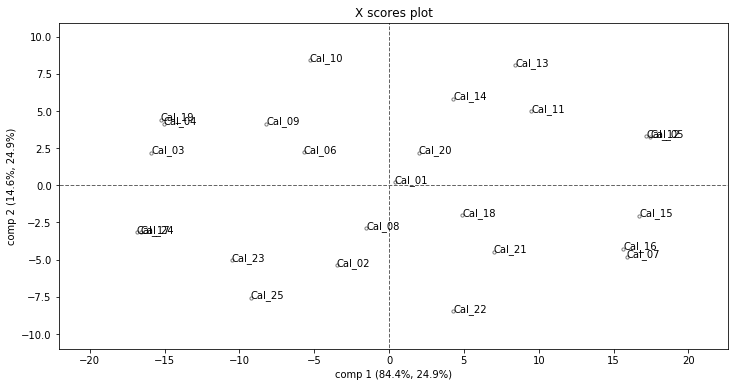

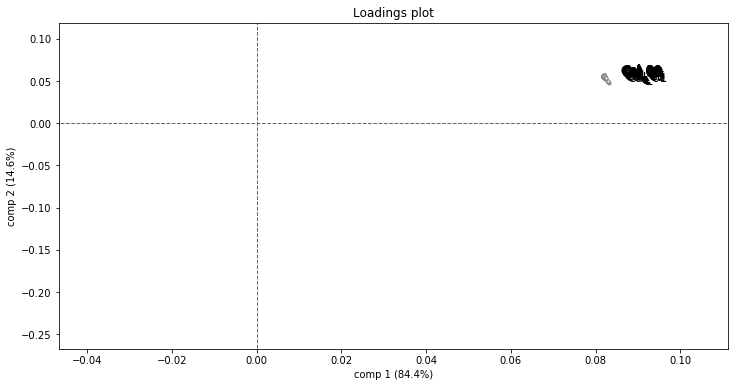

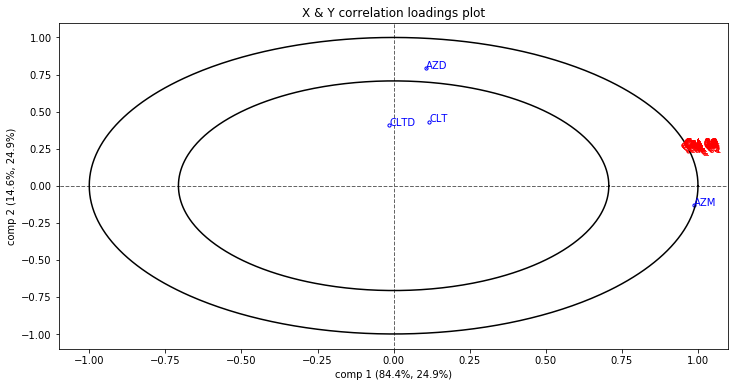

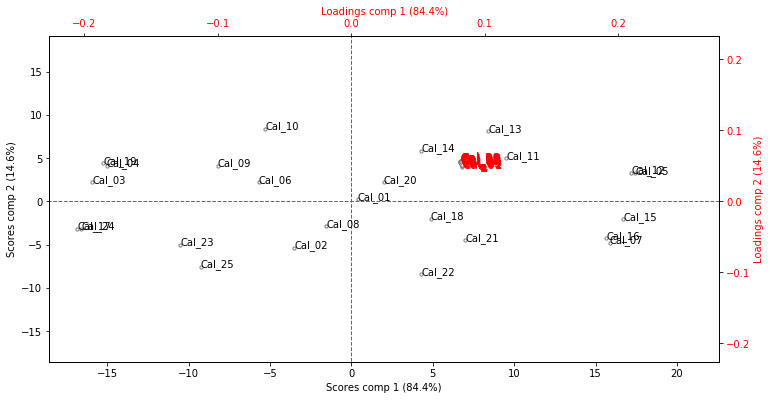

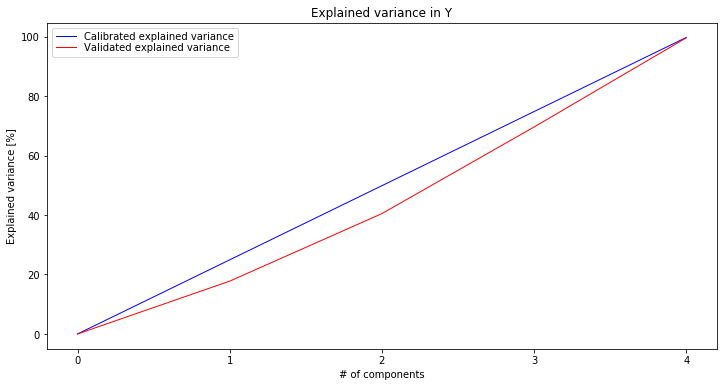

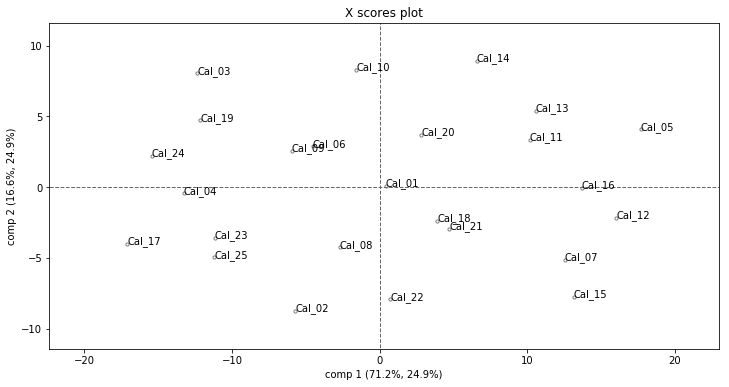

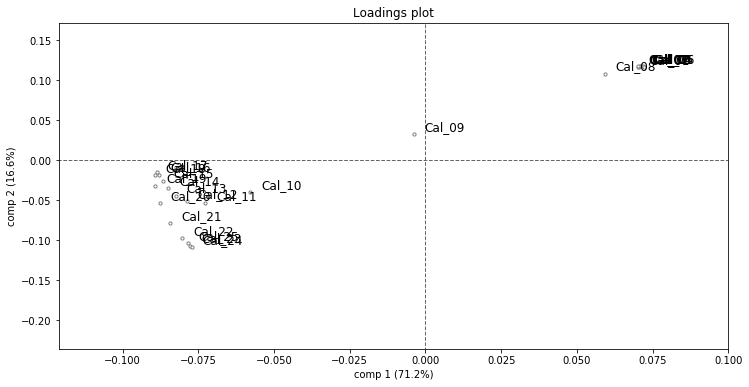

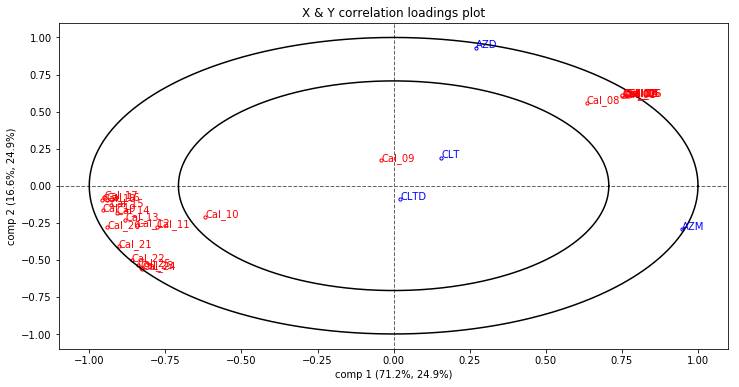

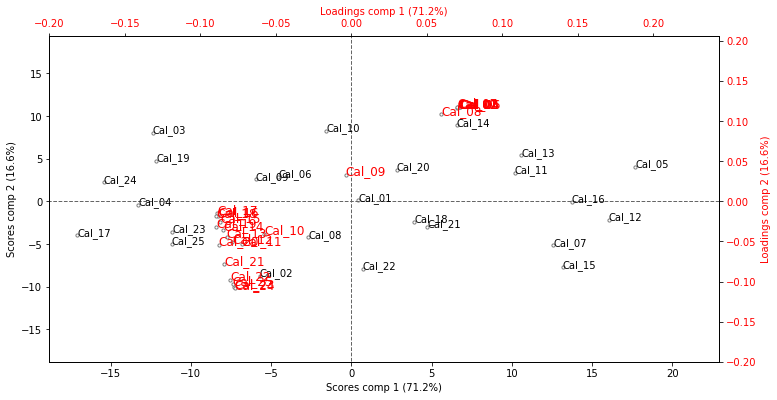

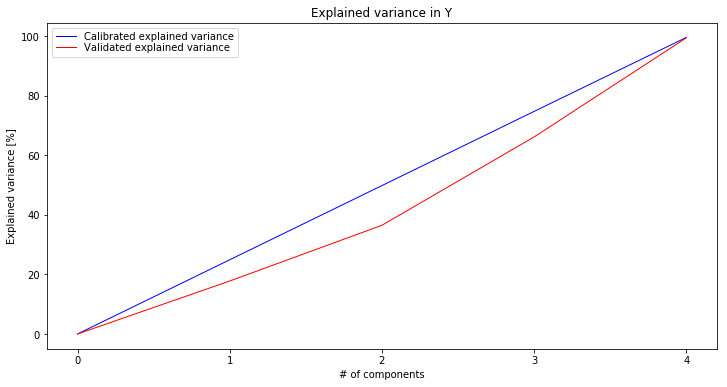

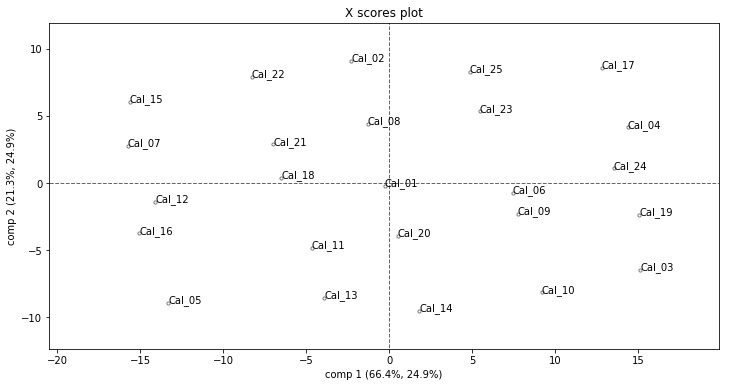

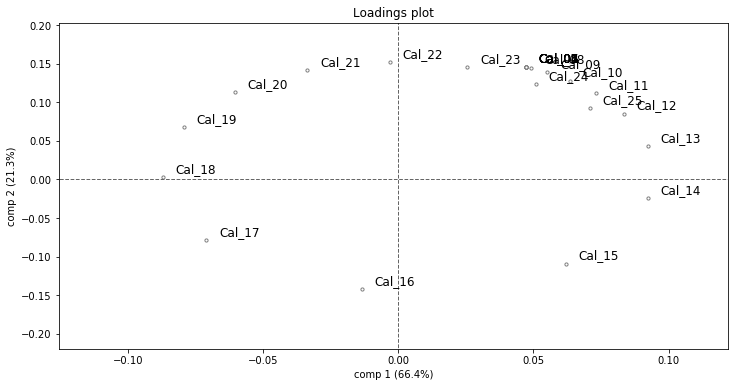

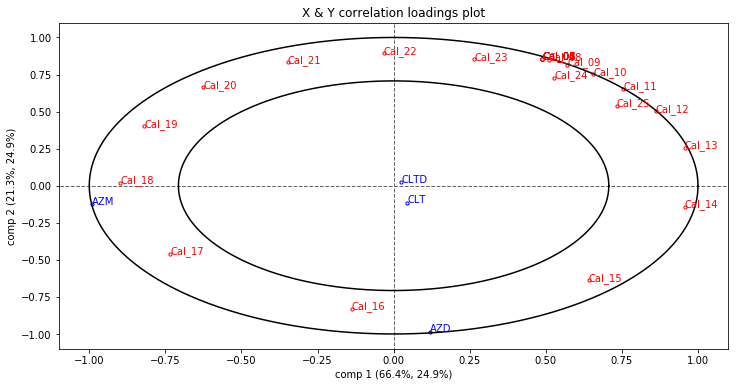

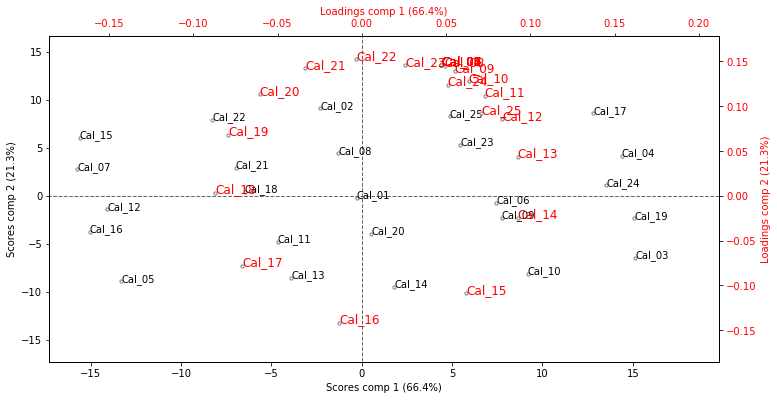

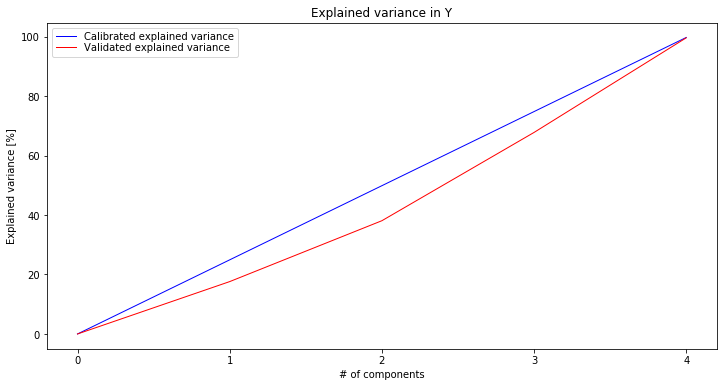

In [8]:
#Graphs of PC1 vs PC2
for i in [TotSpec_ModelD0,TotSpec_ModelD1,TotSpec_ModelD2]:
    hop.plot(i, comp=[1, 2], plots=[1,2,3,4,6], objNames=list(Xsamples),XvarNames=list(Xsamples),YvarNames=Analytes,figsize=[12,6])

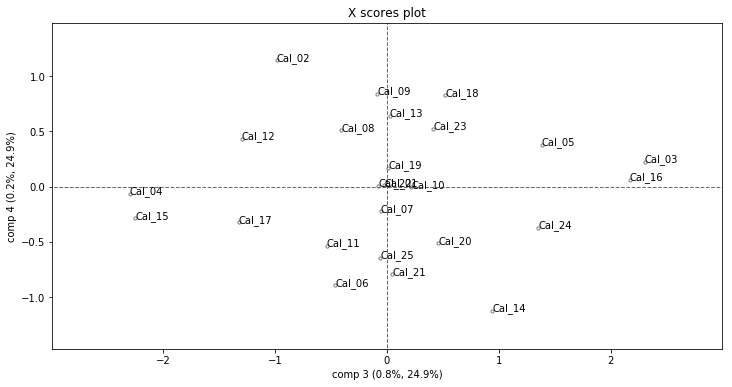

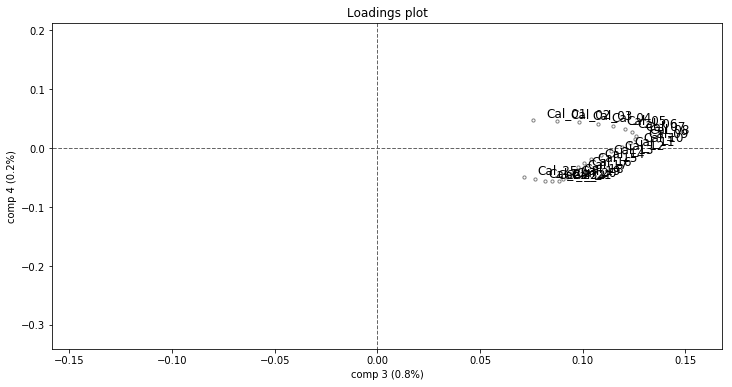

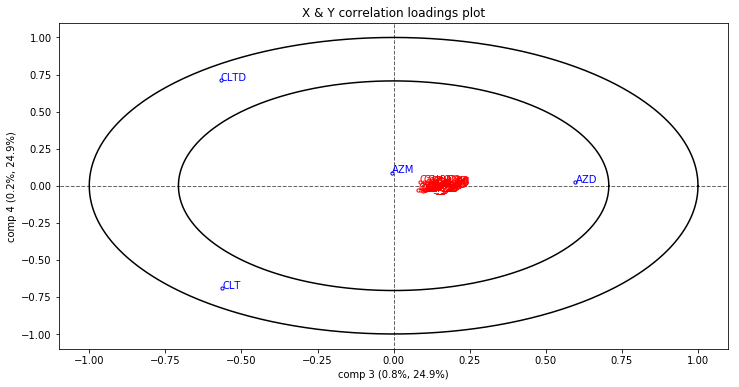

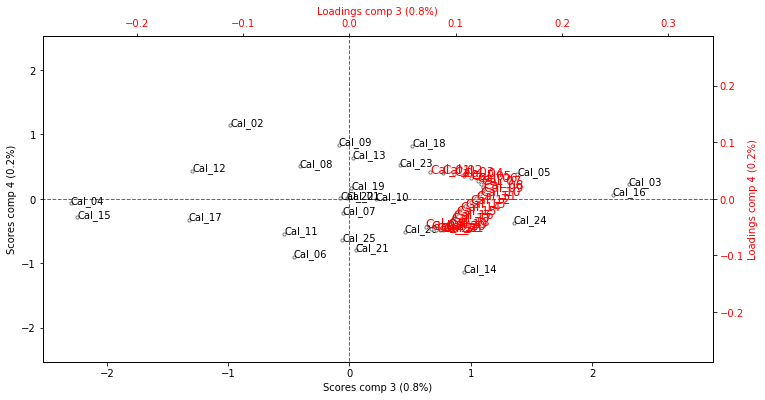

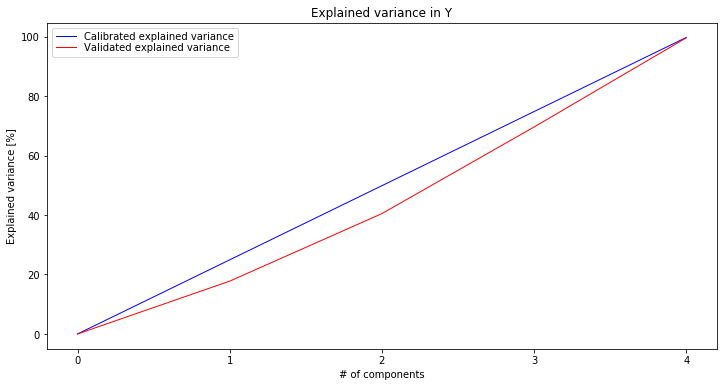

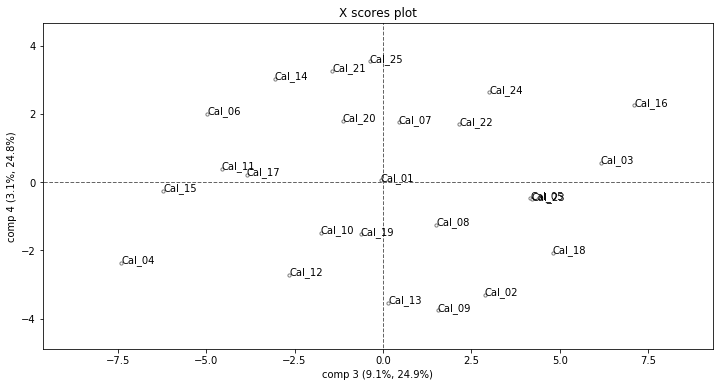

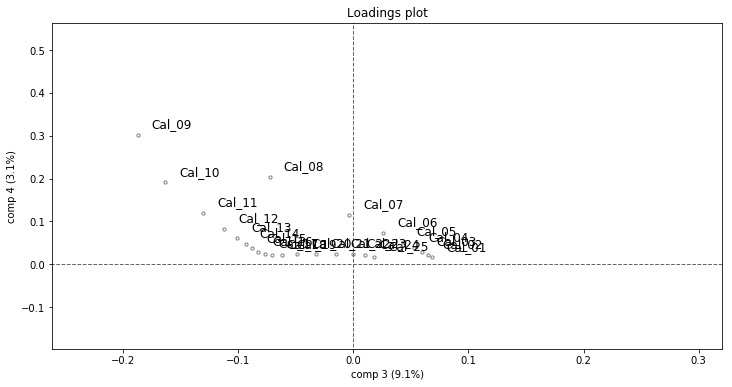

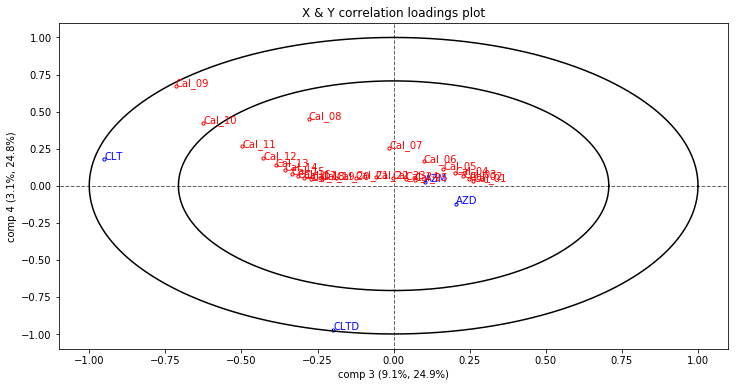

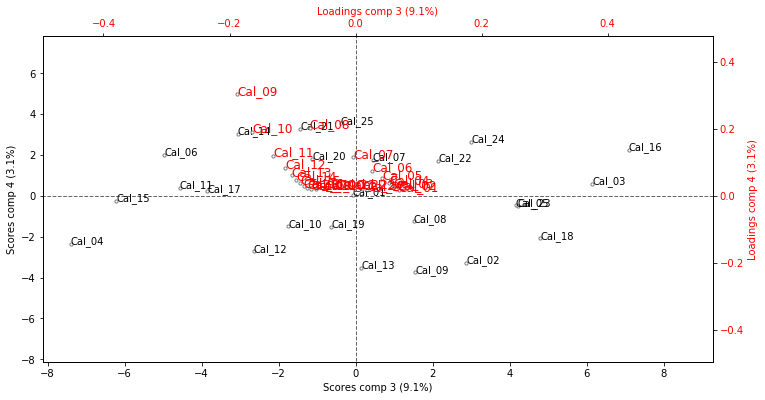

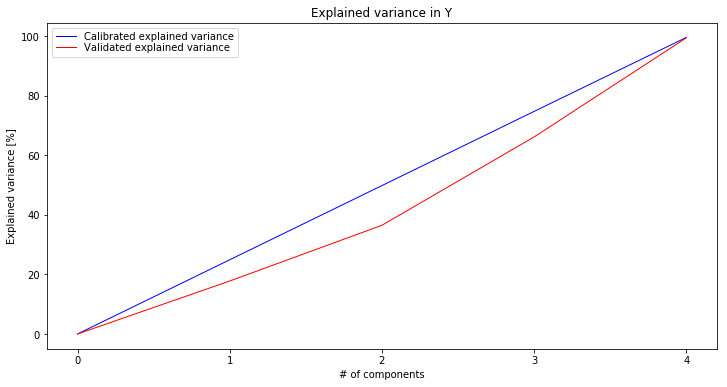

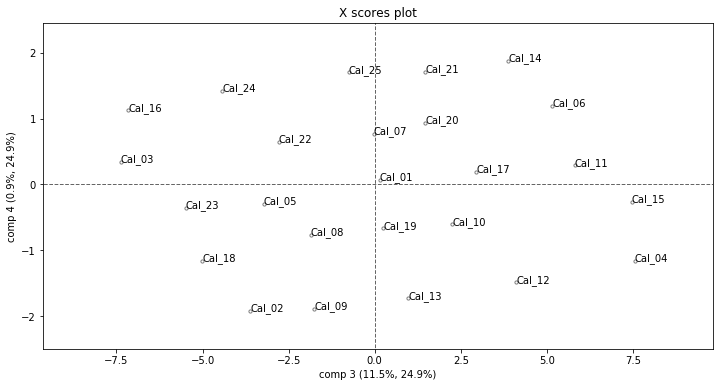

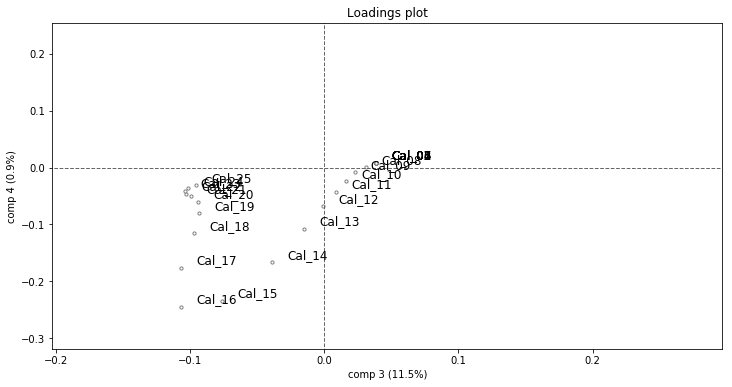

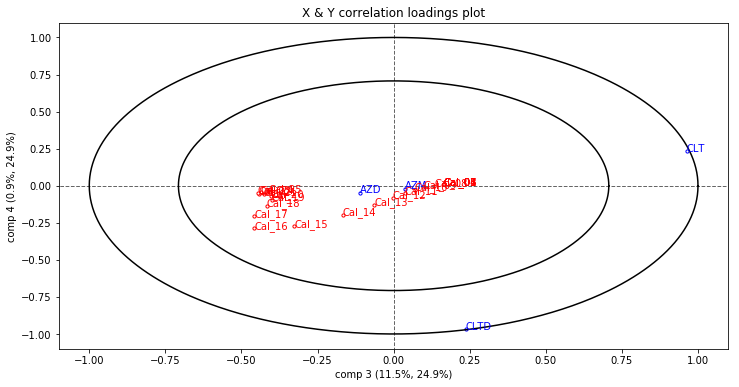

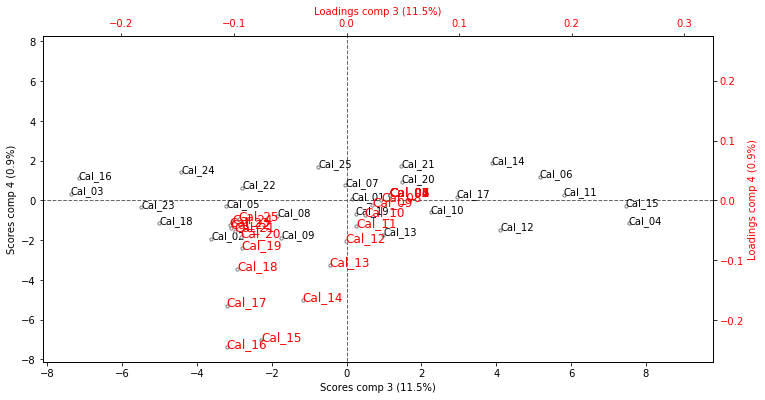

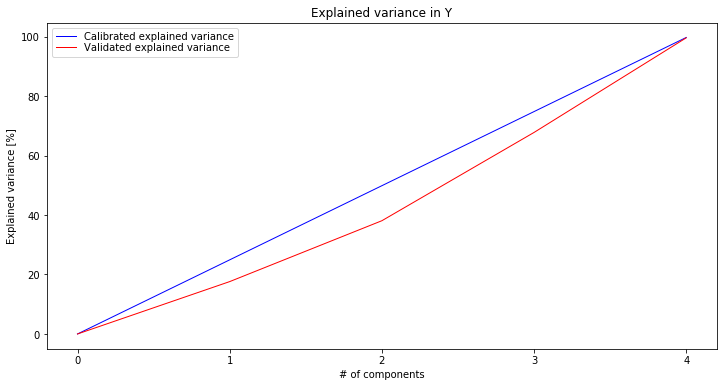

In [9]:
#Graphs of PC3 vs PC4
for i in [TotSpec_ModelD0,TotSpec_ModelD1,TotSpec_ModelD2]:
    hop.plot(i, comp=[3, 4], plots=[1,2,3,4, 6], objNames=list(Xsamples),XvarNames=list(Xsamples),YvarNames=Analytes,figsize=[12,6])

In [12]:
Y_cumCalExplVar_indTotSpec_ModelD0 = TotSpec_ModelD0.Y_cumCalExplVar_indVar()
Y_cumCalExplVar_indTotSpec_ModelD1 = TotSpec_ModelD1.Y_cumCalExplVar_indVar()
Y_cumCalExplVar_indTotSpec_ModelD2 = TotSpec_ModelD2.Y_cumCalExplVar_indVar()

Y_cumCalExplVar_df = pd.concat([pd.DataFrame(TotSpec_ModelD0.Y_cumCalExplVar_indVar()),
                                pd.DataFrame(TotSpec_ModelD1.Y_cumCalExplVar_indVar()),
                                pd.DataFrame(TotSpec_ModelD2.Y_cumCalExplVar_indVar())],axis=1)
Y_cumCalExplVar_df.columns = ['AZMD0','CLTD0','AZDD0','CLTDD0','AZMD1','CLTD1','AZDD1','CLTDD1','AZMD2','CLTD2','AZDD2','CLTDD2']
Y_cumCalExplVar_df.index = ['PC0','PC1','PC2','PC3','PC4']
Y_cumCalExplVar_df
Y_cumCalExplVar_df.to_csv(directory+ r'\Y_cumCalExplVar.csv')

In [13]:
# Get cumulative calibrated explained variance in X
X_cumCalExplVarTotSpec_ModelD0 = TotSpec_ModelD0.X_cumCalExplVar()
X_cumCalExplVarTotSpec_ModelD1 = TotSpec_ModelD1.X_cumCalExplVar()
X_cumCalExplVarTotSpec_ModelD2 = TotSpec_ModelD2.X_cumCalExplVar()

X_cumCalExplVar_df = pd.concat([pd.DataFrame(TotSpec_ModelD0.X_cumCalExplVar()),
                                pd.DataFrame(TotSpec_ModelD1.X_cumCalExplVar()),
                                pd.DataFrame(TotSpec_ModelD2.X_cumCalExplVar())],axis=1)
X_cumCalExplVar_df.columns = ['Explained variance in X (D0)','Explained variance in X (D1)','Explained variance in X (D2)']
X_cumCalExplVar_df.index = ['PC0','PC1','PC2','PC3','PC4']
X_cumCalExplVar_df
X_cumCalExplVar_df.to_csv(directory+ r'\Tot_Spec_X_cumCalExplVar.csv')

In [14]:
PredictTotSpec_ModelD0 = TotSpec_ModelD0.Y_predict(Xv, numComp=4)
PredictTotSpec_ModelD1 = TotSpec_ModelD1.Y_predict(Xv1, numComp=4)
PredictTotSpec_ModelD2 = TotSpec_ModelD2.Y_predict(Xv2, numComp=4)

PredictTotSpec_df = pd.concat([pd.DataFrame(TotSpec_ModelD0.Y_predict(Xv, numComp=4)/yv*100),
                                pd.DataFrame(TotSpec_ModelD1.Y_predict(Xv1, numComp=4)/yv*100),
                                pd.DataFrame(TotSpec_ModelD2.Y_predict(Xv2, numComp=4)/yv*100)],axis=1)
PredictTotSpec_df.columns = ['AZMD0','CLTD0','AZDD0','CLTDD0','AZMD1','CLTD1','AZDD1','CLTDD1','AZMD2','CLTD2','AZDD2','CLTDD2']
PredictTotSpec_df.index = Xvsamples
PredictTotSpec_df
PredictTotSpec_df.to_csv(directory+ r'\PredictTotSpecrecov.csv')

C:\Users\Black Knight\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Users\Black Knight\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\Black Knight\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [15]:
def PCR_variable_selection(X, y, max_comp,Analyte):
    
    np.random.seed(155)# fix random seed for reproducibility
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))

    # Loop over the number of PC components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        model1 = ho.pcr.nipalsPCR(arrX=X, Xstand=True, arrY=y, Ystand=True,cvType=["loo"], numComp=i+1)
        
        # Indices of sort spectra according to ascending absolute value of PCR coefficients
        sorted_ind = np.argsort(np.abs(model1.regressionCoefficients(i)[:,Analyte]))

        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]

        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            model2 = ho.pcr.nipalsPCR(arrX=Xc[:, j:], Xstand=True, arrY=y, Ystand=True,cvType=["loo"], numComp=i+1)
            loo = ho.cross_val.LeaveOneOut(25)
            for train_index, test_index in loo:
                X_train, X_test, y_train, y_test = cross_val.split(train_index, test_index, Xc[:, j:], y)
                #pred_Y = model2.Y_predict(X_test, numComp=i+1)
                y_cv = model2.Y_predict(Xc[:, j:], numComp=i+1)#cross_val_predict(model2, Xc[:, j:], y, cv=5)
                #np.shape(model2.Y_RMSEE())
                mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp+ " " +"Analyte_{0}".format(Analyte))
        stdout.flush()
    stdout.write("\n")

    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))

    print("Optimised number of PC components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()


    # Calculate PCR with optimal components and export values
    model = ho.pcr.nipalsPCR(arrX=X, Xstand=True, arrY=y, Ystand=True,cvType=["loo"], numComp=mseminx[0]+1)
        
    sorted_ind = np.argsort(np.abs(model.regressionCoefficients(Analyte)[:,Analyte]))

    Xc = X[:,sorted_ind]

    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [16]:
# variable selection function output for different anlytes using different order data derivative
OutputD0={}
OutputD1={}
OutputD2={}
for i in [0,1,2,3]: #iterate for all analytes
    OutputD0["Analyte_{0}".format(i)]=PCR_variable_selection(X, y, 4,i)
for i in [0,1,2,3]:#iterate for all analytes
    OutputD1["Analyte_{0}".format(i)]=PCR_variable_selection(X1, y, 4,i)
for i in [0,1]:#iterate for all analytes except ,2,3 who give singular matrix 
    OutputD2["Analyte_{0}".format(i)]=PCR_variable_selection(X2, y, 4,i)
############################################################################################################################
# Create timestamped folder and move all sav and csv files to it
# Create folder
nTime = datetime.datetime.today().strftime("%d-%m-%Y-%H-%M-%S")
direct =  "./Standazil_plus/"
directory = os.path.join( direct+nTime)
if not os.path.exists(directory):
    os.makedirs(directory)
# move files
source = os.getcwd()    
source_files = os.listdir(source)
files = sorted( [f for f in os.listdir(source)if f.endswith('.sav') or f.endswith('.csv')])
vars_  = [filename[:-4] for filename in files]
gdict = globals()
for filename, var in zip( files, vars_ ):
    source_file = os.path.join(source,filename)
    if os.path.isfile(source_file): #check if source file is a file not dir
        shutil.move(source_file,directory) #move only files (not include dir) to dest dir

loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
25% completed Analyte_0loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
l

loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
25% completed Analyte_3loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
l

loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
25% completed Analyte_2loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
l

loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
25% completed Analyte_1loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
l

In [17]:
#access results of variable selection function 
###########################################################################################################################
##Zero order based variable selection
OptX_D0=[OutputD0['Analyte_0'][0],OutputD0['Analyte_1'][0],OutputD0['Analyte_2'][0],OutputD0['Analyte_3'][0]]
Optimum_number_of_PC_D0=[OutputD0['Analyte_0'][1],OutputD0['Analyte_1'][1],OutputD0['Analyte_2'][1],OutputD0['Analyte_3'][1]]
Discarded_number_of_wl_D0=[OutputD0['Analyte_0'][2],OutputD0['Analyte_1'][2],OutputD0['Analyte_2'][2],OutputD0['Analyte_3'][2]]
Orderd_wl_D0=[OutputD0['Analyte_0'][3],OutputD0['Analyte_1'][3],OutputD0['Analyte_2'][3],OutputD0['Analyte_3'][3]]
###########################################################################################################################
##First order based variable selection
OptX_D1=[OutputD1['Analyte_0'][0],OutputD1['Analyte_1'][0],OutputD1['Analyte_2'][0],OutputD1['Analyte_3'][0]]
Optimum_number_of_PC_D1=[OutputD1['Analyte_0'][1],OutputD1['Analyte_1'][1],OutputD1['Analyte_2'][1],OutputD1['Analyte_3'][1]]
Discarded_number_of_wl_D1=[OutputD1['Analyte_0'][2],OutputD1['Analyte_1'][2],OutputD1['Analyte_2'][2],OutputD1['Analyte_3'][2]]
Orderd_wl_D1=[OutputD1['Analyte_0'][3],OutputD1['Analyte_1'][3],OutputD1['Analyte_2'][3],OutputD1['Analyte_3'][3]]
###########################################################################################################################
##Second order based variable selection
OptX_D2=[OutputD2['Analyte_0'][0],OutputD2['Analyte_1'][0]]#,OutputD2['Analyte_2'][0],OutputD2['Analyte_3'][0]]
Optimum_number_of_PC_D2=[OutputD2['Analyte_0'][1],OutputD2['Analyte_1'][1]]#,OutputD2['Analyte_2'][1],OutputD2['Analyte_3'][1]]
Discarded_number_of_wl_D2=[OutputD2['Analyte_0'][2],OutputD2['Analyte_1'][2]]#,OutputD2['Analyte_2'][2],OutputD2['Analyte_3'][2]]
Orderd_wl_D2=[OutputD2['Analyte_0'][3],OutputD2['Analyte_1'][3]]#,OutputD2['Analyte_2'][3],OutputD2['Analyte_3'][3]]

Number_of_Discarded_wl=pd.concat([pd.DataFrame(Discarded_number_of_wl_D0),pd.DataFrame(Discarded_number_of_wl_D1),
                                  pd.DataFrame(Discarded_number_of_wl_D2)],axis=1)
Number_of_Discarded_wl.columns=['Zero Order','First Drivative','Second Drivative']
Number_of_Discarded_wl.index=Analytes
Number_of_Discarded_wl.to_csv(directory+ r'\Number_of_Discarded_wl.csv')
#Number_of_Discarded_wl.to_csv(r'C:\Python\Standazil_plus\PLSR_Results\Number_of_Discarded_wl.csv')

Optimum_number_of_PC=pd.concat([pd.DataFrame(Optimum_number_of_PC_D0),pd.DataFrame(Optimum_number_of_PC_D1),pd.DataFrame(Optimum_number_of_PC_D2)],axis=1)
Optimum_number_of_PC.columns=['Zero Order','First Drivative','Second Drivative']
Optimum_number_of_PC.index=Analytes
Optimum_number_of_PC.to_csv(directory+ r'\Optimum_number_of_PC.csv')

#Best wavelength subset (bwlss) according to specific analyte regression coefficients "used for variable selection"
###########################################################################################################################
bwlss_AZM_D0=[190+OutputD0['Analyte_0'][3][OutputD0['Analyte_0'][2]:]]# [190+OutputD0['model_0'][3] means OutputD0['model_0']--> list[3]--> element in list +190
bwlss_AZM_D1=[190+OutputD1['Analyte_0'][3][OutputD1['Analyte_0'][2]:]]#OutputD0['model_0'][2]: means from this location to the end
bwlss_AZM_D2=[190+OutputD2['Analyte_0'][3][OutputD2['Analyte_0'][2]:]]
bwlss_AZM=[bwlss_AZM_D0,bwlss_AZM_D1,bwlss_AZM_D2]
###########################################################################################################################
bwlss_CLT_D0=[190+OutputD0['Analyte_1'][3][OutputD0['Analyte_1'][2]:]]
bwlss_CLT_D1=[190+OutputD1['Analyte_1'][3][OutputD1['Analyte_1'][2]:]]
bwlss_CLT_D2=[190+OutputD2['Analyte_1'][3][OutputD2['Analyte_1'][2]:]]
bwlss_CLT=[bwlss_CLT_D0,bwlss_CLT_D1,bwlss_CLT_D2]
###########################################################################################################################
bwlss_AZD_D0=[190+OutputD0['Analyte_2'][3][OutputD0['Analyte_2'][2]:]]
bwlss_AZD_D1=[190+OutputD1['Analyte_2'][3][OutputD1['Analyte_2'][2]:]]
#bwlss_AZD_D2=[190+OutputD2['Analyte_2'][3][OutputD2['Analyte_2'][2]:]]# singular matrix
bwlss_AZD=[bwlss_AZD_D0,bwlss_AZD_D1]#,bwlss_AZD_D2]
###########################################################################################################################
bwlss_CLTD_D0=[190+OutputD0['Analyte_3'][3][OutputD0['Analyte_3'][2]:]]
bwlss_CLTD_D1=[190+OutputD1['Analyte_3'][3][OutputD1['Analyte_3'][2]:]]
#bwlss_CLTD_D2=[190+OutputD2['Analyte_3'][3][OutputD2['Analyte_3'][2]:]]# singular matrix
bwlss_CLTD=[bwlss_CLTD_D0,bwlss_CLTD_D1]#,bwlss_CLTD_D2]
###########################################################################################################################
bwlss=[bwlss_AZM_D0[0],bwlss_CLT_D0[0],bwlss_AZD_D0[0],bwlss_CLTD_D0[0],bwlss_AZM_D1[0],bwlss_CLT_D1[0],
       bwlss_AZD_D1[0],bwlss_CLTD_D1[0],bwlss_AZM_D2[0],bwlss_CLT_D2[0]]#,bwlss_AZD_D2[0],bwlss_CLTD_D2[0]]
# Spectra with selected wavlengths according to specific analyte regression coefficients "used for variable selection"
###########################################################################################################################
X_AZM_D0=OutputD0['Analyte_0'][0]# [190+OutputD0['model_0'][3] means OutputD0['model_0']--> list[3]--> element in list +190
X_AZM_D1=OutputD1['Analyte_0'][0]
X_AZM_D2=OutputD2['Analyte_0'][0]
X_AZM=[X_AZM_D0,X_AZM_D1,X_AZM_D2]
###########################################################################################################################
X_CLT_D0=OutputD0['Analyte_1'][0]
X_CLT_D1=OutputD1['Analyte_1'][0]
X_CLT_D2=OutputD2['Analyte_1'][0]
X_CLT=[X_CLT_D0,X_CLT_D1,X_CLT_D2]
###########################################################################################################################
X_AZD_D0=OutputD0['Analyte_2'][0]
X_AZD_D1=OutputD1['Analyte_2'][0]
#X_AZD_D2=OutputD2['Analyte_2'][0]
x_AZD=[X_AZD_D0,X_AZD_D1]#,X_AZD_D2]
###########################################################################################################################
X_CLTD_D0=OutputD0['Analyte_3'][0]
X_CLTD_D1=OutputD1['Analyte_3'][0]
#X_CLTD_D2=OutputD2['Analyte_3'][0]
X_CLTD=[X_CLTD_D0,X_CLTD_D1]#,X_CLTD_D2]
###########################################################################################################################
#Saving Calibration BSWLSS Data to csv
X_AZM_D0_df,X_AZM_D0_df.columns,X_AZM_D0_df.index=pd.DataFrame(X_AZM_D0),bwlss_AZM_D0,Xsamples
X_AZM_D0_df.to_csv(directory+ r'\X_AZM_D0.csv')
X_CLT_D0_df,X_CLT_D0_df.columns,X_CLT_D0_df.index=pd.DataFrame(X_CLT_D0),bwlss_CLT_D0,Xsamples
X_CLT_D0_df.to_csv(directory+ r'\X_CLT_D0.csv')
X_AZD_D0_df,X_AZD_D0_df.columns,X_AZD_D0_df.index=pd.DataFrame(X_AZD_D0),bwlss_AZD_D0,Xsamples
X_AZD_D0_df.to_csv(directory+ r'\X_AZD_D0.csv')
X_CLTD_D0_df,X_CLTD_D0_df.columns,X_CLTD_D0_df.index=pd.DataFrame(X_CLTD_D0),bwlss_CLTD_D0,Xsamples
X_CLTD_D0_df.to_csv(directory+ r'\X_CLTD_D0.csv')

X_AZM_D1_df,X_AZM_D1_df.columns,X_AZM_D1_df.index=pd.DataFrame(X_AZM_D1),bwlss_AZM_D1,Xsamples
X_AZM_D1_df.to_csv(directory+ r'\X_AZM_D1.csv')
X_CLT_D1_df,X_CLT_D1_df.columns,X_CLT_D1_df.index=pd.DataFrame(X_CLT_D1),bwlss_CLT_D1,Xsamples
X_CLT_D1_df.to_csv(directory+ r'\X_CLT_D1.csv')
X_AZD_D1_df,X_AZD_D1_df.columns,X_AZD_D1_df.index=pd.DataFrame(X_AZD_D1),bwlss_AZD_D1,Xsamples
X_AZD_D1_df.to_csv(directory+ r'\X_AZD_D1.csv')
X_CLTD_D1_df,X_CLTD_D1_df.columns,X_CLTD_D1_df.index=pd.DataFrame(X_CLTD_D1),bwlss_CLTD_D1,Xsamples
X_CLTD_D1_df.to_csv(directory+ r'\X_CLTD_D1.csv')

X_AZM_D2_df,X_AZM_D2_df.columns,X_AZM_D2_df.index=pd.DataFrame(X_AZM_D2),bwlss_AZM_D2,Xsamples
X_AZM_D2_df.to_csv(directory+ r'\X_AZM_D2.csv')
X_CLT_D2_df,X_CLT_D2_df.columns,X_CLT_D2_df.index=pd.DataFrame(X_CLT_D2),bwlss_CLT_D2,Xsamples
X_CLT_D2_df.to_csv(directory+ r'\X_CLT_D2.csv')

In [18]:
# Build models using different optimum selected variables as Model_0 to Model_11
for i, value in enumerate([OptX_D0[0],OptX_D0[1],OptX_D0[2],OptX_D0[3],OptX_D1[0],OptX_D1[1],OptX_D1[2],OptX_D1[3],
       OptX_D2[0],OptX_D2[1]]):#,OptX_D2[2],OptX_D2[3]
    exec ("Model_%s=ho.plsr2.nipalsPLS2(arrX=value, Xstand=True, arrY=y,Ystand=True,cvType=['loo'], numComp=5)" % (i))
Models=['AZM_D0','CLT_D0','AZD_D0','CLTD_D0','AZM_D1','CLT_D1','AZD_D1','CLTD_D1','AZM_D2','CLT_D2']#,'AZD_D2','CLTD_D2']

loo
loo
loo
loo
loo
loo
loo
loo
loo
loo


In [19]:
#Validation matrix with selected wavelengths
Xv_AZM_D0=Xv[:,OutputD0['Analyte_0'][3][OutputD0['Analyte_0'][2]:]] # select only the best selected variables 
Xv_CLT_D0=Xv[:,OutputD0['Analyte_1'][3][OutputD0['Analyte_1'][2]:]]
Xv_AZD_D0=Xv[:,OutputD0['Analyte_2'][3][OutputD0['Analyte_2'][2]:]]
Xv_CLTD_D0=Xv[:,OutputD0['Analyte_3'][3][OutputD0['Analyte_3'][2]:]]
############################################################################
Xv_AZM_D1=Xv1[:,OutputD1['Analyte_0'][3][OutputD1['Analyte_0'][2]:]]
Xv_CLT_D1=Xv1[:,OutputD1['Analyte_1'][3][OutputD1['Analyte_1'][2]:]]
Xv_AZD_D1=Xv1[:,OutputD1['Analyte_2'][3][OutputD1['Analyte_2'][2]:]]
Xv_CLTD_D1=Xv1[:,OutputD1['Analyte_3'][3][OutputD1['Analyte_3'][2]:]]
############################################################################
Xv_AZM_D2=Xv2[:,OutputD2['Analyte_0'][3][OutputD2['Analyte_0'][2]:]]
Xv_CLT_D2=Xv2[:,OutputD2['Analyte_1'][3][OutputD2['Analyte_1'][2]:]]
#Xv_AZD_D2=Xv2[:,OutputD2['Analyte_2'][3][OutputD2['Analyte_2'][2]:]]
#Xv_CLTD_D2=Xv2[:,OutputD2['Analyte_3'][3][OutputD2['Analyte_3'][2]:]]

#Saving validation BSWLSS Data to csv
Xv_AZM_D0_df,Xv_AZM_D0_df.columns,Xv_AZM_D0_df.index=pd.DataFrame(Xv_AZM_D0),bwlss_AZM_D0,Xvsamples
Xv_AZM_D0_df.to_csv(directory+ r'\Xv_AZM_D0.csv')
Xv_CLT_D0_df,Xv_CLT_D0_df.columns,Xv_CLT_D0_df.index=pd.DataFrame(Xv_CLT_D0),bwlss_CLT_D0,Xvsamples
Xv_CLT_D0_df.to_csv(directory+ r'\Xv_CLT_D0.csv')
Xv_AZD_D0_df,Xv_AZD_D0_df.columns,Xv_AZD_D0_df.index=pd.DataFrame(Xv_AZD_D0),bwlss_AZD_D0,Xvsamples
Xv_AZD_D0_df.to_csv(directory+ r'\Xv_AZD_D0.csv')
Xv_CLTD_D0_df,Xv_CLTD_D0_df.columns,Xv_CLTD_D0_df.index=pd.DataFrame(Xv_CLTD_D0),bwlss_CLTD_D0,Xvsamples
Xv_CLTD_D0_df.to_csv(directory+ r'\Xv_CLTD_D0.csv')

Xv_AZM_D1_df,Xv_AZM_D1_df.columns,Xv_AZM_D1_df.index=pd.DataFrame(Xv_AZM_D1),bwlss_AZM_D1,Xvsamples
Xv_AZM_D1_df.to_csv(directory+ r'\Xv_AZM_D1.csv')
Xv_CLT_D1_df,Xv_CLT_D1_df.columns,Xv_CLT_D1_df.index=pd.DataFrame(Xv_CLT_D1),bwlss_CLT_D1,Xvsamples
Xv_CLT_D1_df.to_csv(directory+ r'\Xv_CLT_D1.csv')
Xv_AZD_D1_df,Xv_AZD_D1_df.columns,Xv_AZD_D1_df.index=pd.DataFrame(Xv_AZD_D1),bwlss_AZD_D1,Xvsamples
Xv_AZD_D1_df.to_csv(directory+ r'\Xv_AZD_D1.csv')
Xv_CLTD_D1_df,Xv_CLTD_D1_df.columns,Xv_CLTD_D1_df.index=pd.DataFrame(Xv_CLTD_D1),bwlss_CLTD_D1,Xvsamples
Xv_CLTD_D1_df.to_csv(directory+ r'\Xv_CLTD_D1.csv')

Xv_AZM_D2_df,Xv_AZM_D2_df.columns,Xv_AZM_D2_df.index=pd.DataFrame(Xv_AZM_D2),bwlss_AZM_D2,Xvsamples
Xv_AZM_D2_df.to_csv(directory+ r'\Xv_AZM_D2.csv')
Xv_CLT_D2_df,Xv_CLT_D2_df.columns,Xv_CLT_D2_df.index=pd.DataFrame(Xv_CLT_D2),bwlss_CLT_D2,Xvsamples
Xv_CLT_D2_df.to_csv(directory+ r'\Xv_CLT_D2.csv')
#Xv_AZD_D2_df,Xv_AZD_D2_df.columns,Xv_AZD_D2_df.index=pd.DataFrame(Xv_AZD_D2),bwlss_AZD_D2,Xvsamples
#Xv_AZD_D2_df.to_csv(directory+ r'\Xv_AZD_D2.csv')
#Xv_CLTD_D2_df,Xv_CLTD_D2_df.columns,Xv_CLTD_D2_df.index=pd.DataFrame(Xv_CLTD_D2),bwlss_CLTD_D2,Xvsamples
#Xv_CLTD_D2_df.to_csv(directory+ r'\Xv_CLTD_D2.csv')


Validation_Matext=[(Model_0,Xv_AZM_D0),(Model_1,Xv_CLT_D0),(Model_2,Xv_AZD_D0),(Model_3,Xv_CLTD_D0),
                (Model_4,Xv_AZM_D1),(Model_5,Xv_CLT_D1),(Model_6,Xv_AZD_D1),(Model_7,Xv_CLTD_D1),
                (Model_8,Xv_AZM_D2),(Model_9,Xv_CLT_D2)]#,(Model_10,Xv_AZD_D2),(Model_11,Xv_CLTD_D2)]
Validation_Mattra=[(Model_0,X_AZM_D0),(Model_1,X_CLT_D0),(Model_2,X_AZD_D0),(Model_3,X_CLTD_D0),
                (Model_4,X_AZM_D1),(Model_5,X_CLT_D1),(Model_6,X_AZD_D1),(Model_7,X_CLTD_D1),
                (Model_8,X_AZM_D2),(Model_9,X_CLT_D2)]#,(Model_10,X_AZD_D2),(Model_11,X_CLTD_D2)]

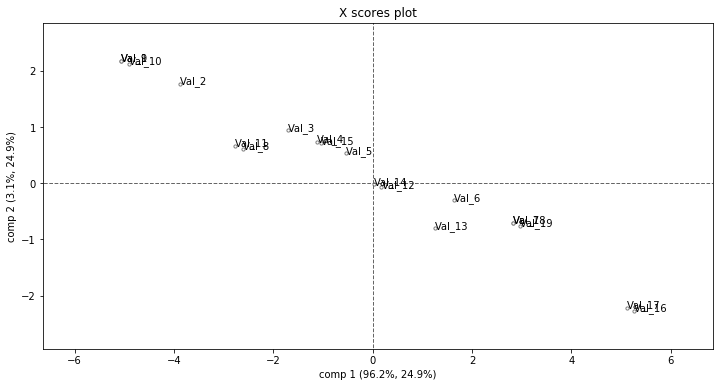

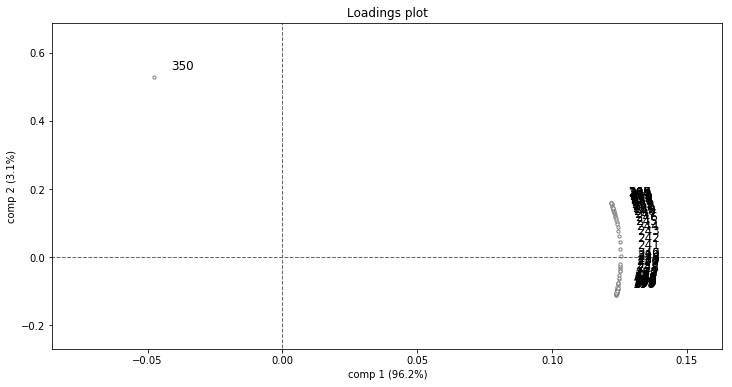

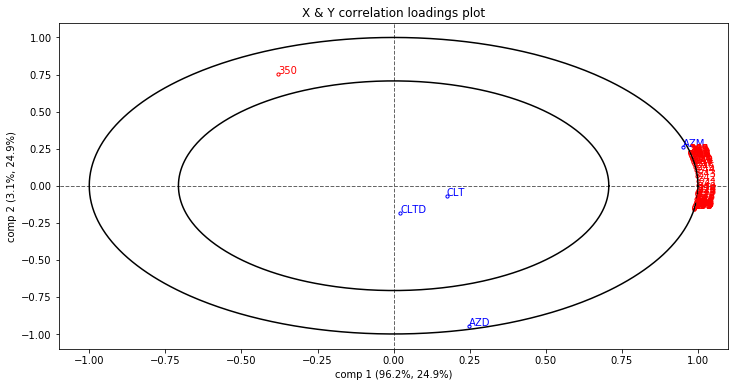

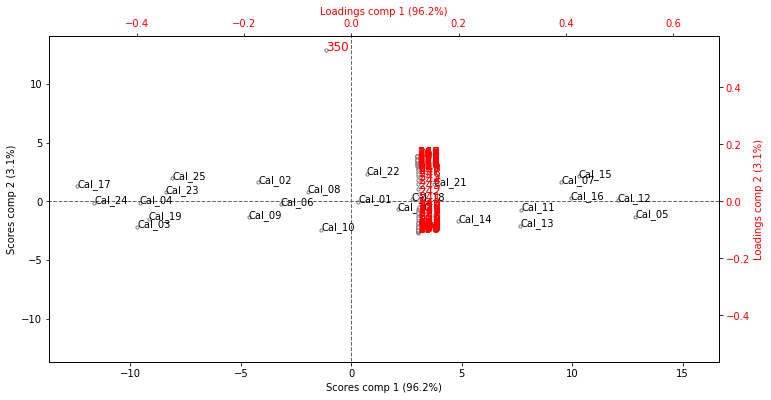

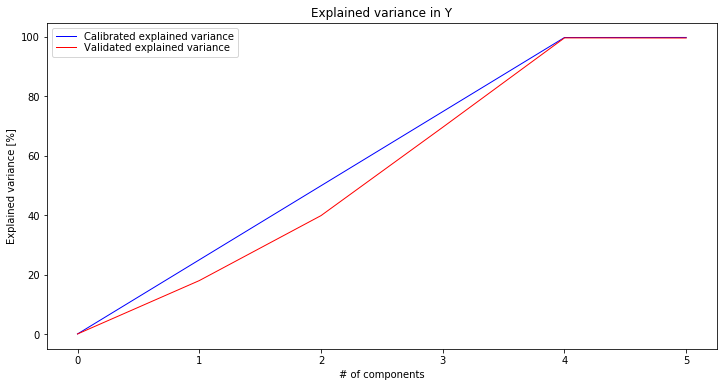

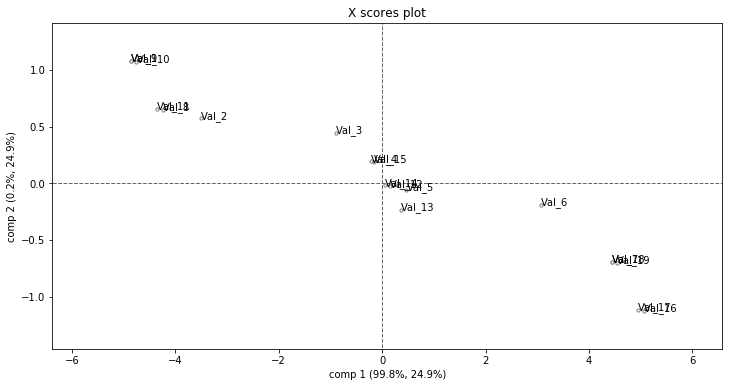

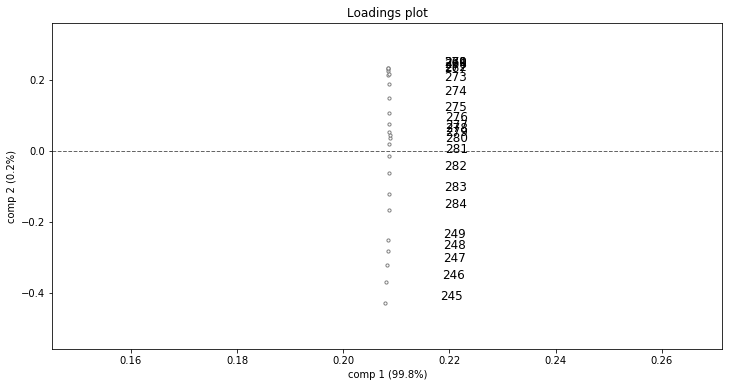

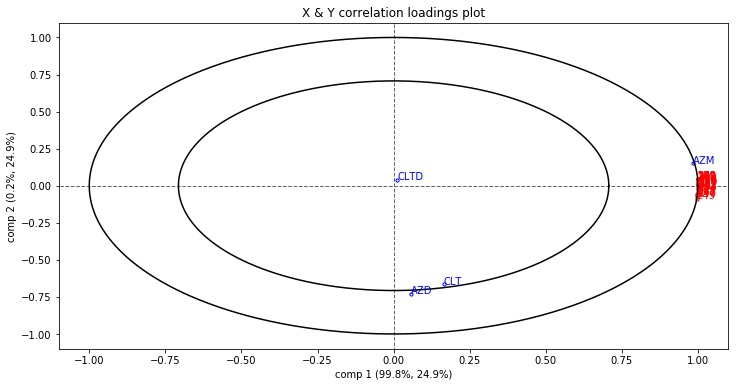

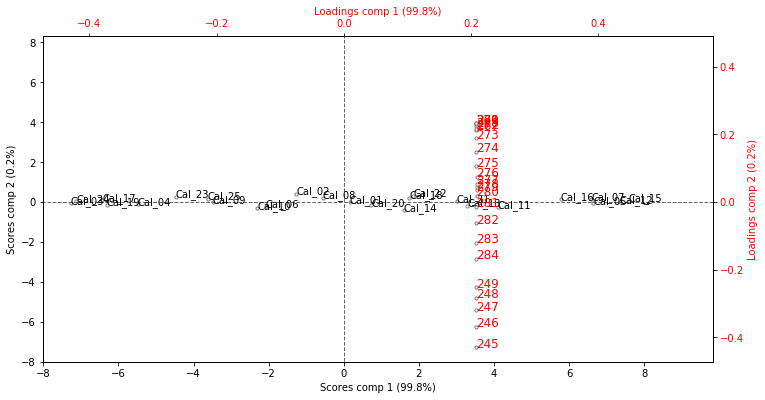

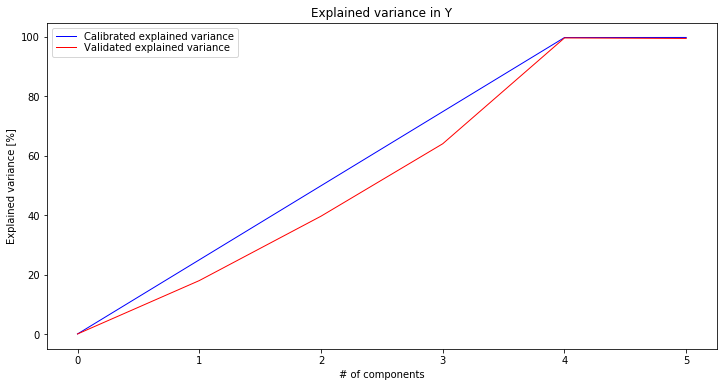

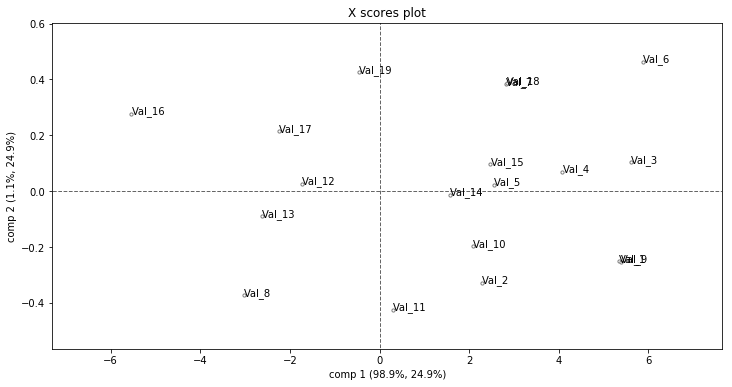

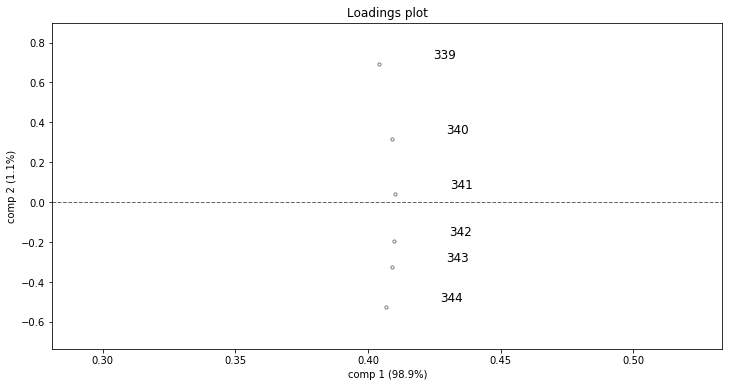

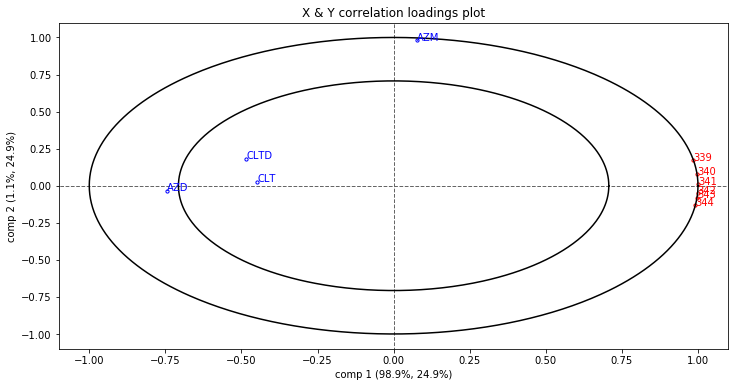

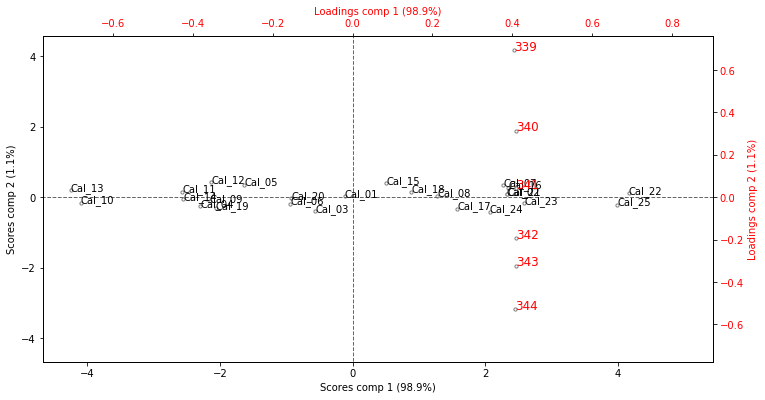

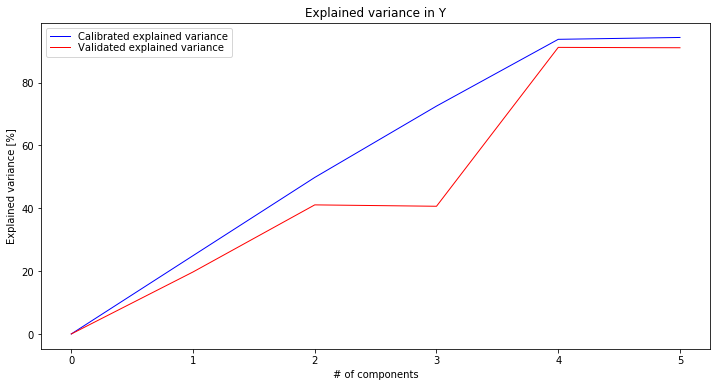

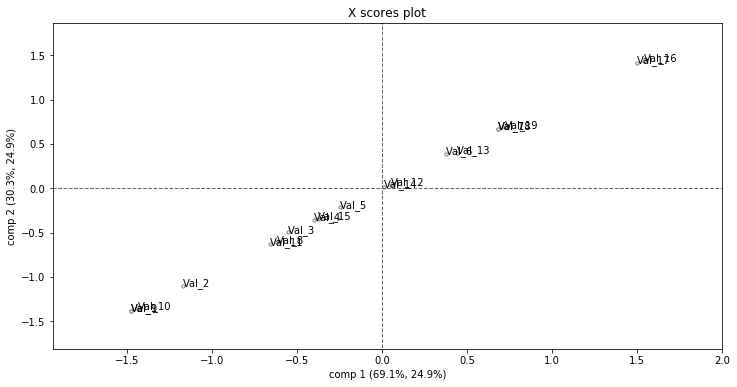

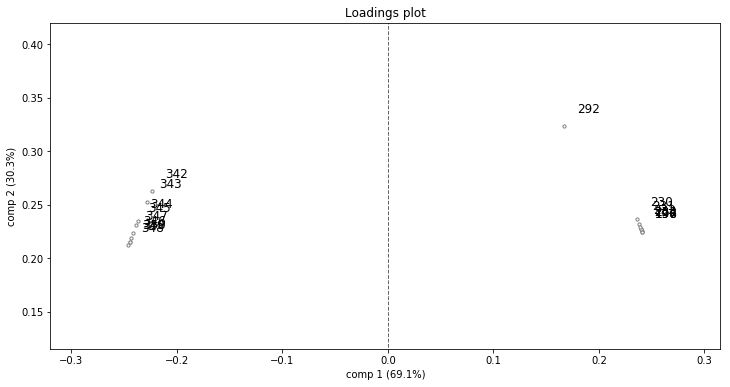

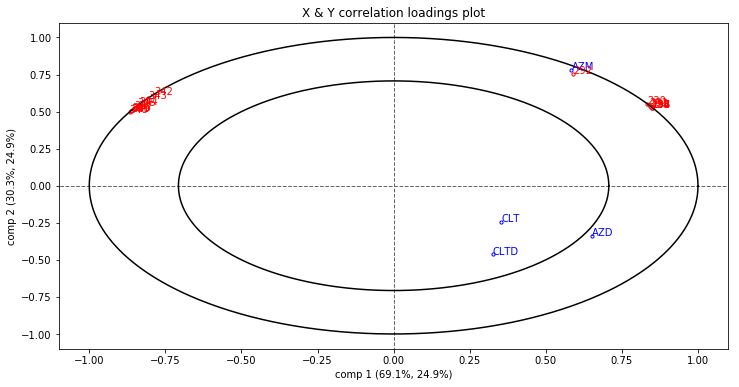

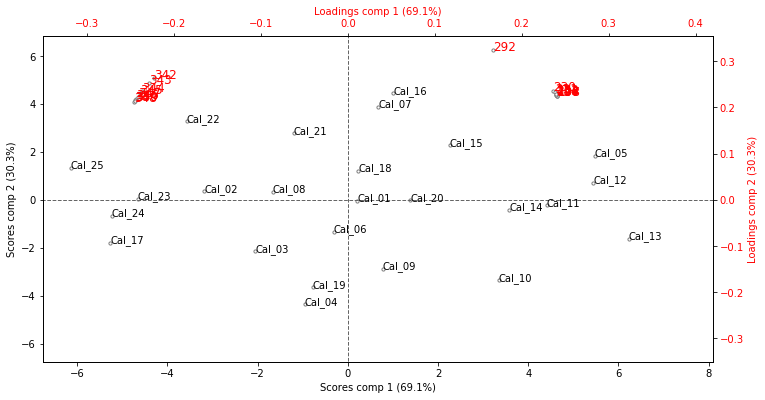

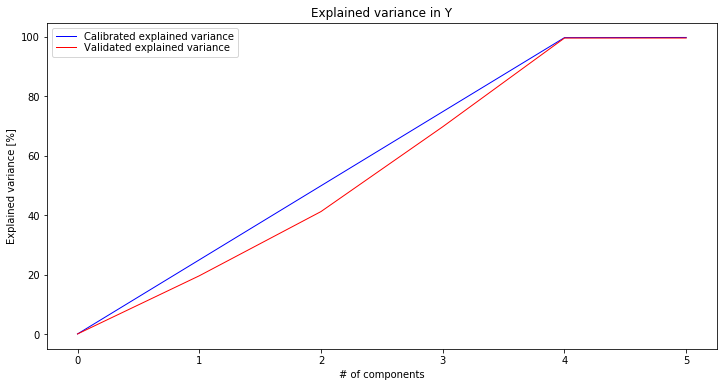

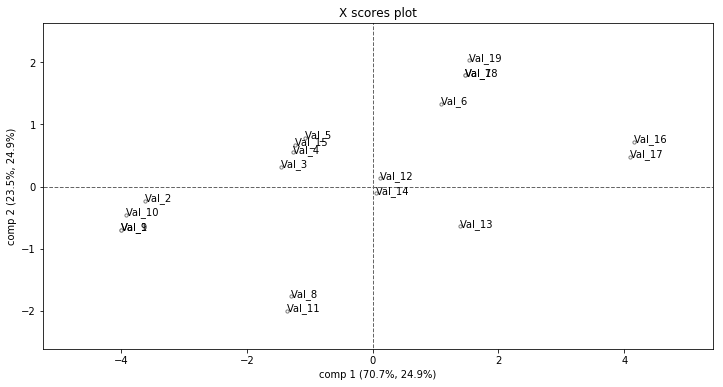

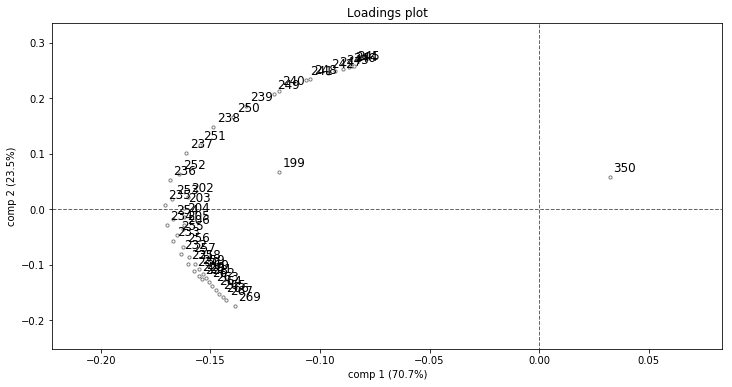

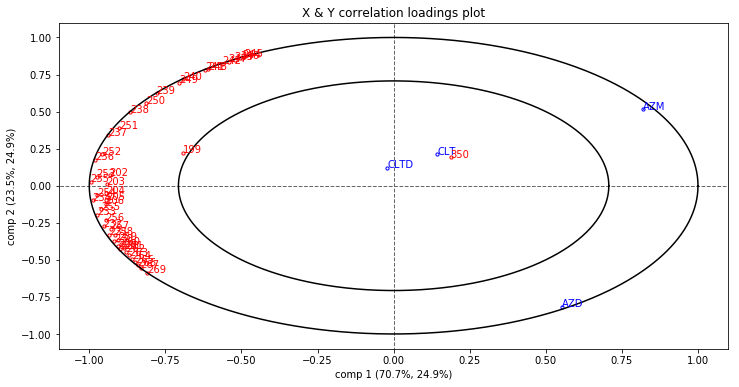

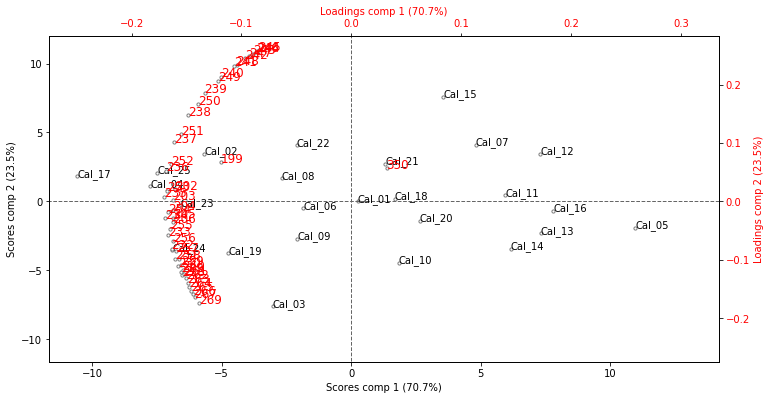

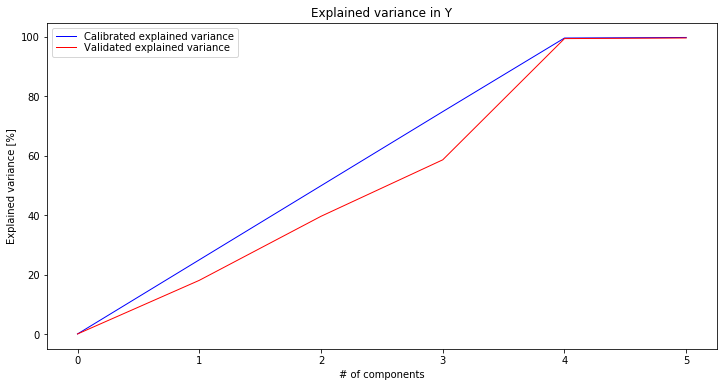

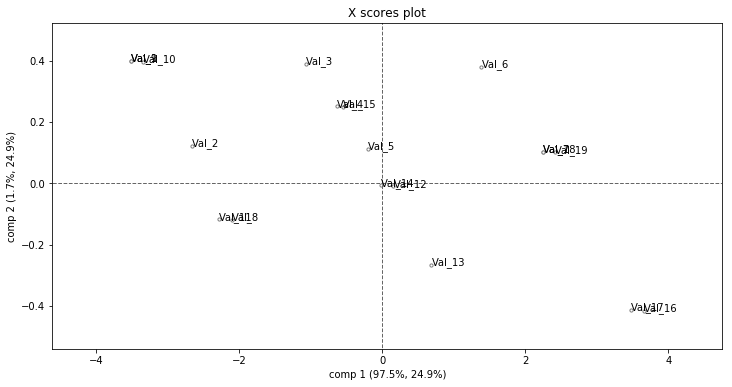

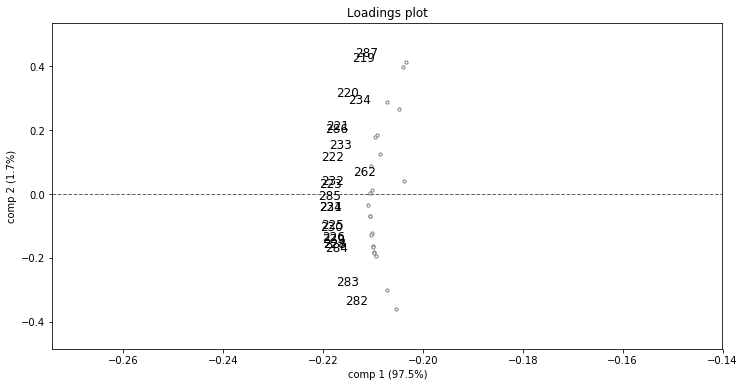

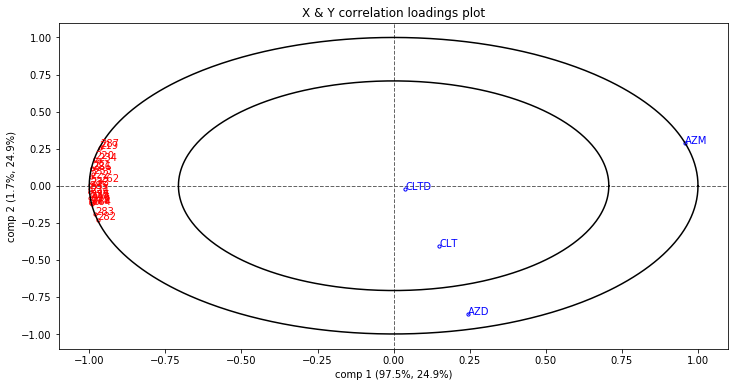

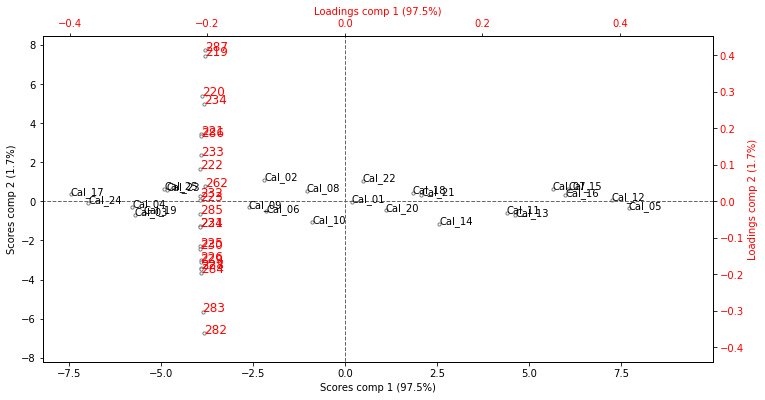

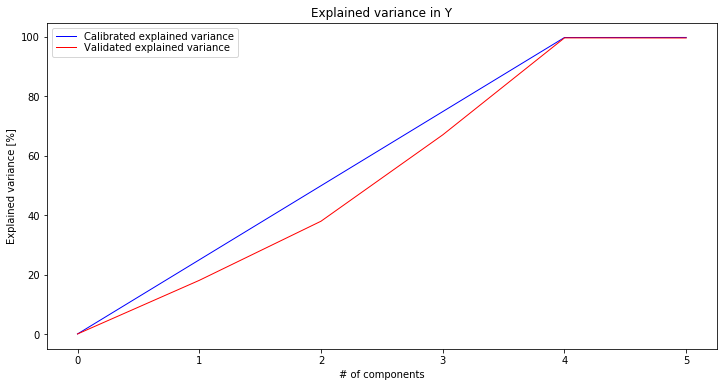

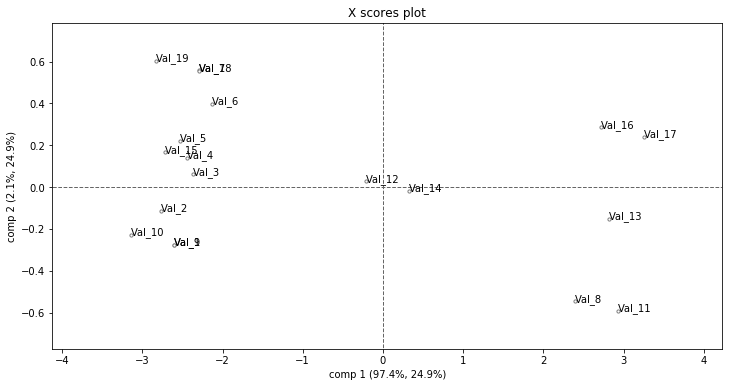

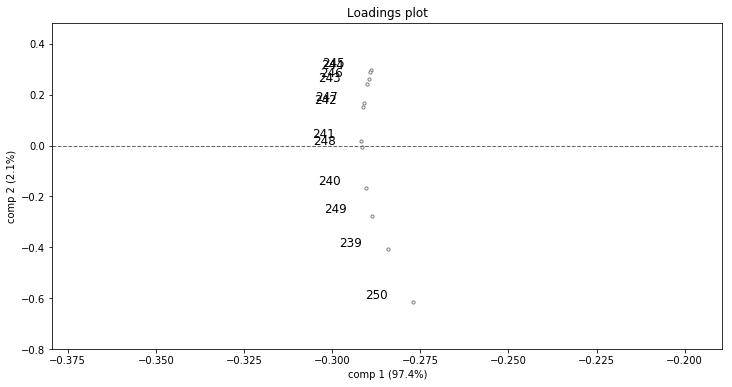

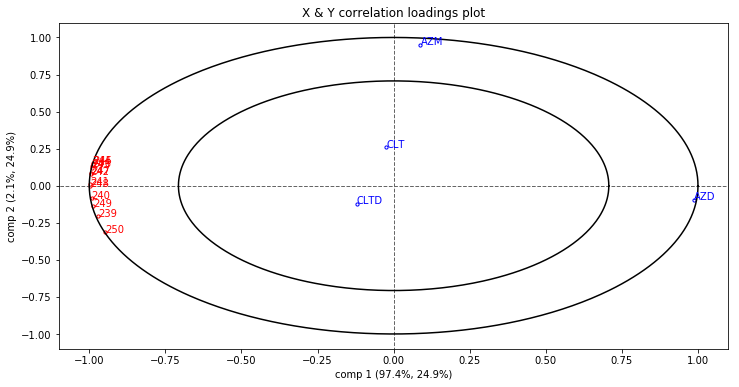

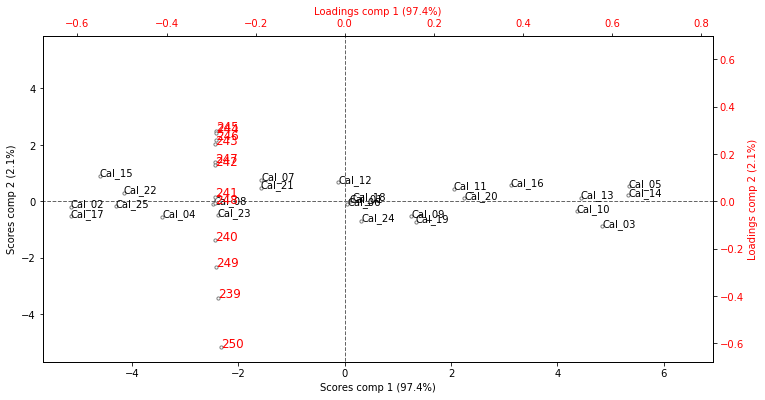

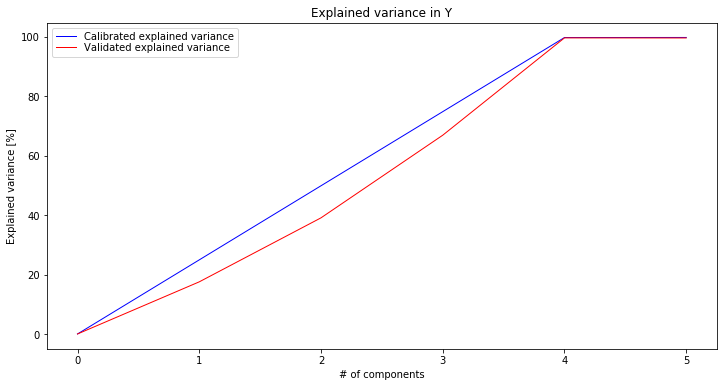

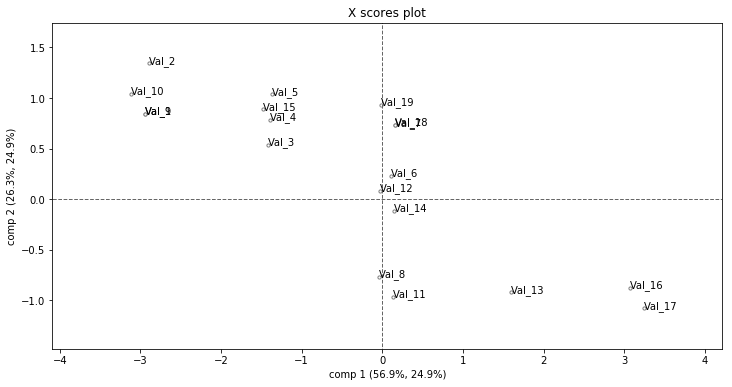

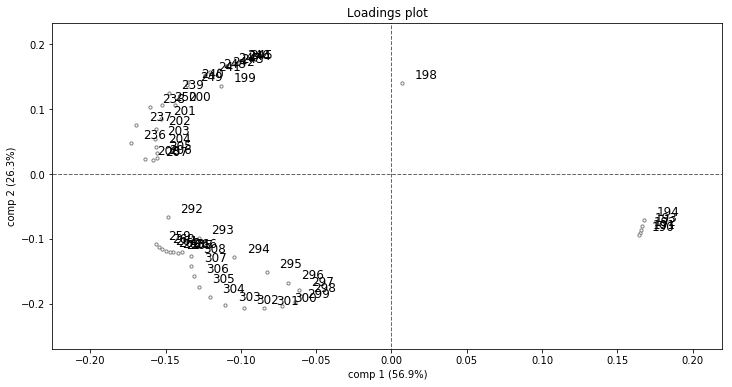

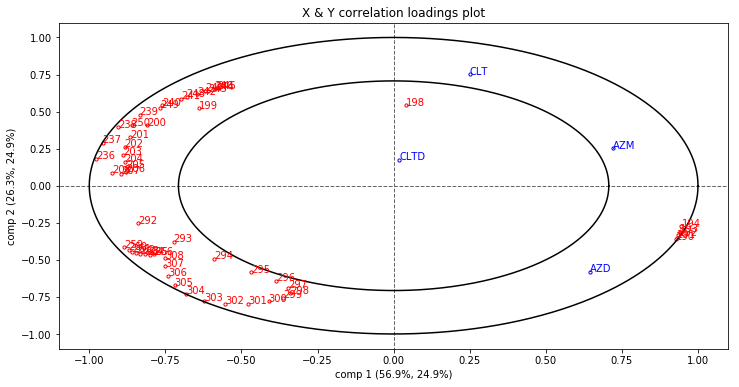

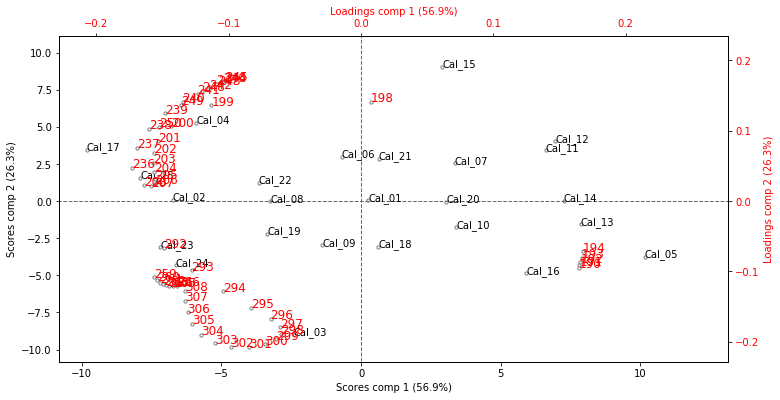

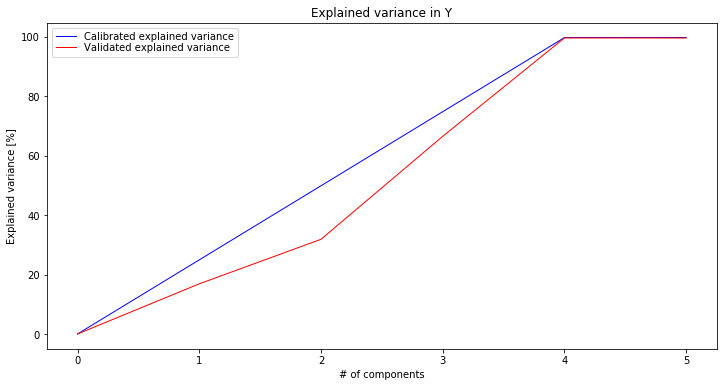

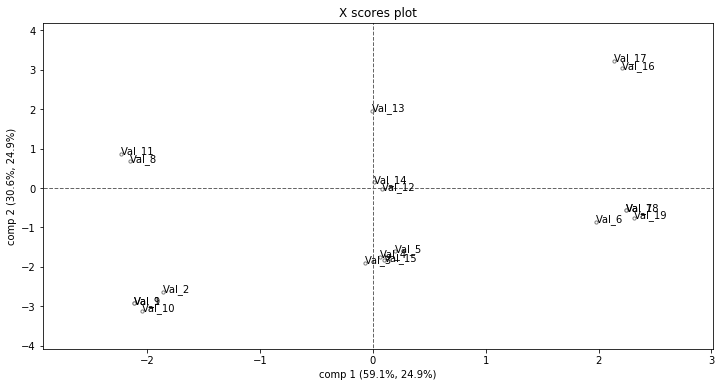

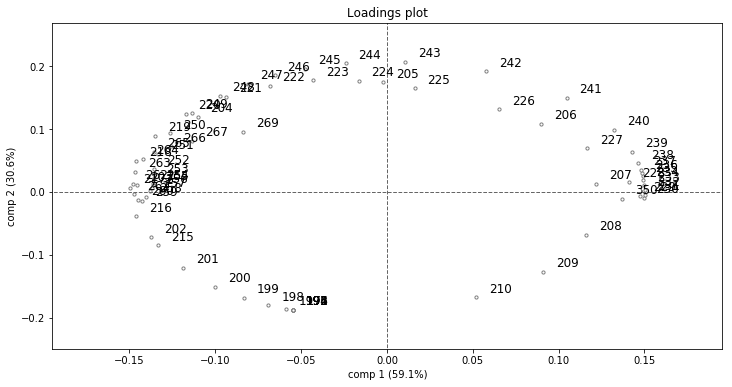

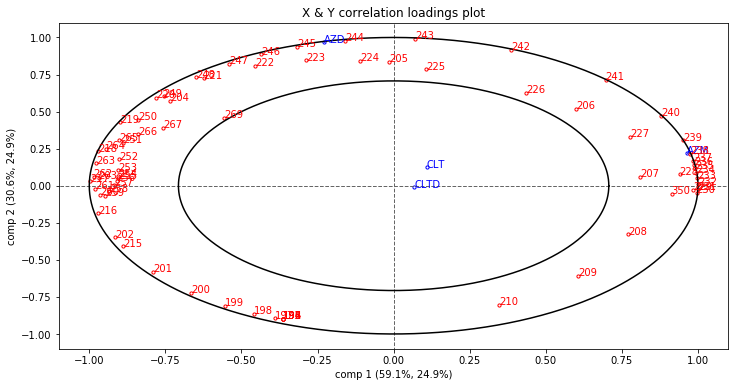

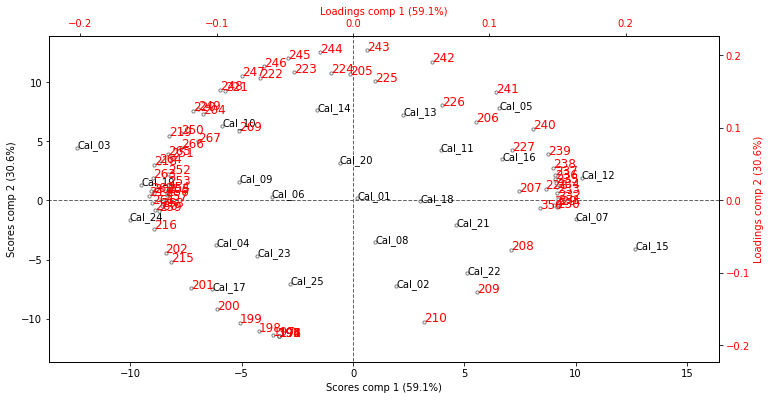

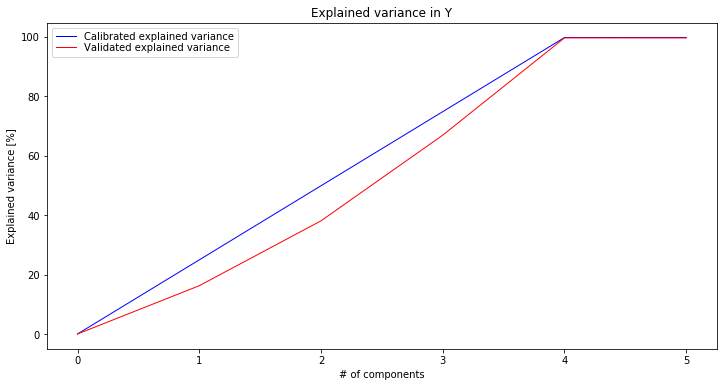

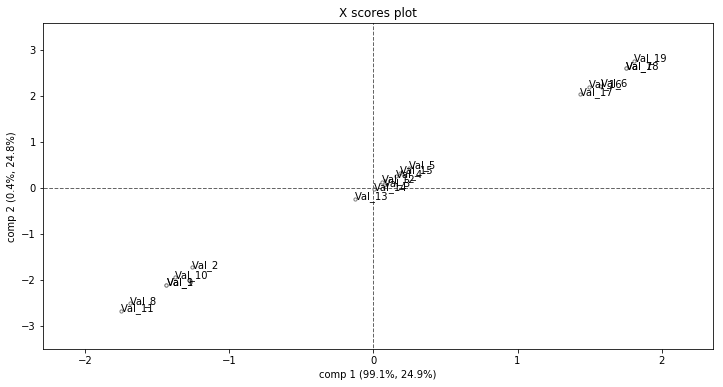

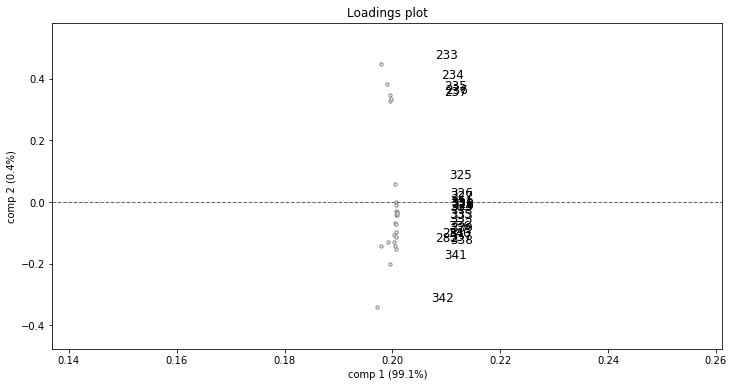

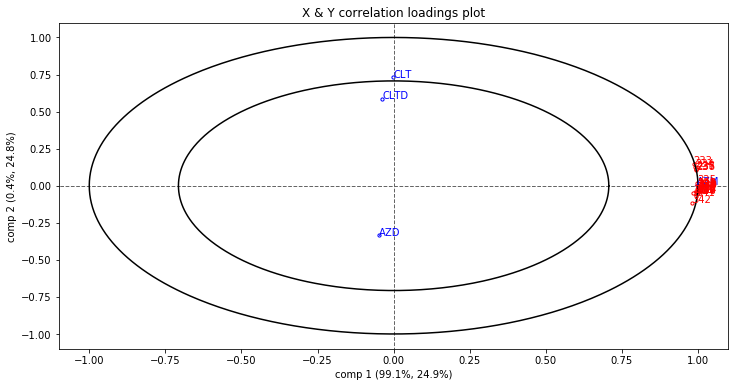

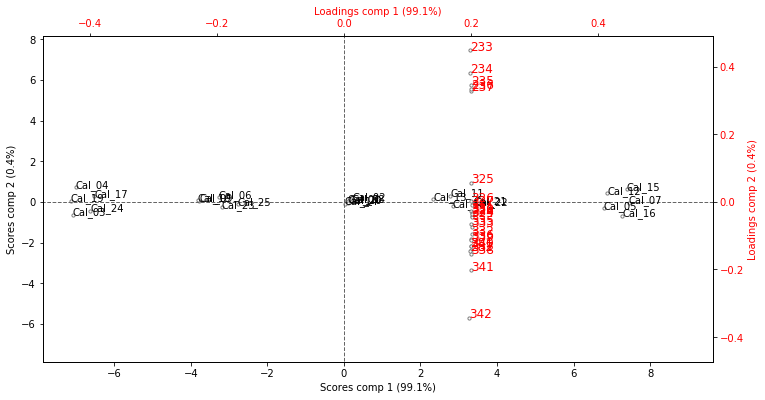

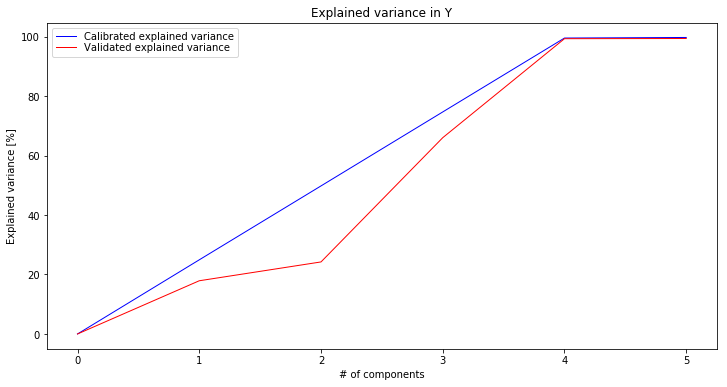

In [20]:
# Graphs of PC1 vs PC2 with validation samples
for i,j,k in zip([Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9]#,Model_10,Model_11]
               ,[bwlss_AZM_D0[0],bwlss_CLT_D0[0],bwlss_AZD_D0[0],bwlss_CLTD_D0[0],
                bwlss_AZM_D1[0],bwlss_CLT_D1[0],bwlss_AZD_D1[0],bwlss_CLTD_D1[0],
                bwlss_AZM_D2[0],bwlss_CLT_D2[0]],[Xv_AZM_D0,Xv_CLT_D0,Xv_AZD_D0,
                                                  Xv_CLTD_D0,Xv_AZM_D1,Xv_CLT_D1,Xv_AZD_D1,
                                                  Xv_CLTD_D1,Xv_AZM_D2,Xv_CLT_D2]):#,bwlss_AZD_D2[0],bwlss_CLTD_D2[0]]):
    hop.plot(i, comp=[1, 2], plots=[1,2,3,4, 6], objNames=list(Xsamples),XvarNames=list(j),YvarNames=Analytes,
             newX=k,newY=yv,
             newObjNames=list(Xvsamples),figsize=[12,6])

In [22]:
Y_cumCalExplVar_dfVS = pd.concat([pd.DataFrame(Model_0.Y_cumCalExplVar_indVar()),
                                pd.DataFrame(Model_1.Y_cumCalExplVar_indVar()),
                                pd.DataFrame(Model_2.Y_cumCalExplVar_indVar()),
                                pd.DataFrame(Model_3.Y_cumCalExplVar_indVar()),
                                pd.DataFrame(Model_4.Y_cumCalExplVar_indVar()),
                                pd.DataFrame(Model_5.Y_cumCalExplVar_indVar()),
                                pd.DataFrame(Model_6.Y_cumCalExplVar_indVar()),
                                pd.DataFrame(Model_7.Y_cumCalExplVar_indVar()),
                                pd.DataFrame(Model_8.Y_cumCalExplVar_indVar()),
                                pd.DataFrame(Model_9.Y_cumCalExplVar_indVar())],axis=1)
Y_cumCalExplVar_dfVS.columns = ['AZMD0','CLTD0','AZDD0','CLTDD0','AZMD1','CLTD1','AZDD1','CLTDD1',
                                'AZMD2','CLTD2','AZDD2','CLTDD2','AZMD3','CLTD3','AZDD3','CLTDD3',
                                'AZMD4','CLTD4','AZDD4','CLTDD4','AZMD5','CLTD5','AZDD5','CLTDD5',
                                'AZMD6','CLTD6','AZDD6','CLTDD6','AZMD7','CLTD7','AZDD7','CLTDD7',
                                'AZMD8','CLTD8','AZDD8','CLTDD8','AZMD9','CLTD9','AZDD9','CLTDD9']
Y_cumCalExplVar_dfVS.index = ['PC0','PC1','PC2','PC3','PC4','PC5']
Y_cumCalExplVar_dfVS.to_csv(directory+ r'\Y_cumCalExplVar_dfVS.csv')
# Get cumulative calibrated explained variance in X
X_cumCalExplVar_dfVS = pd.concat([pd.DataFrame(Model_0.X_cumCalExplVar()),
                                pd.DataFrame(Model_1.X_cumCalExplVar()),
                                pd.DataFrame(Model_2.X_cumCalExplVar()),
                                pd.DataFrame(Model_3.X_cumCalExplVar()),
                                pd.DataFrame(Model_4.X_cumCalExplVar()),
                                pd.DataFrame(Model_5.X_cumCalExplVar()),
                                pd.DataFrame(Model_6.X_cumCalExplVar()),
                                pd.DataFrame(Model_7.X_cumCalExplVar()),
                                pd.DataFrame(Model_8.X_cumCalExplVar()),
                                pd.DataFrame(Model_9.X_cumCalExplVar())],axis=1)
X_cumCalExplVar_dfVS.columns = ['Model_0','Model_1','Model_2','Model_3','Model_4','Model_5','Model_6','Model_7','Model_8',
                                'Model_9']
X_cumCalExplVar_dfVS.index = ['PC0','PC1','PC2','PC3','PC4','PC5']
X_cumCalExplVar_dfVS.to_csv(directory+ r'\X_cumCalExplVar_dfVS.csv')

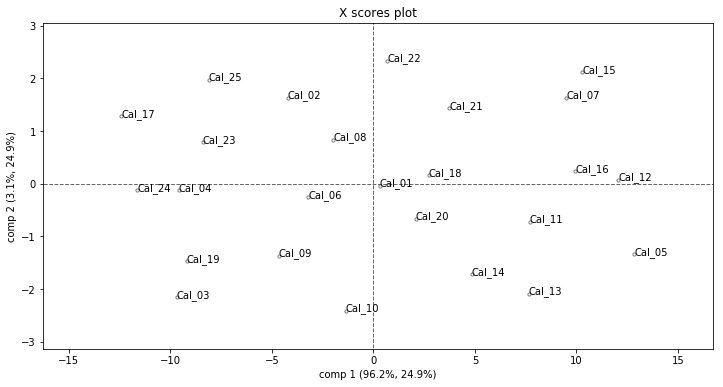

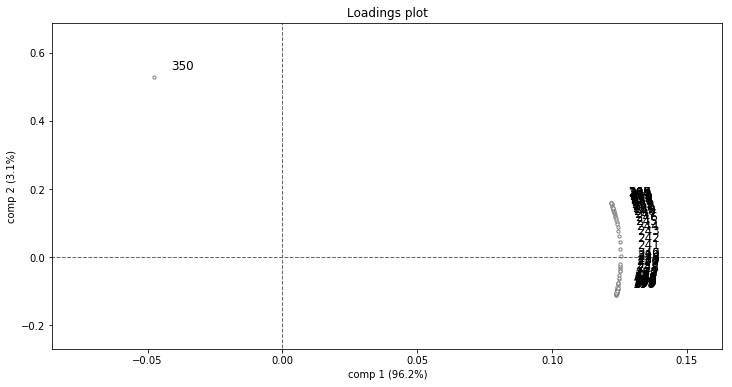

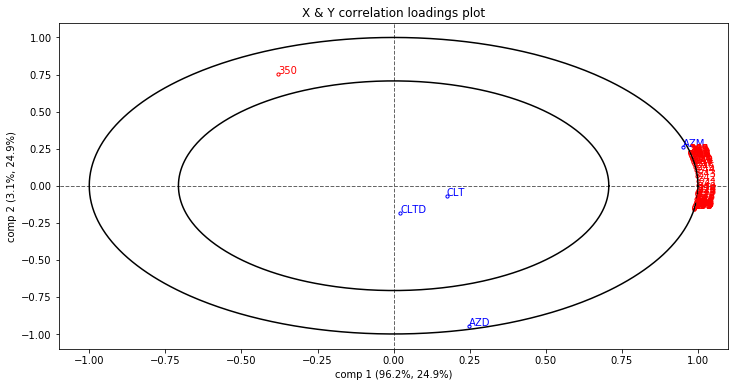

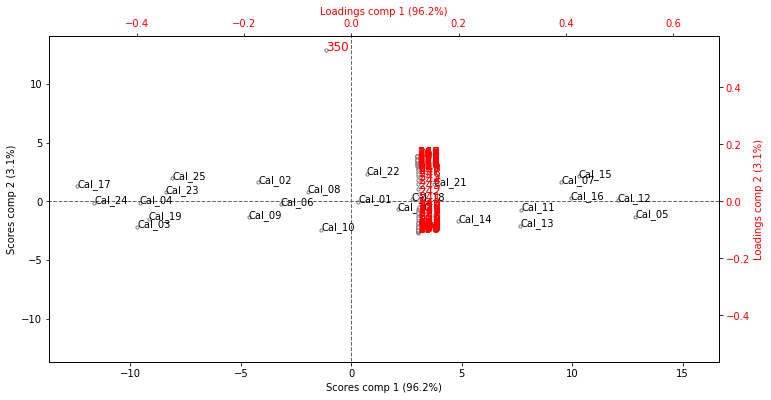

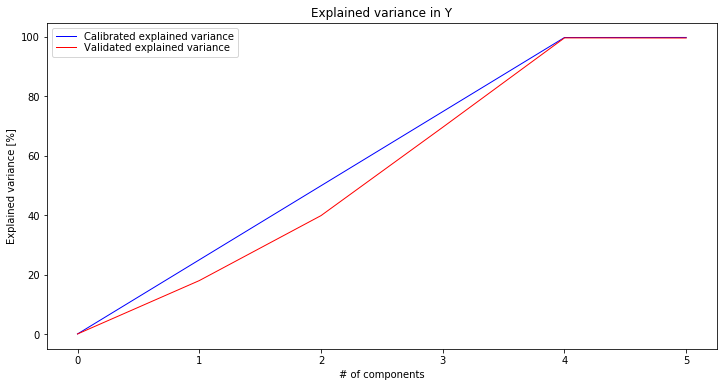

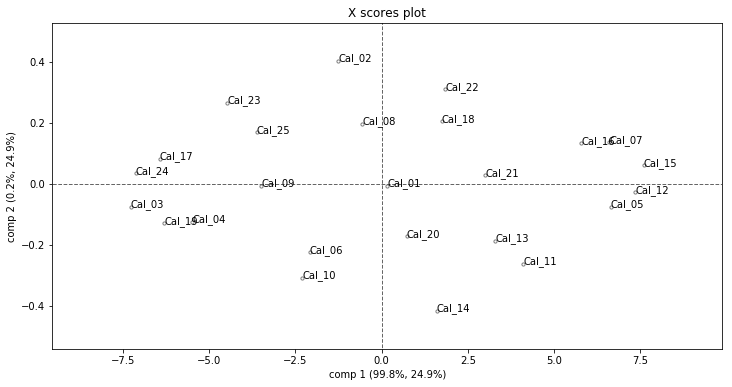

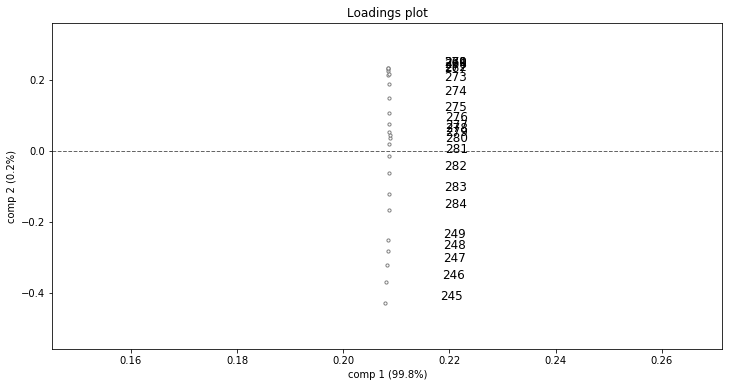

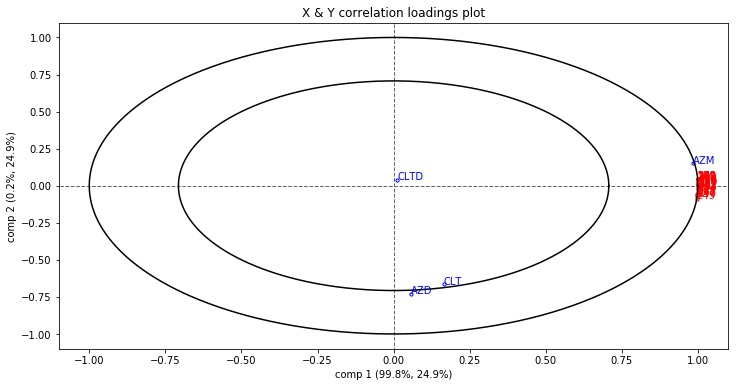

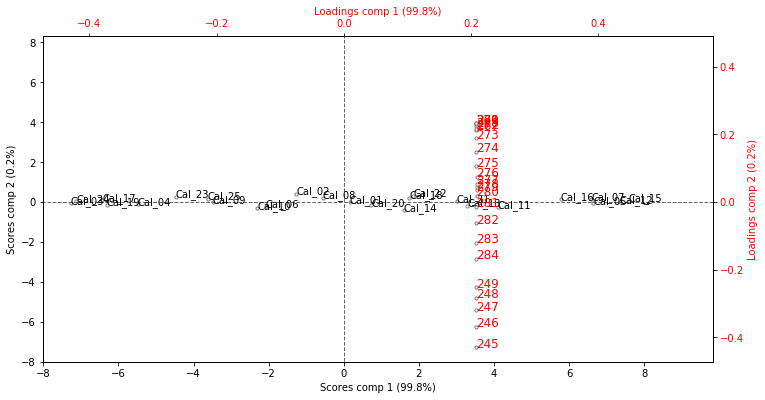

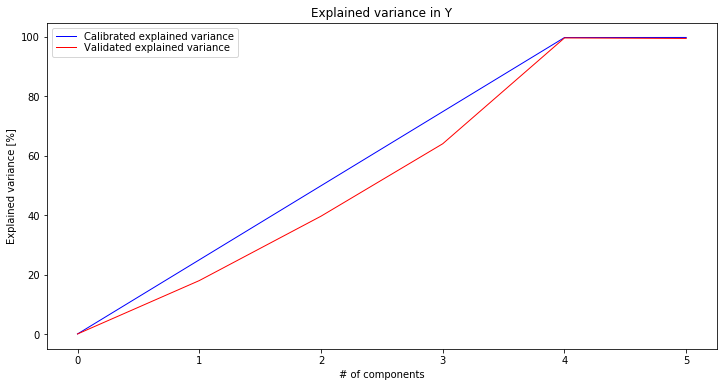

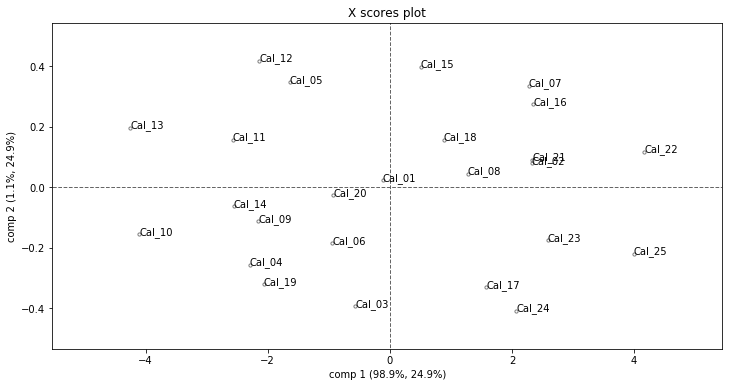

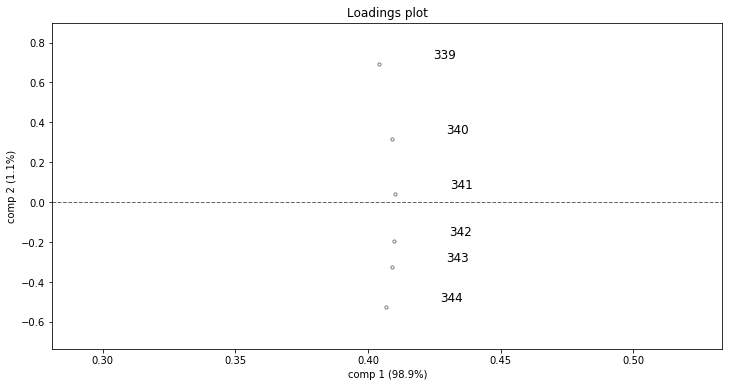

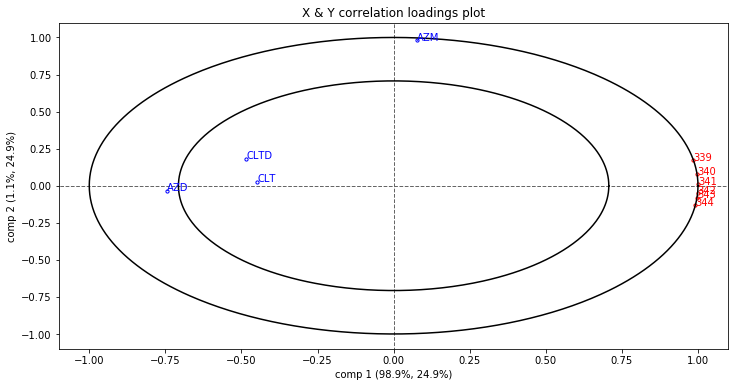

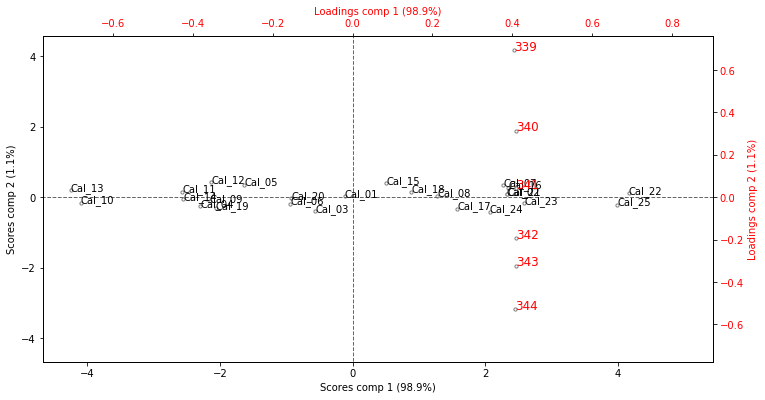

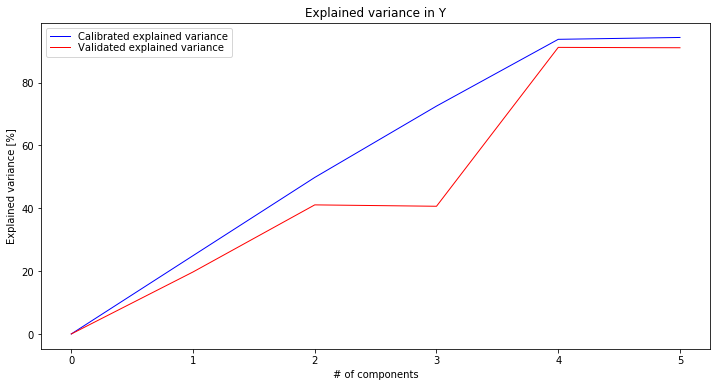

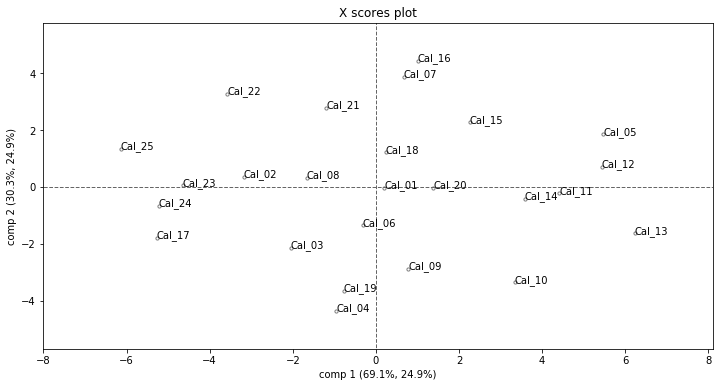

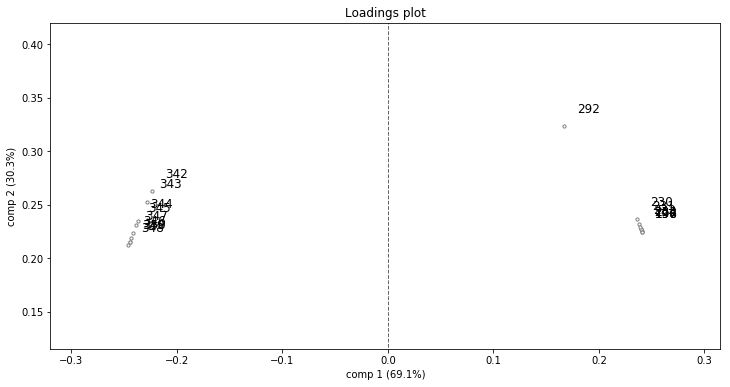

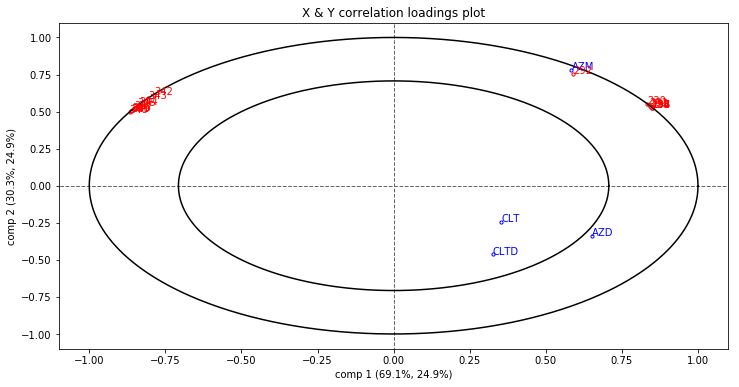

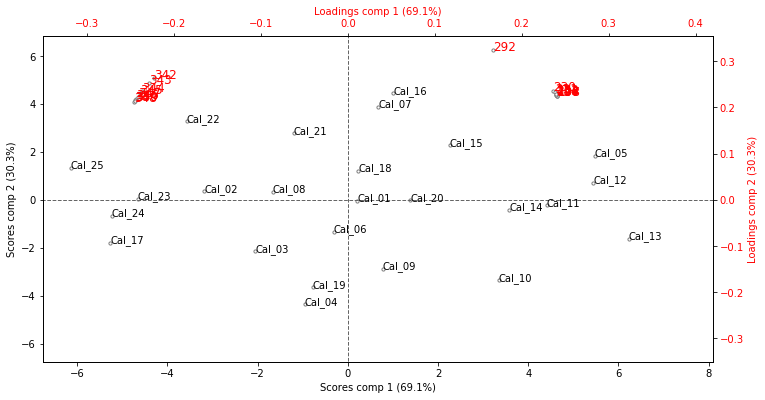

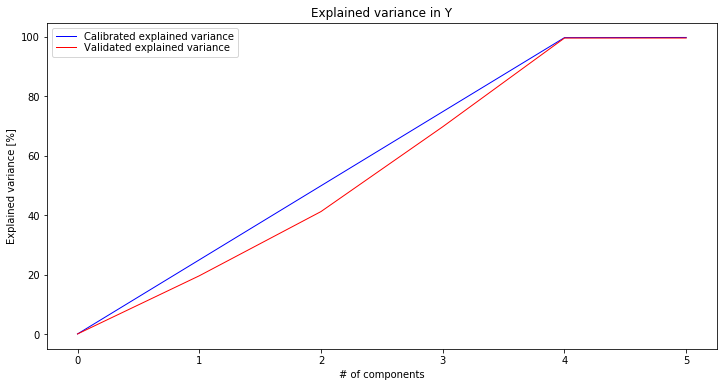

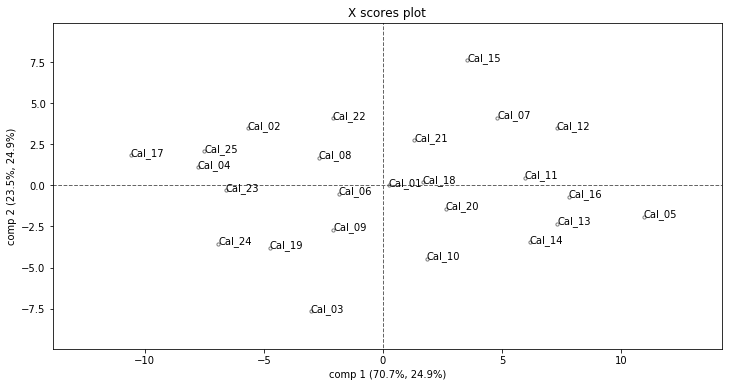

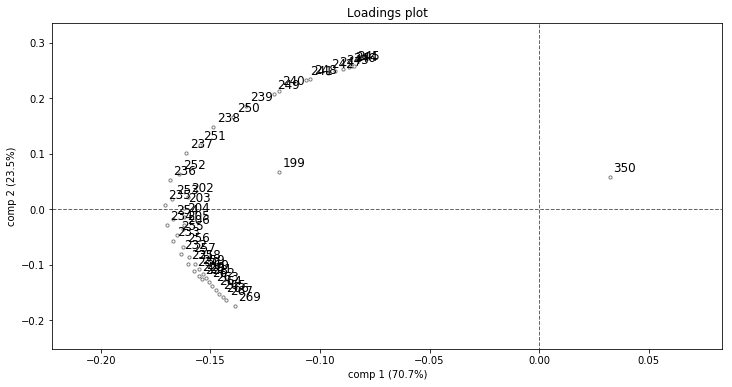

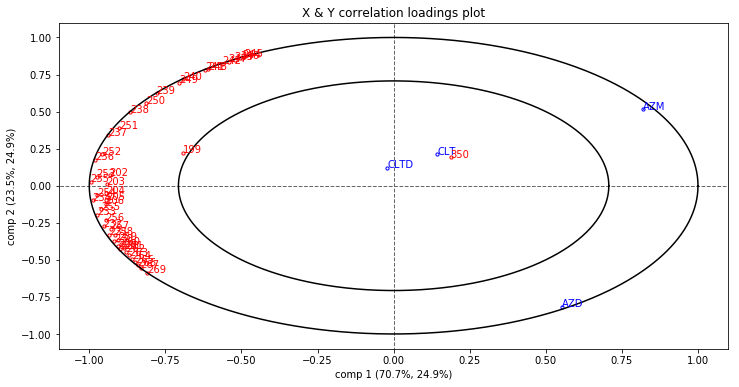

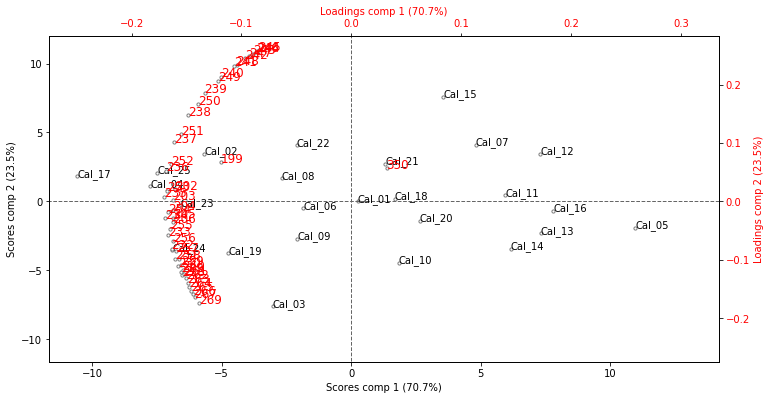

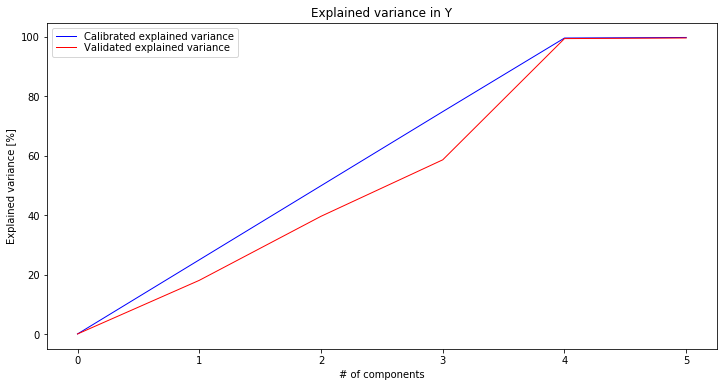

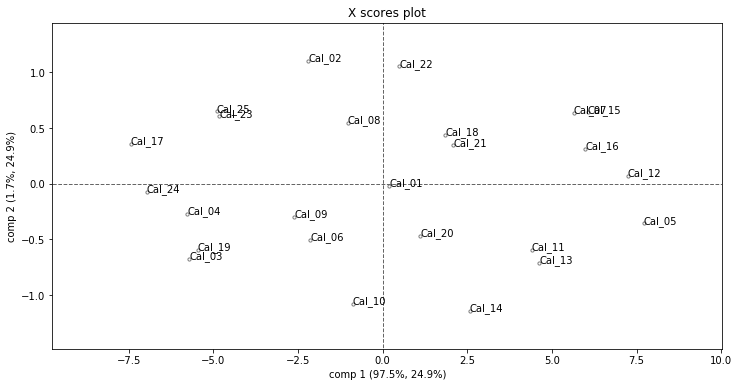

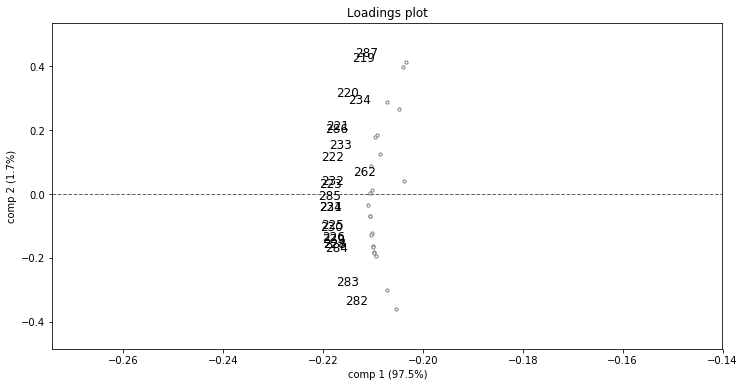

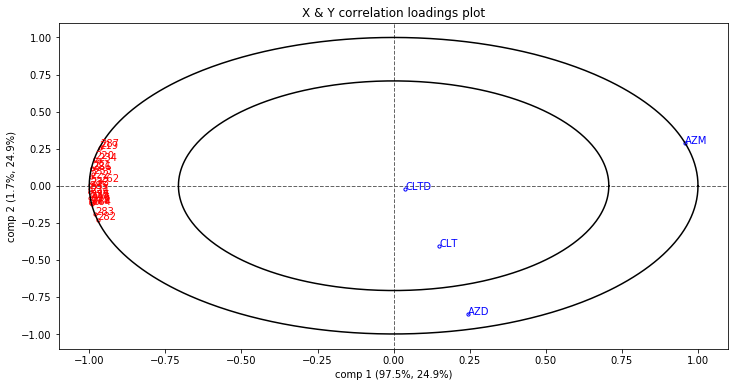

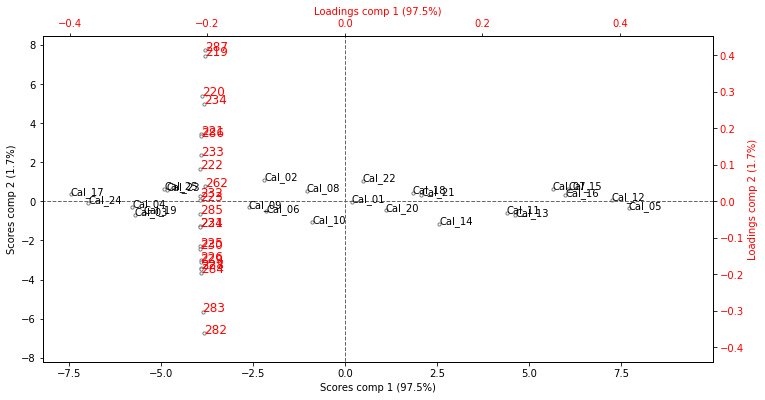

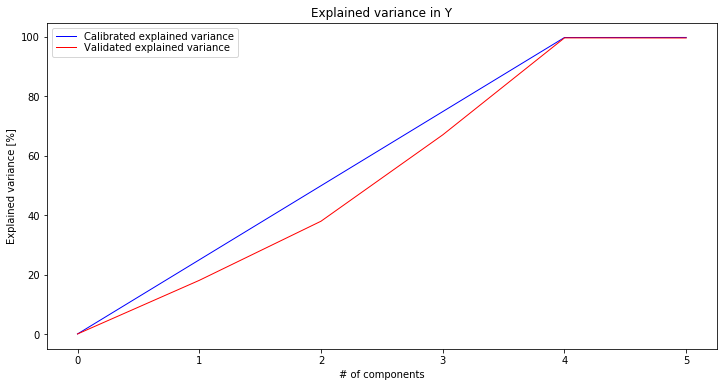

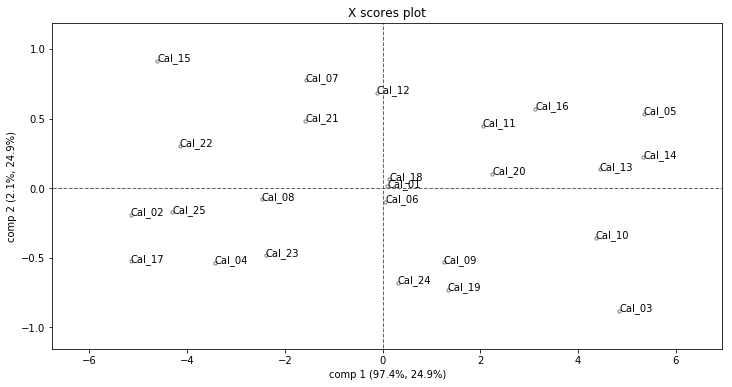

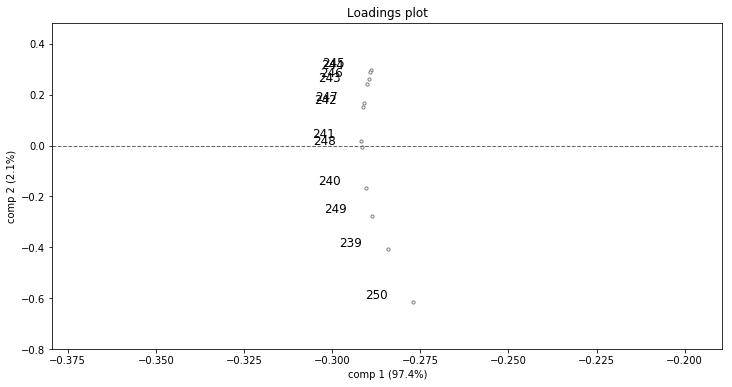

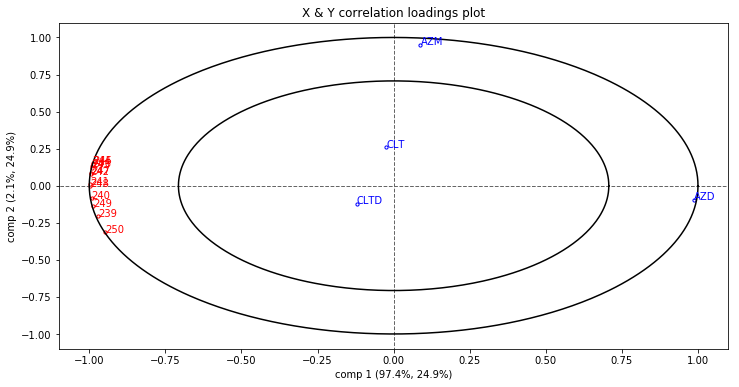

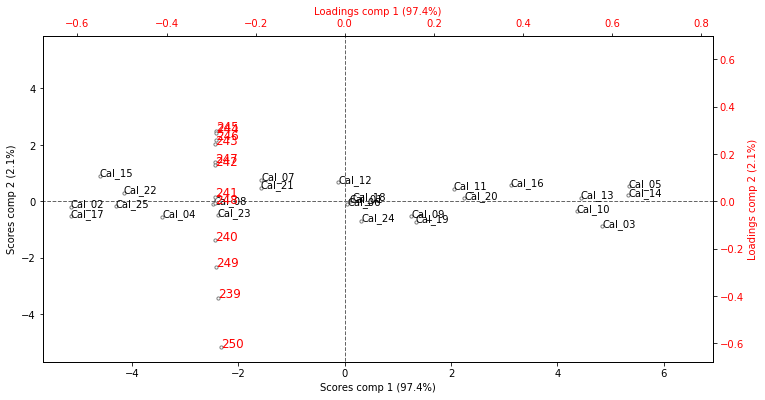

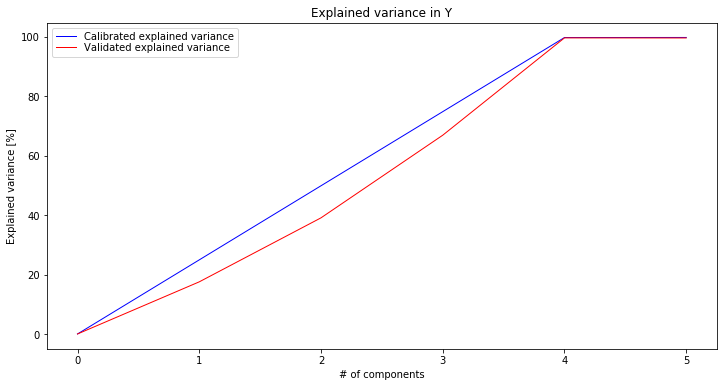

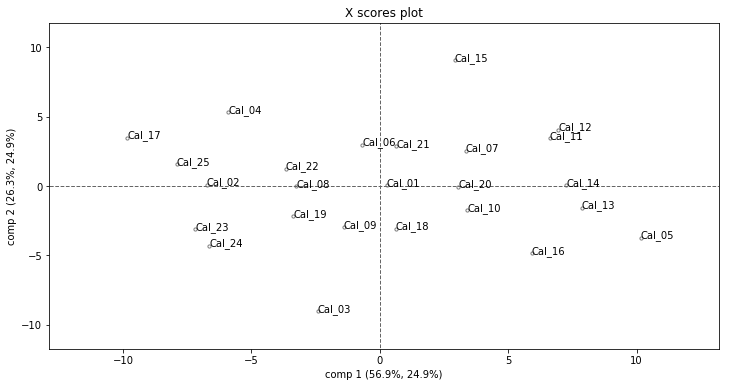

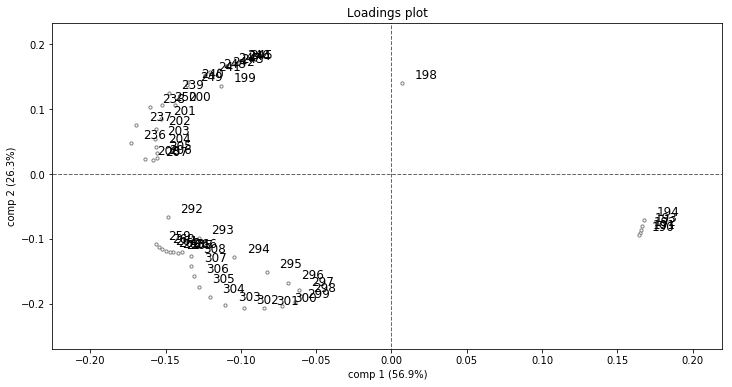

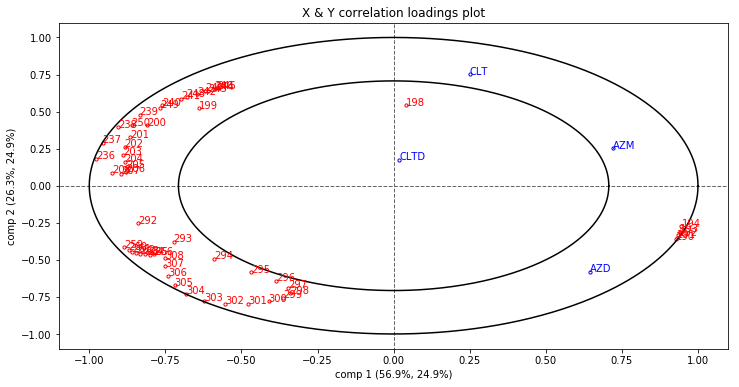

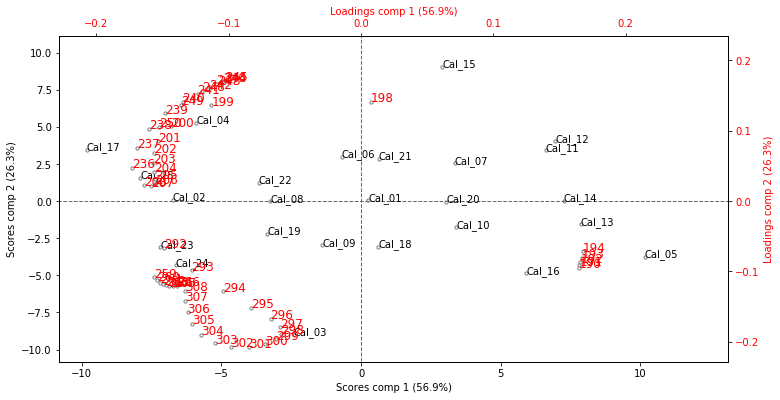

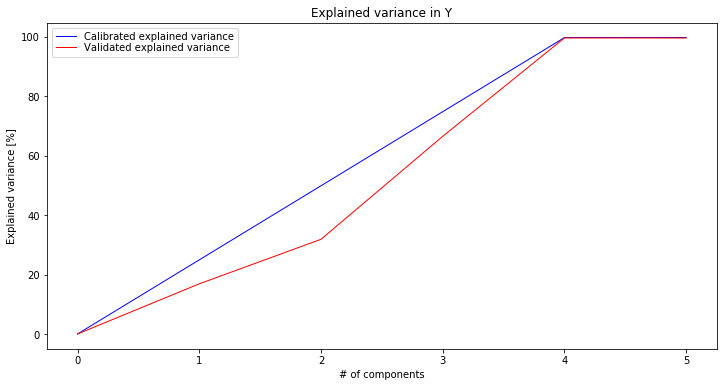

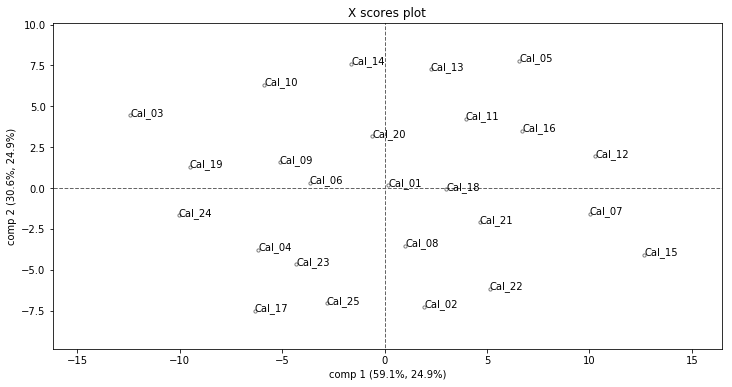

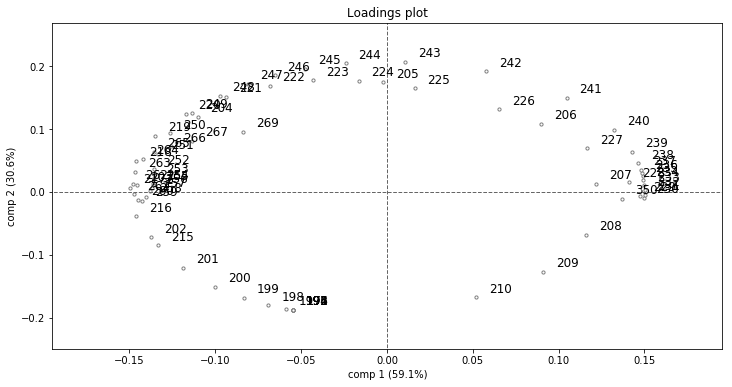

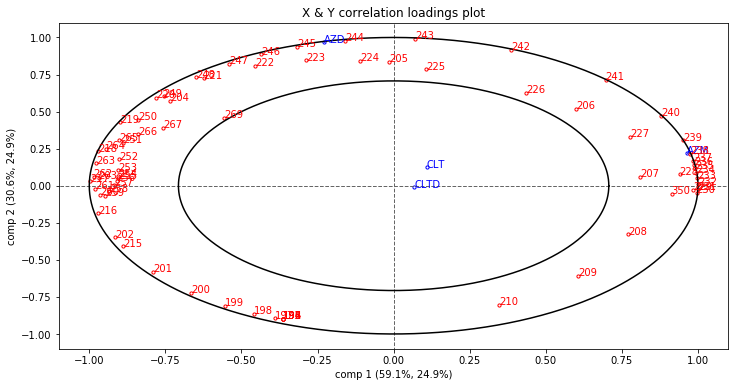

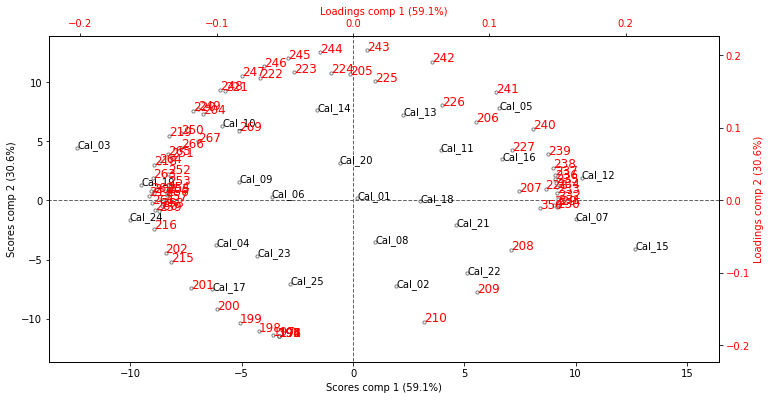

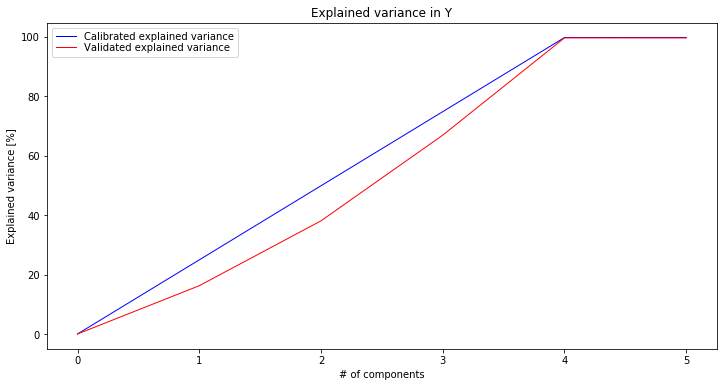

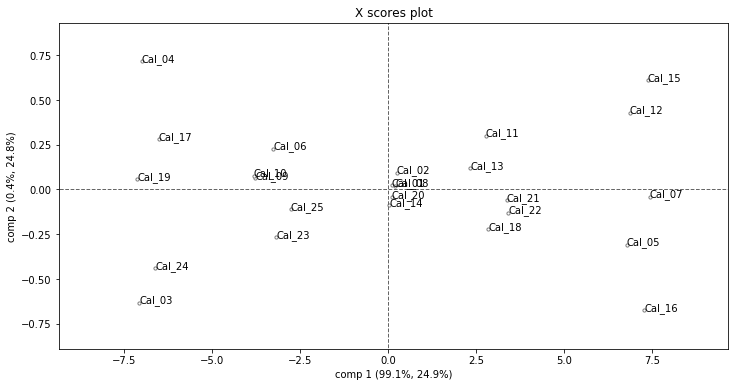

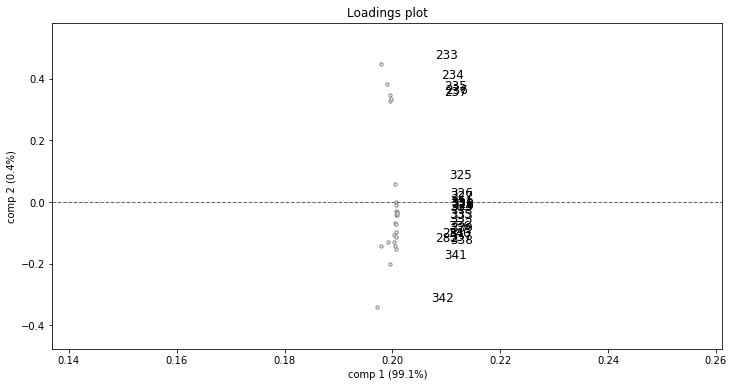

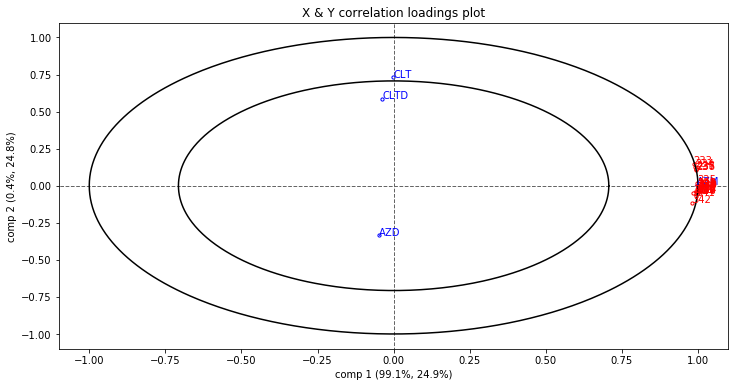

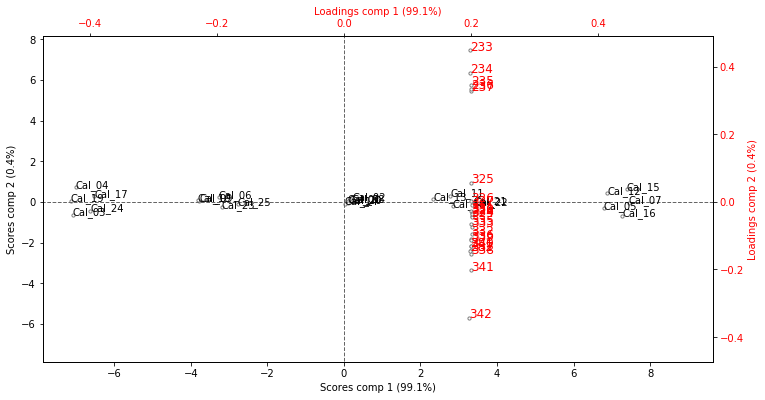

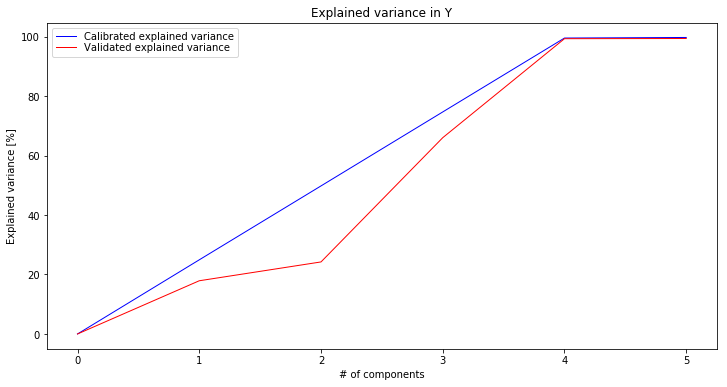

In [23]:
#Graphs of PC1 vs PC2
for i,j in zip([Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9]#,Model_10,Model_11]
               ,[bwlss_AZM_D0[0],bwlss_CLT_D0[0],bwlss_AZD_D0[0],bwlss_CLTD_D0[0],
                bwlss_AZM_D1[0],bwlss_CLT_D1[0],bwlss_AZD_D1[0],bwlss_CLTD_D1[0],
                bwlss_AZM_D2[0],bwlss_CLT_D2[0]]):#,bwlss_AZD_D2[0],bwlss_CLTD_D2[0]]):
    hop.plot(i, comp=[1, 2], plots=[1,2,3,4, 6], objNames=list(Xsamples),XvarNames=list(j),YvarNames=Analytes,figsize=[12,6])

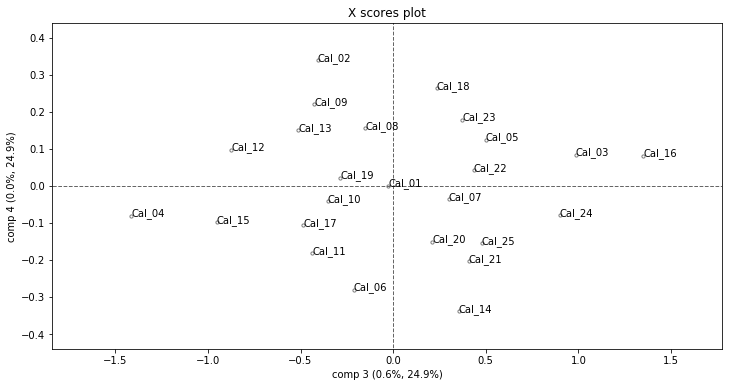

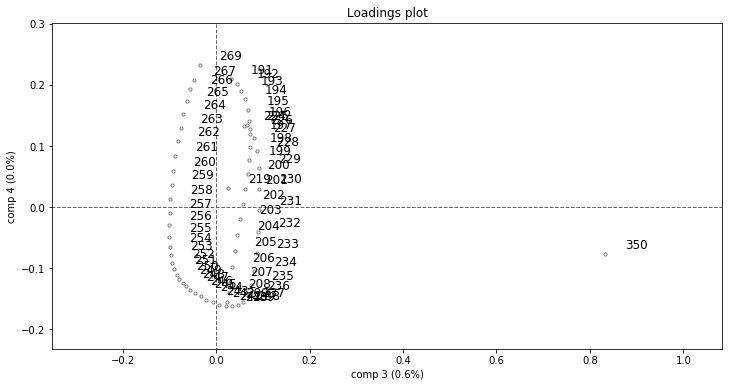

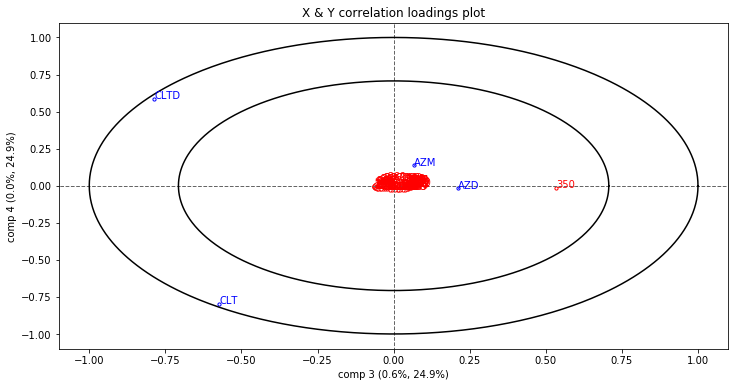

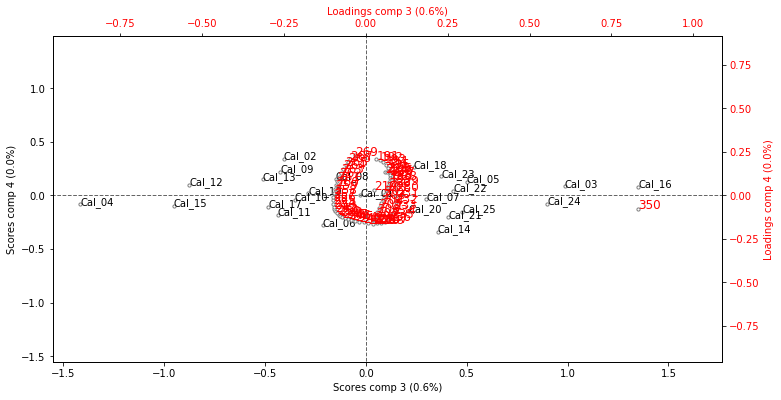

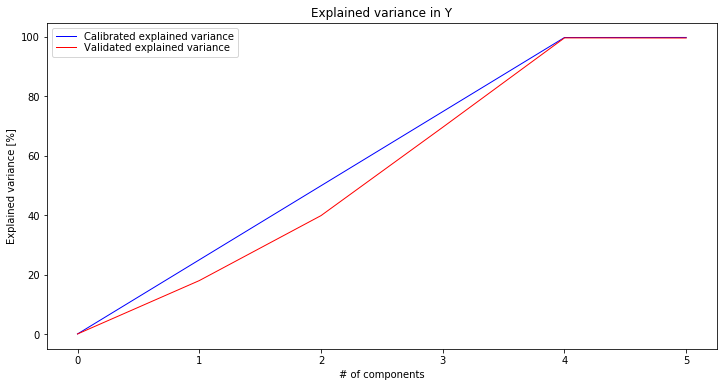

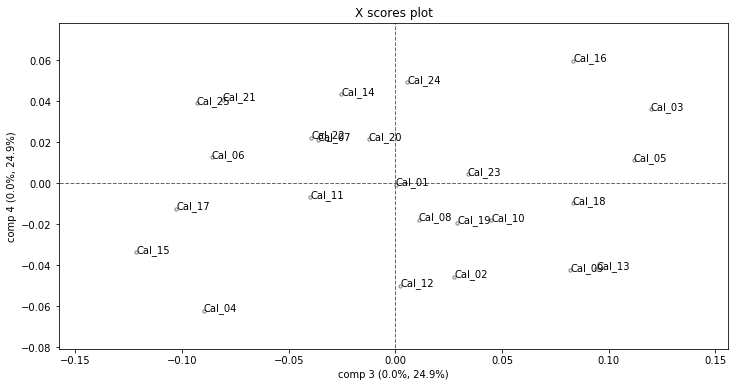

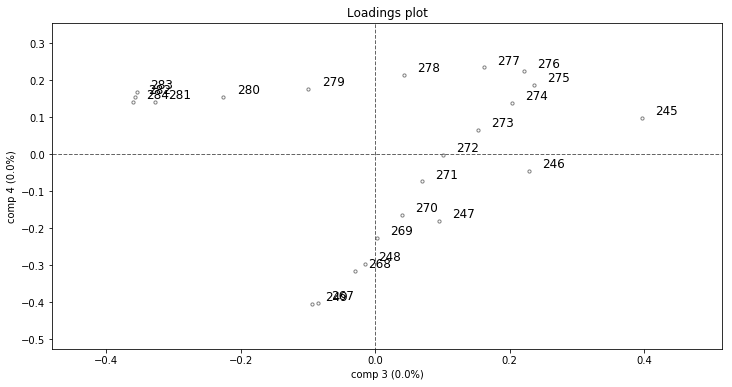

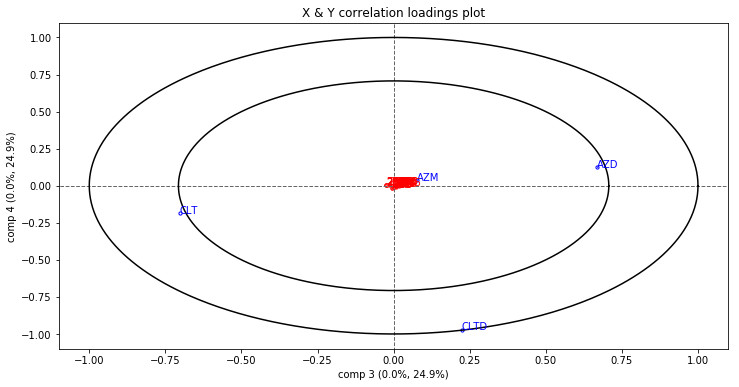

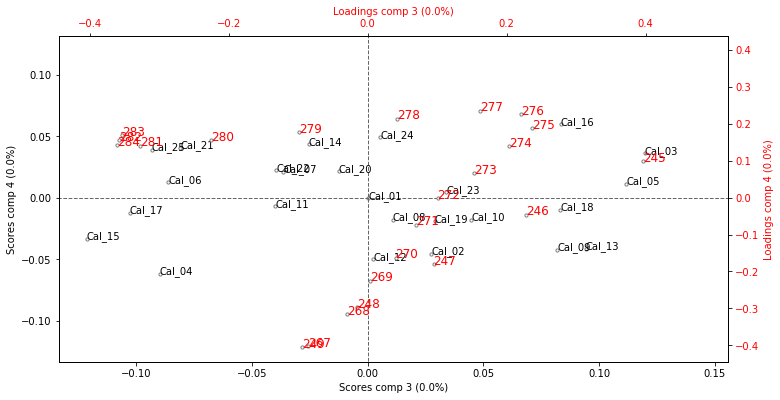

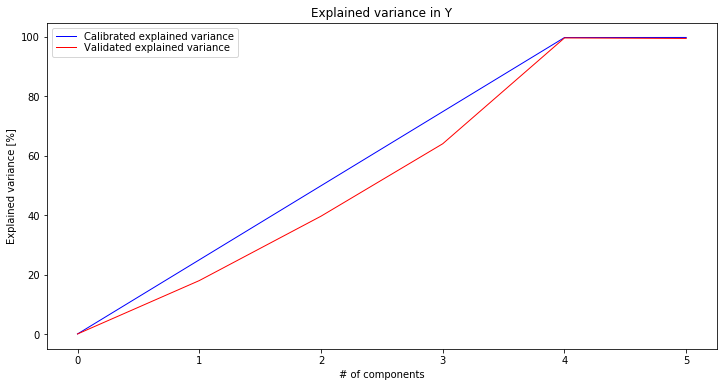

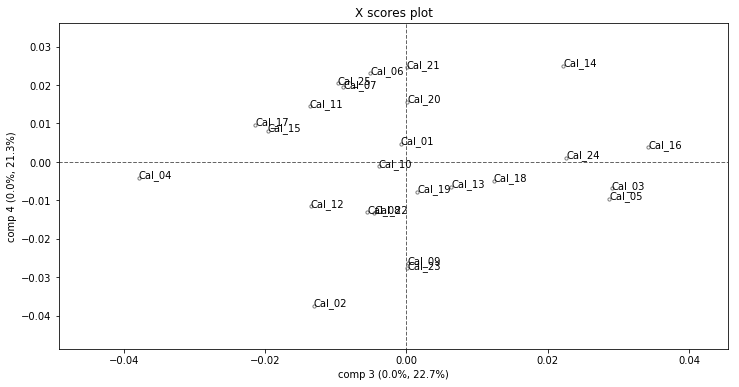

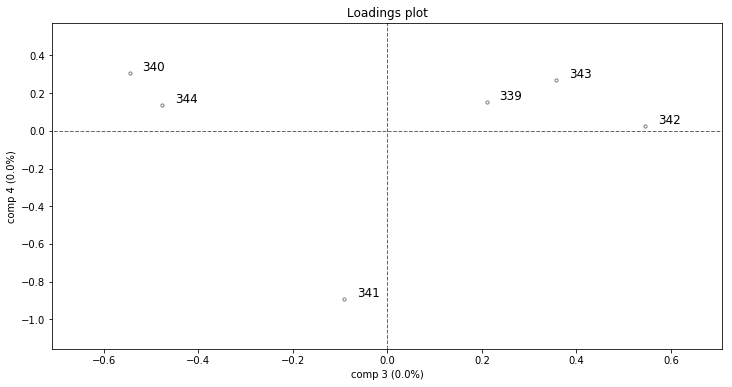

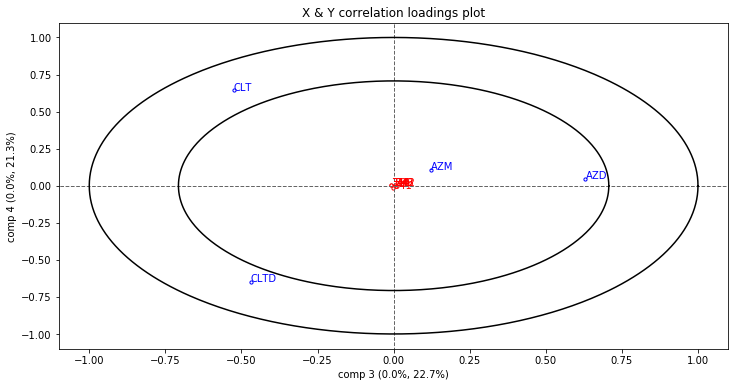

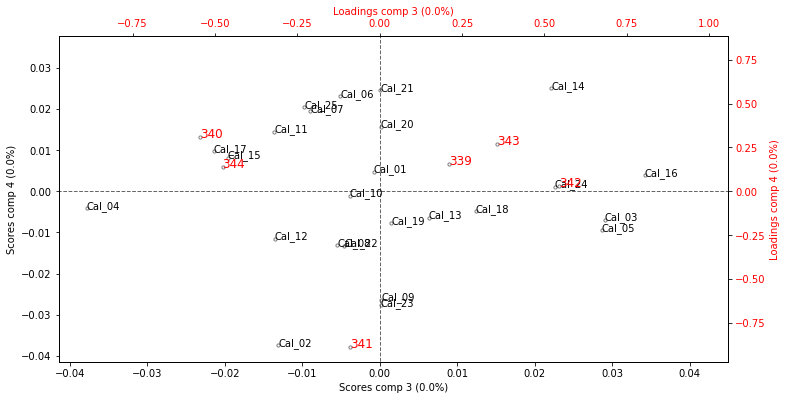

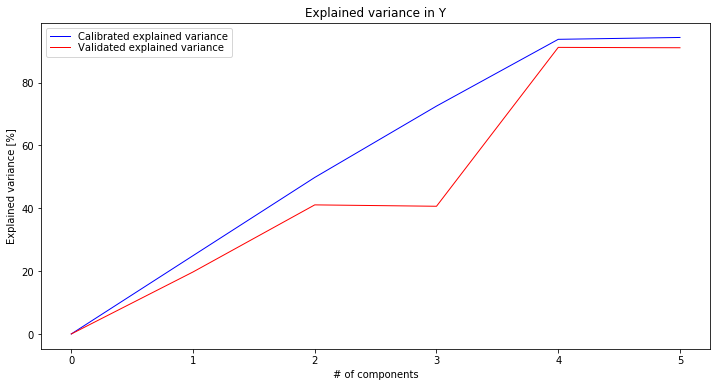

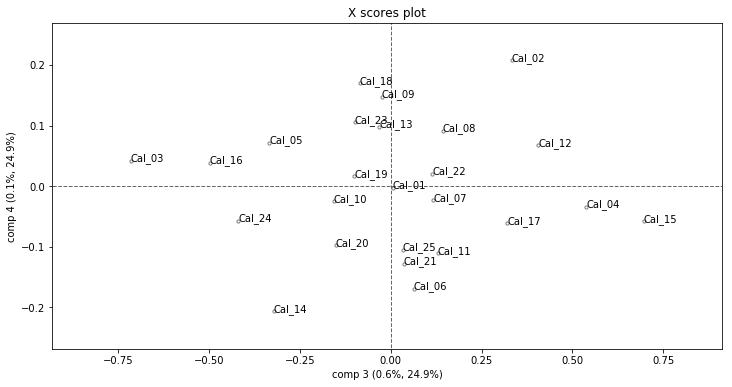

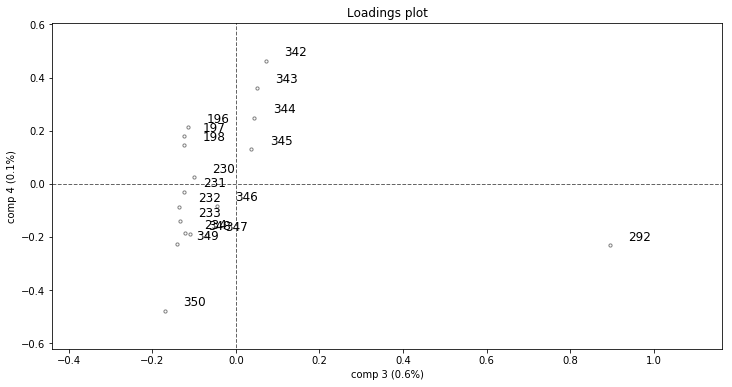

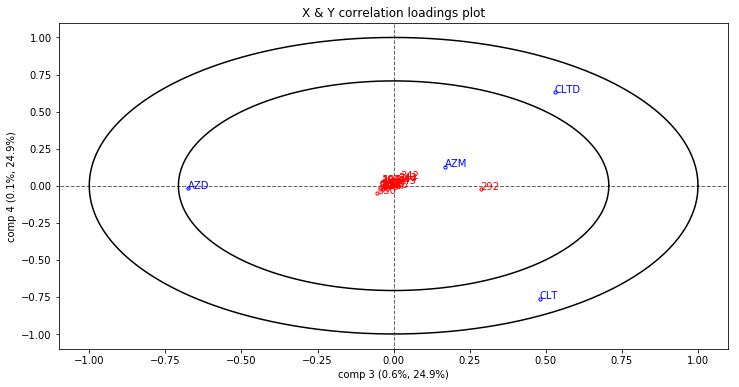

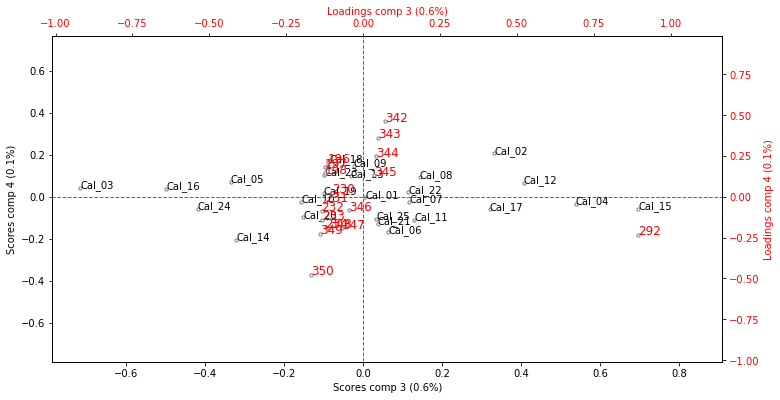

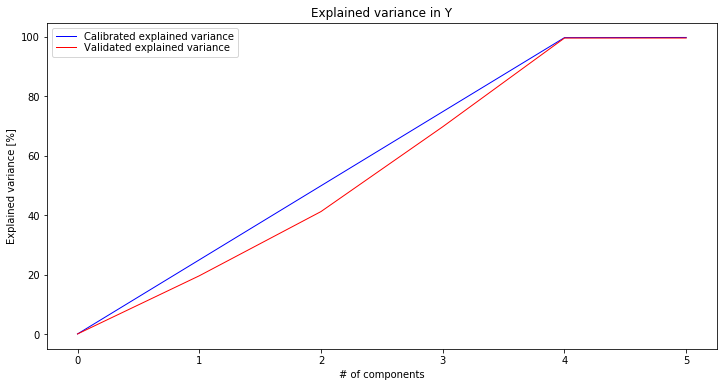

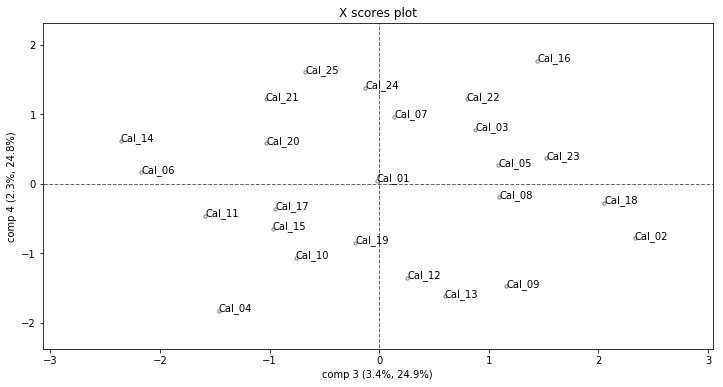

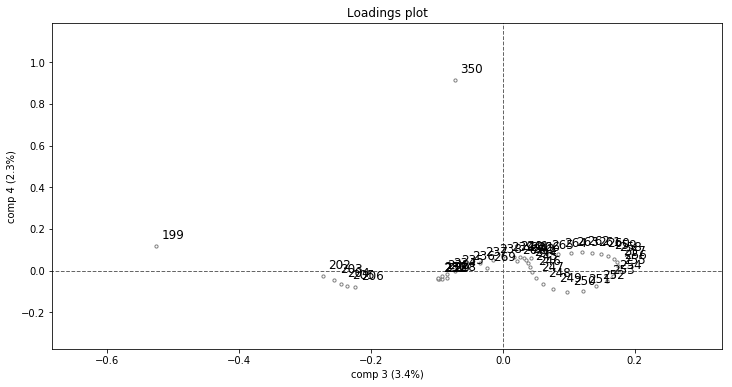

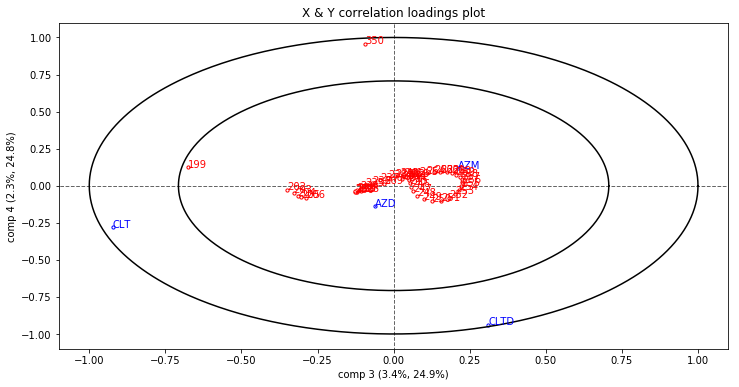

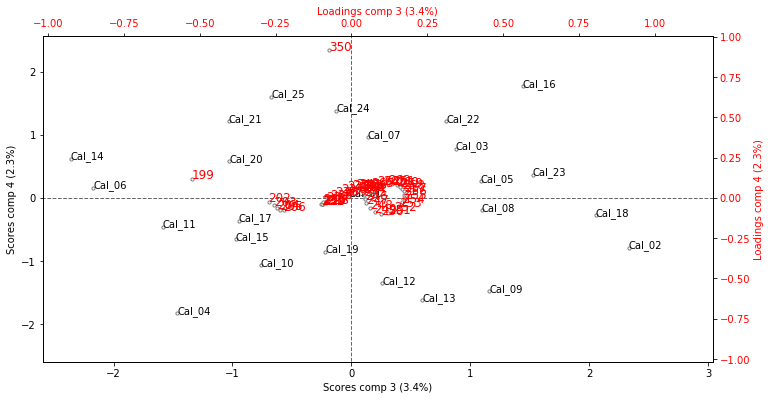

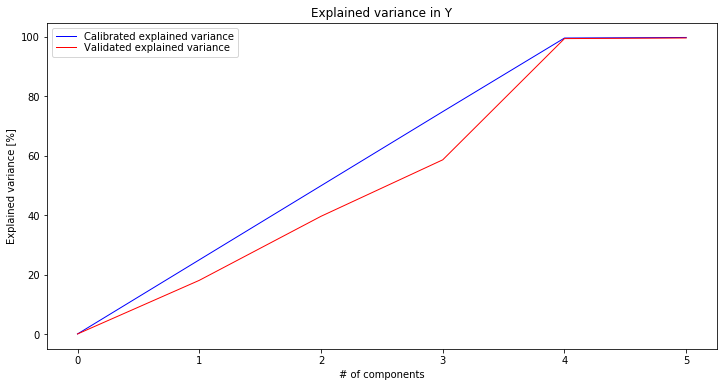

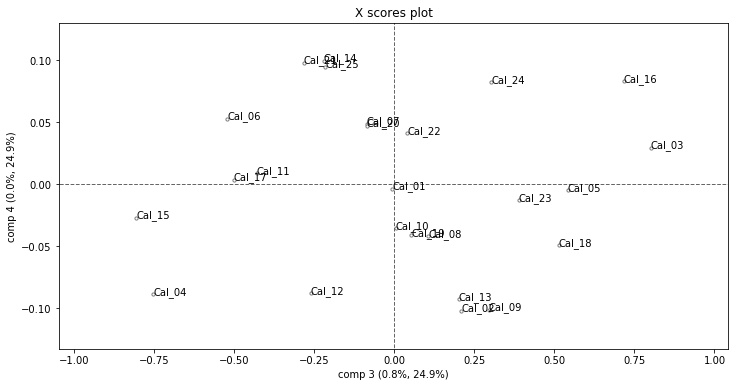

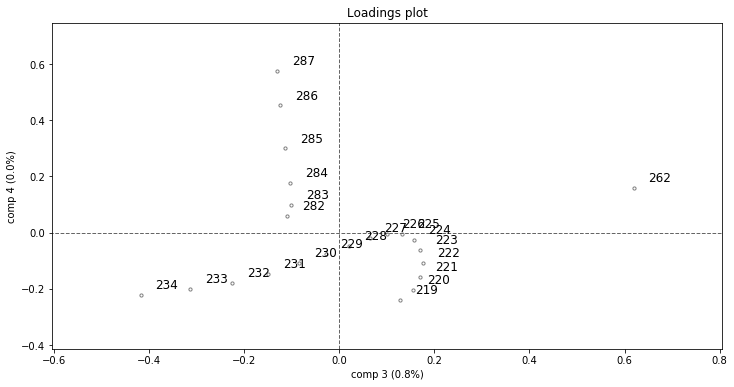

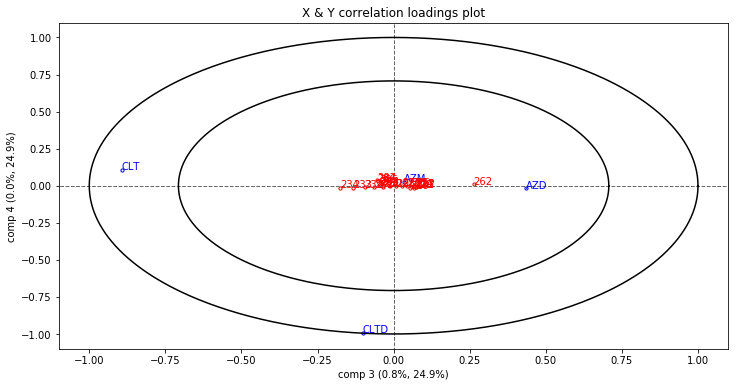

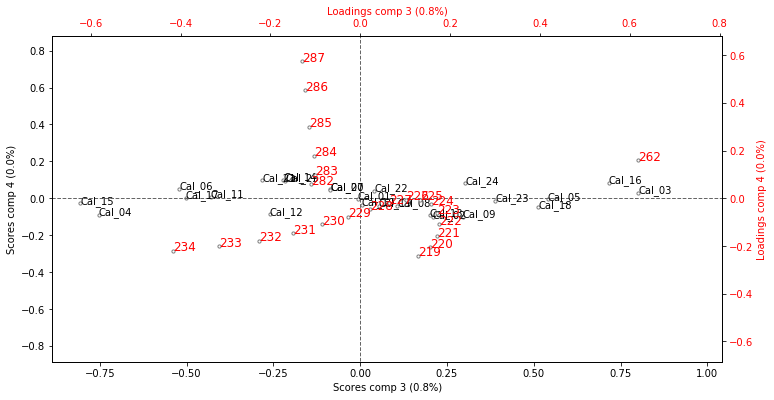

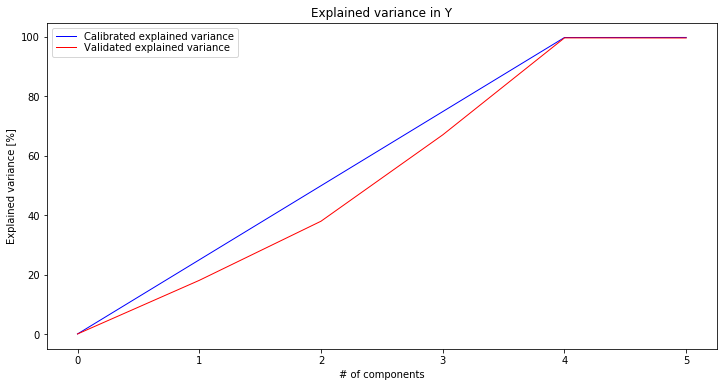

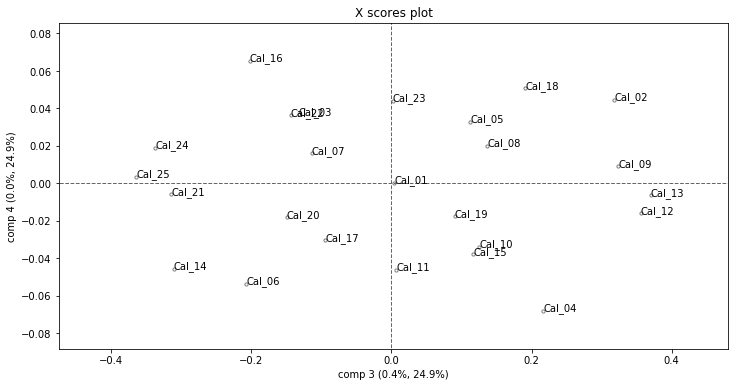

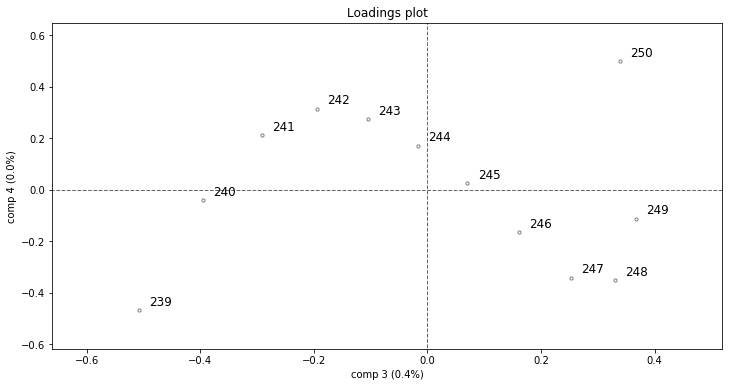

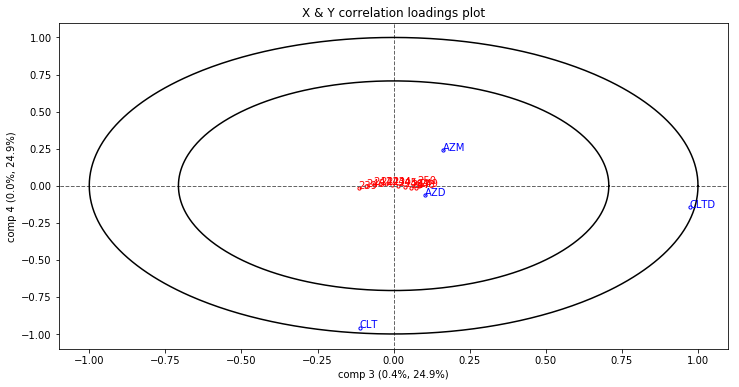

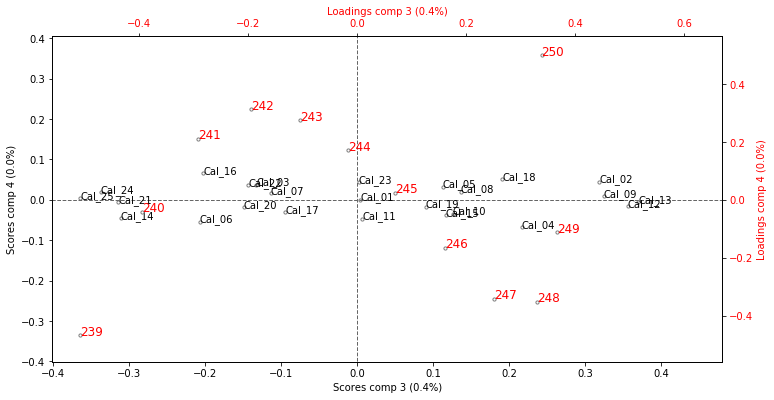

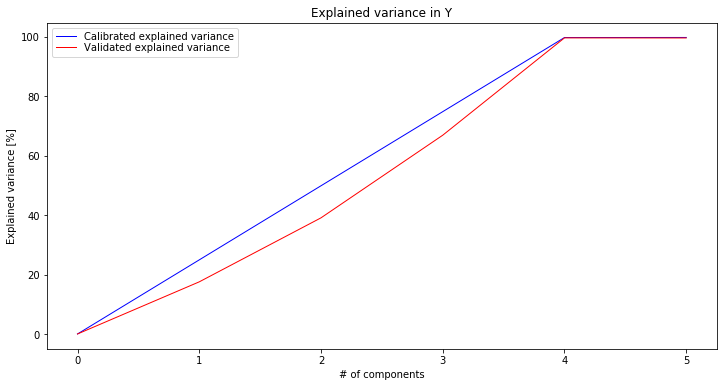

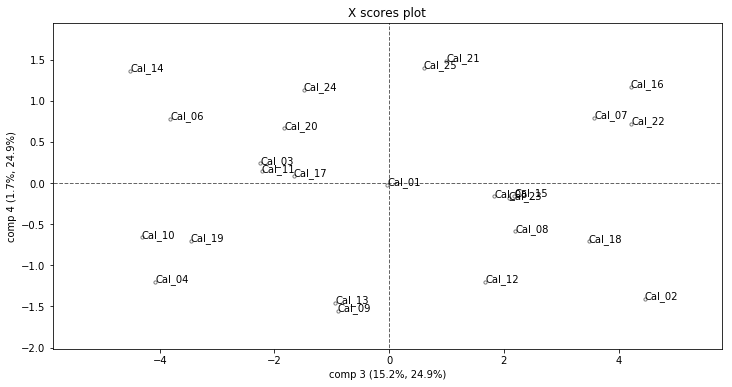

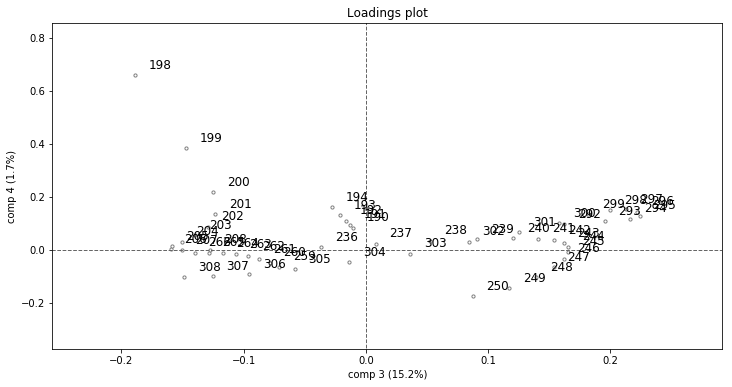

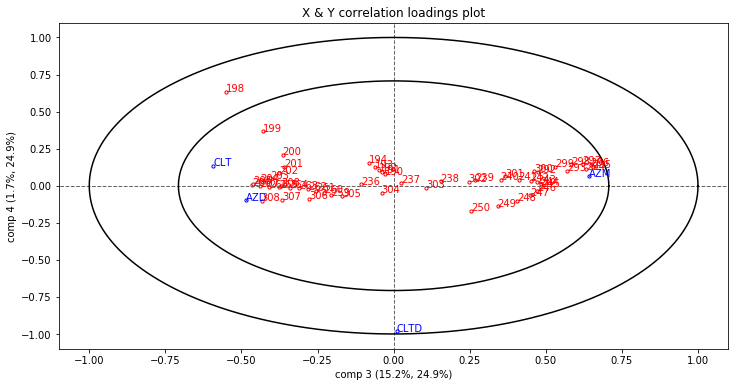

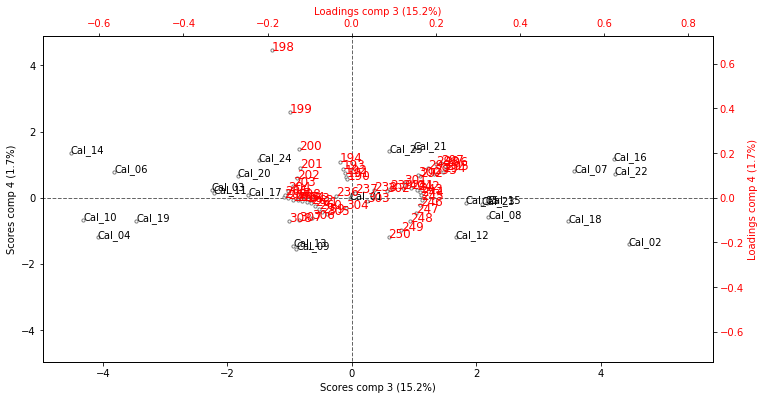

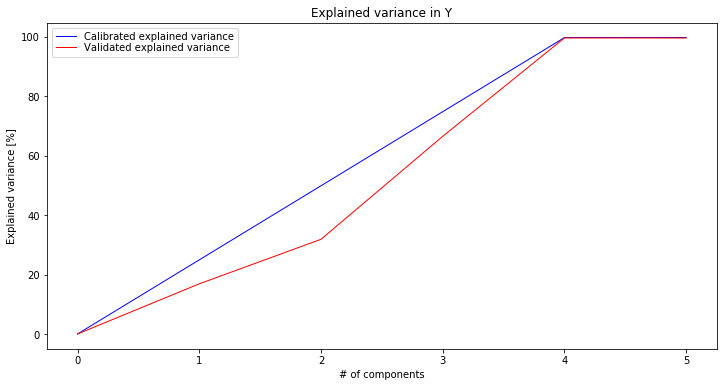

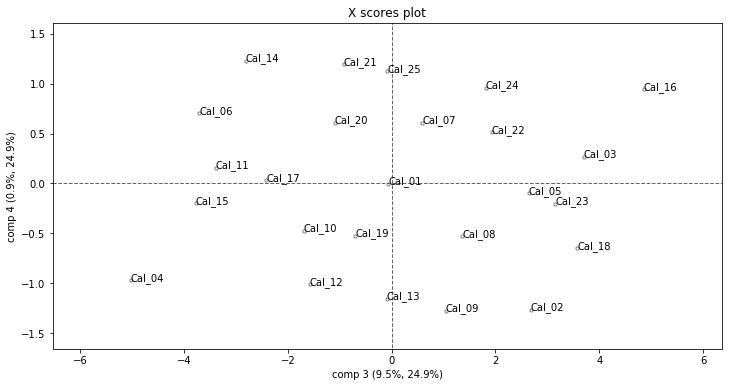

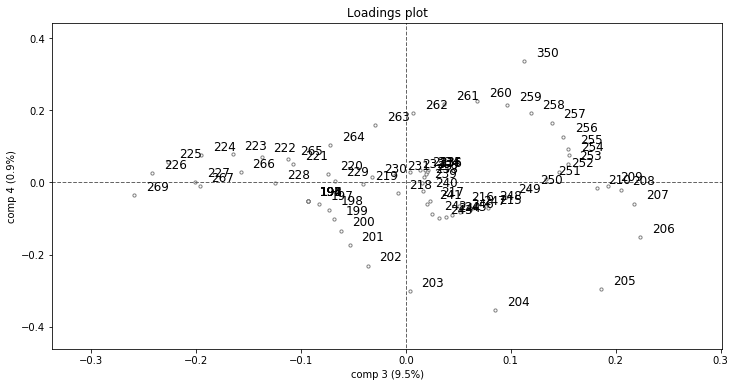

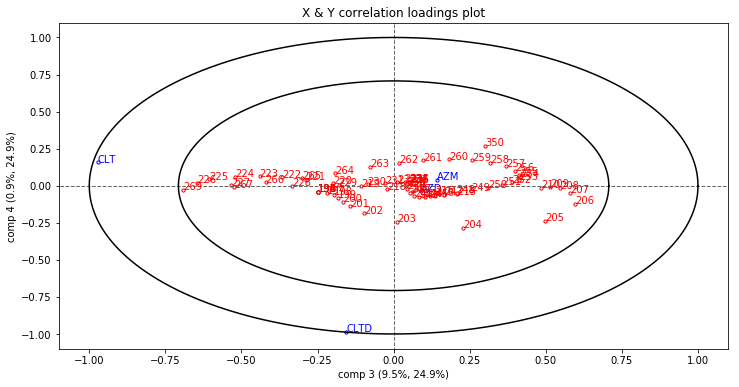

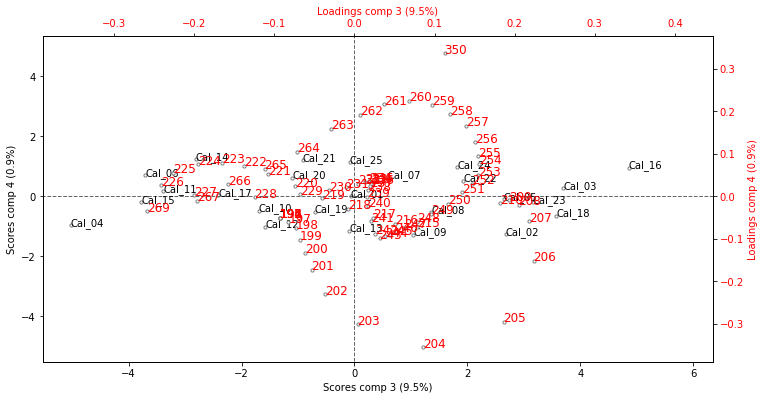

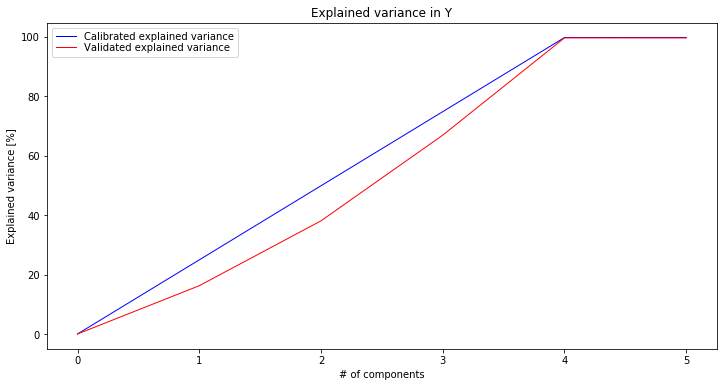

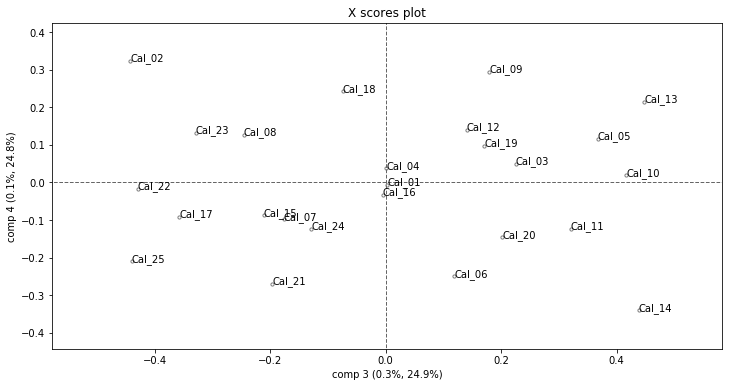

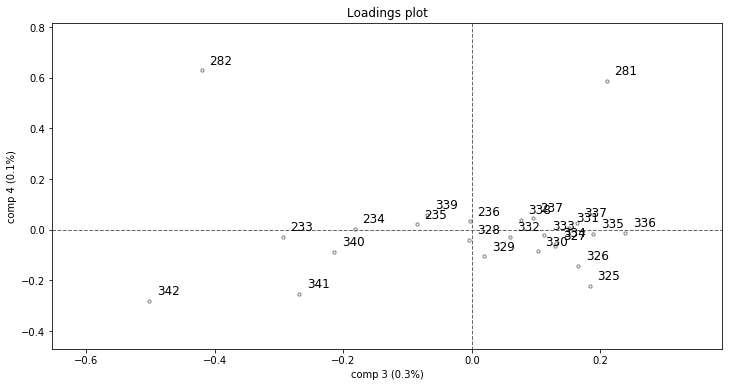

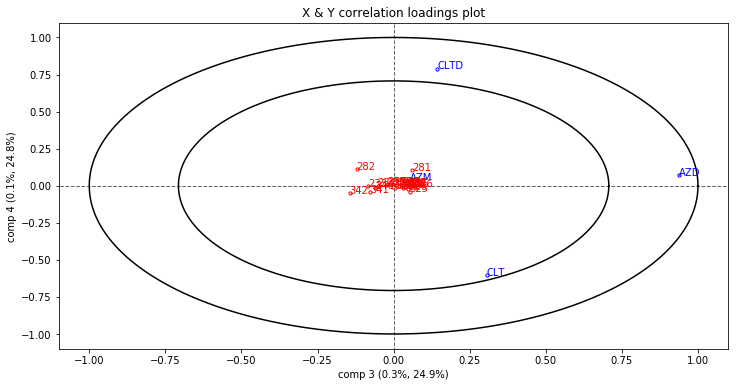

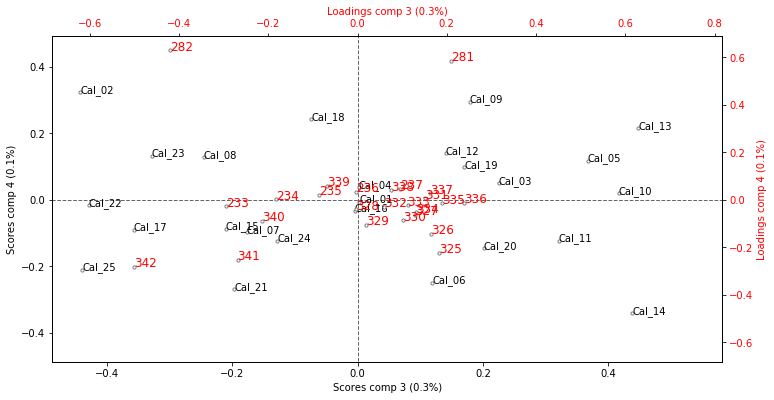

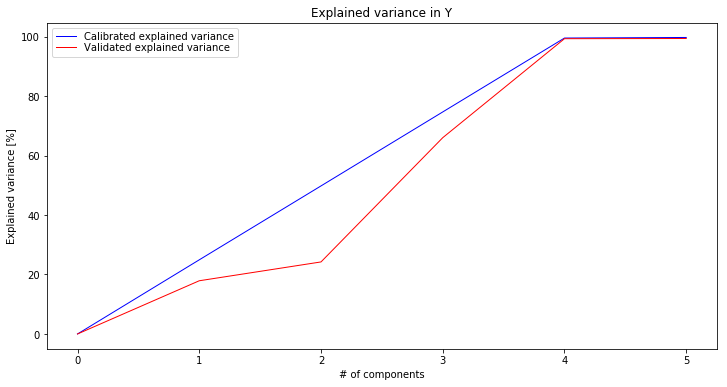

In [24]:
#Graphs of PC3 vs PC4
for i,j in zip([Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9]#,Model_10,Model_11]
               ,[bwlss_AZM_D0[0],bwlss_CLT_D0[0],bwlss_AZD_D0[0],bwlss_CLTD_D0[0],
                bwlss_AZM_D1[0],bwlss_CLT_D1[0],bwlss_AZD_D1[0],bwlss_CLTD_D1[0],
                bwlss_AZM_D2[0],bwlss_CLT_D2[0]]):#,bwlss_AZD_D2[0],bwlss_CLTD_D2[0]]):
    hop.plot(i, comp=[3, 4], plots=[1,2,3,4, 6], objNames=list(Xsamples),XvarNames=list(j),YvarNames=Analytes,figsize=[12,6])

In [25]:
# Predict external validation matrix using Model_0 to Model_11 and save in dataframe pred_Y_df_#
for i, value in enumerate(Validation_Matext):
        exec ("pred_Y_df_%s=100*pd.DataFrame(value[0].Y_predict(value[1], numComp=4))/yv" % (i))
        exec ("pred_Y_df_%s.columns = Analytes"% (i))
        exec ("pred_Y_df_%s.index = Xvsamples"% (i)) 

pred_Y_df=[pred_Y_df_0,pred_Y_df_1,pred_Y_df_2,pred_Y_df_3,pred_Y_df_4,pred_Y_df_5,
           pred_Y_df_6,pred_Y_df_7,pred_Y_df_8,pred_Y_df_9]#,pred_Y_df_10,pred_Y_df_11]
Predection=pd.concat(pred_Y_df,keys=Models,axis=1)
Predection.to_csv(directory+ r'\Predection_validation_set.csv')

In [36]:
# Predict traning set using Model_0 to Model_11 and save in dataframe pred_Y_df_#
for i, value in enumerate(Validation_Mattra):
        exec ("pred_Y_df_%s=100*pd.DataFrame(value[0].Y_predict(value[1], numComp=4))/y" % (i))
        exec ("pred_Y_df_%s.columns = Analytes"% (i))
        exec ("pred_Y_df_%s.index = Xsamples"% (i)) 

pred_Y_df=[pred_Y_df_0,pred_Y_df_1,pred_Y_df_2,pred_Y_df_3,pred_Y_df_4,pred_Y_df_5,
           pred_Y_df_6,pred_Y_df_7,pred_Y_df_8,pred_Y_df_9]#,pred_Y_df_10,pred_Y_df_11]
Predection=pd.concat(pred_Y_df,keys=Models,axis=1)
Predection.to_csv(directory+ r'\Predection_traning_set.csv')

In [26]:
#Store RMSECV, Explained_variance_X, Explained_variance_Y of Model_#
for i, value in enumerate ([Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9]):#,Model_10,Model_11]):
            exec ("RMSECV_%s=value.Y_RMSECV()" % (i))
            exec ("Explained_variance_X_%s=value.X_cumCalExplVar()" % (i))
            exec ("Explained_variance_Y_%s=value.Y_cumCalExplVar()" % (i))

RMSECV=[RMSECV_0,RMSECV_1,RMSECV_2,RMSECV_3,RMSECV_4,RMSECV_5,RMSECV_6,RMSECV_7,RMSECV_8,RMSECV_9]#,RMSECV_10,RMSECV_11]
Explained_variance_X=[Explained_variance_X_0,Explained_variance_X_1,Explained_variance_X_2,Explained_variance_X_3,Explained_variance_X_4,Explained_variance_X_5,Explained_variance_X_6,Explained_variance_X_7,
                      Explained_variance_X_8,Explained_variance_X_9]#,Explained_variance_X_10,Explained_variance_X_11]
Explained_variance_Y=[Explained_variance_Y_0,Explained_variance_Y_1,Explained_variance_Y_2,Explained_variance_Y_3,Explained_variance_Y_4,Explained_variance_Y_5,Explained_variance_Y_6,Explained_variance_Y_7,
                      Explained_variance_Y_8,Explained_variance_Y_9]#,Explained_variance_Y_10,Explained_variance_Y_11]
#Store Y RMSECV in dataframe for Model_0 to Model_11
Predection_characteristics_RMSECV=pd.DataFrame(RMSECV)
Predection_characteristics_RMSECV.columns = ['PC0','PC1','PC2','PC3','PC4','PC5']
Predection_characteristics_RMSECV.index =Models

#Store X Explained_variance in dataframe for Model_0 to Model_11
Predection_characteristics_Exp_var_X=pd.DataFrame(Explained_variance_X)
Predection_characteristics_Exp_var_X.columns = ['PC0','PC1','PC2','PC3','PC4','PC5']
Predection_characteristics_Exp_var_X.index =Models

#Store Y Explained_variance in dataframe for Model_0 to Model_11
Predection_characteristics_Exp_var_Y=pd.DataFrame(Explained_variance_Y)
Predection_characteristics_Exp_var_Y.columns = ['PC0','PC1','PC2','PC3','PC4','PC5']
Predection_characteristics_Exp_var_Y.index =Models
Predection_characteristics=pd.concat([Predection_characteristics_RMSECV,Predection_characteristics_Exp_var_X,Predection_characteristics_Exp_var_Y],
                                     keys=['RMSECV',' X Explained variance','Y Explained variance',],axis=1)
Predection_characteristics.to_csv(directory+ r'\Predection_characteristics.csv')

In [27]:
# save the models to disk
for i in Models:
    filename = directory+ r'\{}.sav'.format(i)
    joblib.dump(i, filename)

#  Model_0 to Model_11 correspond to validation matrices Xv_AZM_D0 to Xv_CLTD_D2

In [31]:
import pandas_profiling
import numpy as np
import pandas as pd
import pandas_profiling

df =pd.DataFrame(X_AZD_D1,columns=bwlss_AZD_D1)
df.profile_report(style={})

AttributeError: Can only use .str accessor with string values (i.e. inferred_type is 'string', 'unicode' or 'mixed')

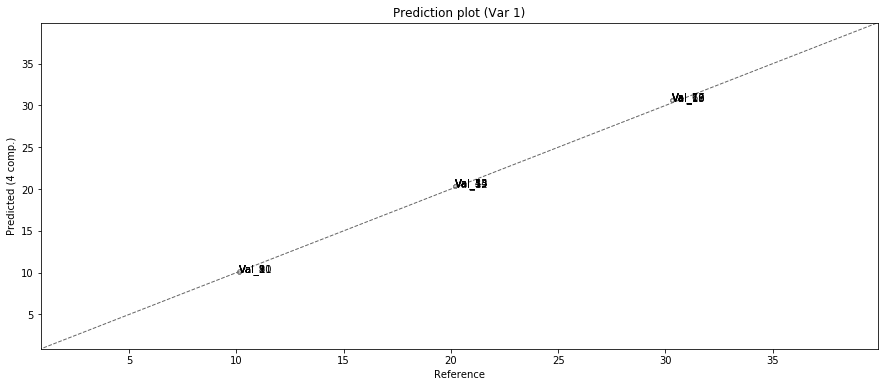

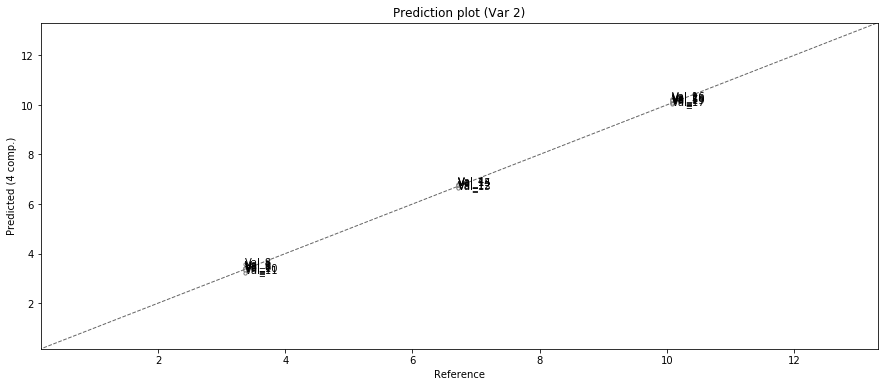

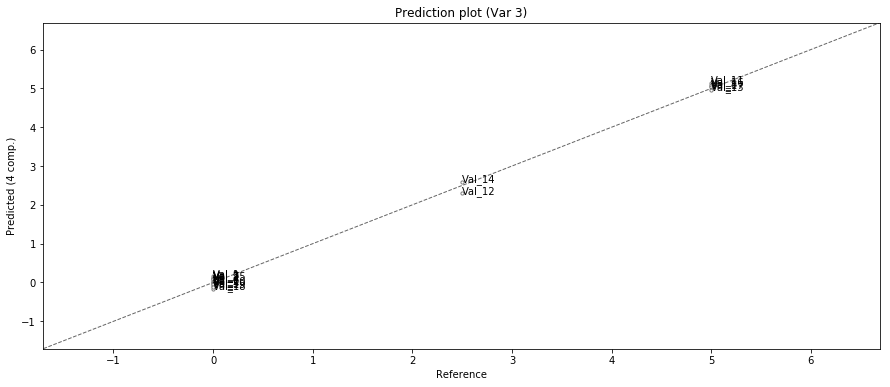

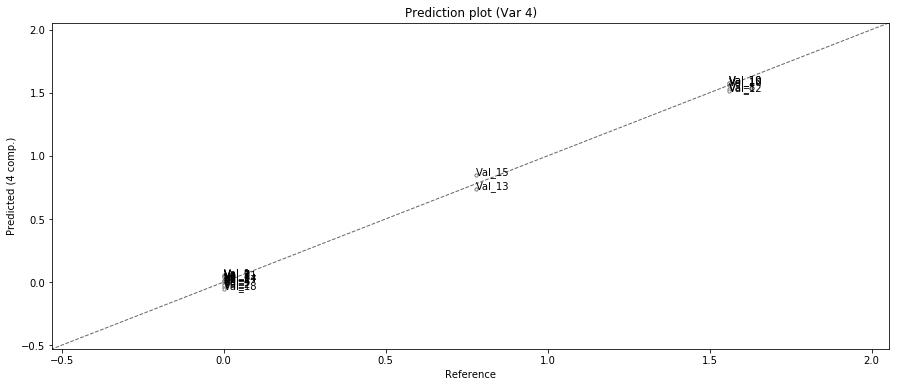

In [18]:
# load the model from disk
loaded_model = Model_9 #ho.nipalsPLS2(arrX=X2, arrY=y, cvType=["loo"])
hop.predict(loaded_model, comp=[4],objNames=list(Xsamples), newX=Xv_CLT_D2, newY=yv,
            newObjNames=list(Xvsamples), figsize=[15,6])#only change the newX that correspond to Model_#
#loaded_model =joblib.load('AZM_D2.sav')
#result = loaded_model.score(Xv2, yv)
#print(result)

80% completed

C:\Users\Black Knight\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:317: UserWarning: X scores are null at iteration 4
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Black Knight\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:317: UserWarning: X scores are null at iteration 4
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Black Knight\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:317: UserWarning: X scores are null at iteration 4
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Black Knight\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:317: UserWarning: X scores are null at iteration 4
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Black Knight\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:317: UserWarning: X scores are null at iteration 4
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Black Knight\Anaconda

100% completed

C:\Users\Black Knight\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:317: UserWarning: X scores are null at iteration 4
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Black Knight\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:317: UserWarning: X scores are null at iteration 4
  warnings.warn('X scores are null at iteration %s' % k)



Optimised number of PLS components:  5
Wavelengths to be discarded  97
Optimised MSEP  0.06652763471351325



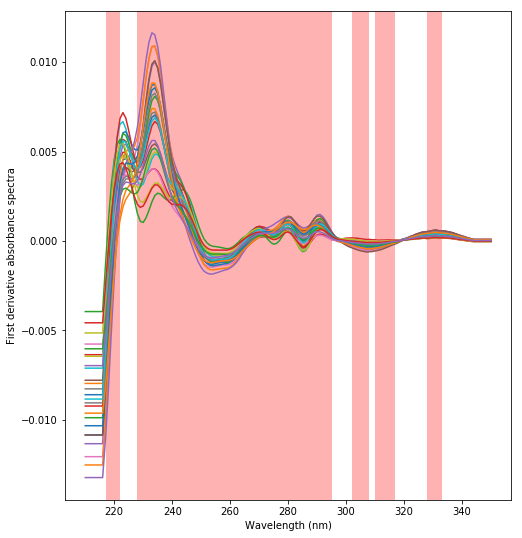

In [63]:
# Run the function
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X2, y, 5,0)

# Get a boolean array according to the indices that are being discarded
ix = np.in1d(wl.ravel(), wl[sorted_ind][:wav])

import matplotlib.collections as collections

# Plot spectra with superimpose selected bands
fig, ax = plt.subplots(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax.plot(wl, X2.T)
    plt.ylabel('First derivative absorbance spectra')
    plt.xlabel('Wavelength (nm)')

collection = collections.BrokenBarHCollection.span_where(
    wl, ymin=-1, ymax=1, where=ix == True, facecolor='red', alpha=0.3)
ax.add_collection(collection)

plt.show()